Import modules

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fftpack as fft
from astropy.io import fits
from scipy import optimize
from poppy import zernike
import time
import pytz

Variables

In [2]:
outD = 7.77010            # primary diameter (m)
inD = 1.024               # inner M2 diameter (m)
n = 48                    # number sample points across the screen (Not the number of subapertures)
nacross = 48              # number of subapertures across the aperture
pscale = outD/(nacross)   # pixel size (m) of samples in pupil plane

make the aperture

In [3]:
#  Aperture containing zeros
x = np.linspace(-(n)/2,(n)/2,n)*pscale 
y = np.linspace(-(n)/2,(n)/2,n)*pscale
mg = np.meshgrid(x,y)
ar = np.sqrt(np.sum((m**2 for m in mg)))
ap_outer = (ar <= outD/2)
ap_inner = (ar <= inD/2)   
ap = (ap_outer ^ ap_inner).astype(int)

#  Aperture containing nans
ap_nan = np.copy(ap.astype(np.float))  
ap_nan[np.where(ap==0)] = np.nan

/home/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


make frequency grid

In [4]:
kx = fft.fftshift(fft.fftfreq(n,pscale))
ky = fft.fftshift(fft.fftfreq(n,pscale))
mg = np.meshgrid(kx,ky)
kr = np.sqrt(np.sum((m**2 for m in mg))) 

/home/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


Get the filename list

In [5]:
rootdir = "/home/sda/mtallis/PhaseScripts/aotelem/Reduced/"  # gpi cruncher

rootdir = "/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/" # personal laptop

rootdir = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/" # kipac computer

In [98]:
fname_list = list()
name_list = list()

for root, dirs, files in os.walk(rootdir):
    for name in files:
        (base,ext) = os.path.splitext(name)
        if ext in ('.fits') and base[0]=='a':
            full_name = os.path.join(root,name)
            fname_list.append(full_name)  
            name_list.append(name)

old name list

In [111]:
summary1 = pd.read_csv(save_path + summary_prefix + '20181114' + '.csv',index_col=0)
summary2 = pd.read_csv(save_path + summary_prefix + '20181119' + '.csv',index_col=0)

In [121]:
old_fname_list = list(summary1['path'].values )+list(summary2['path'].values )
old_name_list = list(summary1['filename'].values )+list(summary2['filename'].values )

In [123]:
new_fname_list = [x for x in fname_list if x not in old_fname_list]
new_name_list = [x for x in name_list if x not in old_name_list]

In [126]:
df = pd.DataFrame({'path':[],'filename':[],'whenstr':[],'slope':[]})
df['path'] = new_fname_list
df['filename'] = new_name_list

In [76]:
#n=0
for file in df.loc[n:,'path']:
    
    hdulist = fits.open(file,memmap=True)
    try:
        whenstr = hdulist[0].header['whenstr']
    except:
        print(n,'_whenstr not found in header for ',df.loc[n,'filename'])
    else:
        whenstr = (df.loc[n,'filename'].split('_')[2] +  df.loc[n,'filename'].split('_')[3]).replace('.','')
        
    df.loc[n,'whenstr'] = whenstr
    n=n+1


20160327205626
20160327213639
20160327223747
20160327005735
20160327212035
20160327014430
20160327011420
20160327013015
20160327202155
20160430063424
20151220021512
20151220024033
20151220025217
20160427011945
20160427004930
20160427052120
20160427013658
20160427003710
20160921020841
20160921001121
20160921021320
20160921005618
20160921022550
20160921023309
20160921010143
20160921053640
20160921061332
20160921023626
20160921062603
20160921002556
20160921021922
20160921063204
20160921023507
20160125060749
34 _whenstr not found in header for  aored_When_2015.8.29_3.43.7_poldm_phase.fits
35 _whenstr not found in header for  aored_When_2015.8.29_3.27.2_poldm_phase.fits
36 _whenstr not found in header for  aored_When_2015.8.29_3.25.56_poldm_phase.fits
37 _whenstr not found in header for  aored_When_2015.8.29_0.43.40_poldm_phase.fits
38 _whenstr not found in header for  aored_When_2015.8.29_3.54.29_poldm_phase.fits
39 _whenstr not found in header for  aored_When_2015.8.29_2.55.44_poldm_phase

Results path

In [101]:
save_path = '/home/sda/mtallis/Results/'
dstr = time.strftime('%Y%m%d')
table_prefix = 'sp_psd_table_'
plots_prefix = 'sp_psd_plot_'
summary_prefix = 'sp_psd_summary'

Analysis functions

In [15]:
def radialProfile(image, center=None):
    """
    Calculate the avearge radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    ## Calculate the indices from the image
    y,x = np.indices((image.shape)) # first determine radii of all pixels
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
     
    r = np.hypot(x - center[0], y - center[1]).astype(np.int) 
    
    n = np.bincount(r.ravel())
    sy = np.bincount(r.ravel(), image.ravel())
    mean = sy/n
    
    return mean

def implot(image, display=True, **kwargs):
    """Plot an image with colorbar.
    
    image - The 2d image
    kwargs - settings for curstomizing plot"""

    ## Create matplotlib figure 
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    cax = ax.imshow(image, cmap = plt.cm.Greys, origin='lower', interpolation='none')
    cbar = fig.colorbar(cax, orientation='vertical')

    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=24)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=16)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=16)
    if 'cbar_label' in kwargs: cbar.set_label(kwargs['cbar_label'], 
                                              fontsize=18)
    if 'save_image' in kwargs: plt.savefig(kwargs['save_image'])

    if display: plt.show()
        
def PSDplot(psd, f, whenstr, filebase, low_bound = 0., up_bound = 2.5, display=False, **kwargs):

    fig = plt.figure(figsize=[10,7])
    ax = fig.add_subplot(111)

    def func(x, a, b):
        return a+(b*x) 
    
    par,pcov = optimize.curve_fit(func,np.log10(freq[(freq > low_bound) & (freq < up_bound)]),
                                  np.log10(psd[(freq > low_bound) & (freq < up_bound)]), p0=(1, -3.5))
    slope = par[0]
    intercept = par[1]
    
    ## Plot original PSD and linear fit
    img = ax.loglog((freq[(freq > low_bound) & (freq < up_bound)]),(psd[(freq > low_bound) & (freq < up_bound)]),
                    'bo',(freq[(freq > low_bound) & (freq < up_bound)]),
                    10**(func(np.log10(freq[(freq > low_bound) & (freq < up_bound)]),*par)), 'r')

    ax.legend(['PSD', 'slope = {0:.2f}, intercept={1:.2f}'.format(slope, intercept)],loc=3, fontsize=15)
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='black', linestyle='-')
    #ax.set_ylabel(r'$\mathrm{{PSD}} \,\, [\mu\mathrm{{m}}^2/\mathrm{{Hz}}]$', fontsize=24)
    #ax.set_xlabel(r'$f$ $\mathrm{[Hz]}$', fontsize=24)
    ax.set_title(whenstr, fontsize=30, y=1.04)
    ax.set_ylabel('Power Spectrum',fontsize=15)
    ax.set_xlabel('Spatial Frequency',fontsize=15)
    
    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=10)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=15)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=15)
    if display: plt.show()
    
    filename = "{0}_PSD{1}.png".format(filebase, whenstr)
    plt.savefig(filename)
    plt.close(fig)

    return slope, intercept

def make_dir(directory_path):
    
    try: 
        os.makedirs(directory_path)
        print('created directory at: ',directory_path)
    except:
        print('directory at: ',directory_path, ' already exists')    

Run analysis

In [127]:
plt.ioff()
n=0
for file in df.loc[n:,'path']:
    
    # open file and extract date of observation
    hdulist = fits.open(file,memmap=True)
    try:
        whenstr = hdulist[0].header['whenstr']
    except:
        print(n,'_whenstr not found in header for ',df.loc[n,'filename'])
    else:
        whenstr = (df.loc[n,'filename'].split('_')[2] +  df.loc[n,'filename'].split('_')[3]).replace('.','')
        
    df.loc[n,'whenstr'] = whenstr
    print('Opened file',df.loc[n,'filename'])
    
    # get data
    phase = hdulist[0].data.astype('float')
    timesteps, phx, phy = phase.shape            # contains a datacube
    avg_phase = np.nanmean(phase*ap_nan,axis=0)  # used to find average zernikes 
    
    # remove zernikes form cube
    z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)
    z_coeff = zernike.opd_expand_nonorthonormal(avg_phase, aperture=ap, nterms=6)
    thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

    c_phase = (phase - thin_lens[None,:,:])*ap_nan
    c_phase[np.isnan(c_phase)]=0.
    print('Done removing zernikes')
    
    # computer fourier transform of cube
    phFT = np.zeros((timesteps,phx,phy), dtype=complex)
    for t in np.arange(timesteps):
        phFT[t,:,:] = fft.fftshift(fft.fft2(c_phase[t,:,:]))/ap.sum()
    print('Done with FT')
    
    
    # compute 2d psd cube
    psd2D = np.zeros((timesteps, phx, phy),dtype=float)
    for k in np.arange(phx):
        for l in np.arange(phy):
            psd2D[:,k,l] = np.abs(phFT[:,k,l])**2
    avg_psd2D = np.mean(psd2D, axis=0)
    print('Done with PSD')    
    
    # compute radial average of 2d psd cube and frequency
    avg_psd1D =  radialProfile(avg_psd2D)
    freq = radialProfile(kr)
    
    #plot PSD vs. freq
    low_bound = 1/(nacross*pscale)
    up_bound = 1/(2*pscale)
    

    fig = plt.figure(figsize=[9,6])
    ax = fig.add_subplot(111)

    def func(x, a, b):
        return a+(b*x) 
    
    par,pcov = optimize.curve_fit(func,np.log10(freq[(freq > low_bound) & (freq < up_bound)]),
                                  np.log10(avg_psd1D[(freq > low_bound) & (freq < up_bound)]), p0=(1, -3.5))
    slope = par[0]
    intercept = par[1]
    
    ## Plot original PSD and linear fit
    img = ax.loglog((freq),(avg_psd1D),'bo',
                    (freq[(freq > low_bound) & (freq < up_bound)]),
                    10**(func(np.log10(freq[(freq > low_bound) & (freq < up_bound)]),*par)), 'r')

    ax.legend(['_nolegend_', 'slope = {0:.2f}, intercept={1:.2f}'.format(slope, intercept)],loc=3, fontsize=15)
    ax.tick_params(axis='both',which='both',labelsize=16,direction='in')
    ax.grid(b=True, which='major', color='black', linestyle='-') 
    ax.set_ylabel('Power Spectrum',fontsize=20)
    ax.set_xlabel('Spatial Frequency',fontsize=20)
    ax.set_title(whenstr,fontsize=20,y=1.04)
    
    # create paths that files will be saved with
    date_dir = os.path.join(save_path,whenstr[0:8])
    sp_psd_dir = os.path.join(date_dir,'sp_psd')
    plots_dir = os.path.join(sp_psd_dir,'plots')
    tables_dir = os.path.join(sp_psd_dir,'tables')
    
    # store plots and tables in date of observation directory
    make_dir(date_dir)
    make_dir(sp_psd_dir)
    make_dir(plots_dir)
    make_dir(tables_dir)
    
    table = pd.DataFrame({'freq':freq,'sp_psd':avg_psd1D})
    table.to_csv(sp_psd_dir + '/tables/' + table_prefix + whenstr + '_' + dstr + '.csv', index=False)
    plt.savefig(sp_psd_dir + '/plots/' + plots_prefix + whenstr + "_" + dstr + '.pdf')
    print('done saving everything')
    
    # store measured slope in summary dataframe
    df.loc[n,'slope'] = slope
    n=n+1
    
df.loc[:,('whenstr','slope')].to_csv(save_path + summary_prefix + dstr + '.csv')

Opened file aored_When_2016.10.13_21.17.57_poldm_phase.fits


/home/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: Mean of empty slice


Done removing zernikes


/home/anaconda3/lib/python3.5/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161013
created directory at:  /home/sda/mtallis/Results/20161013/sp_psd
created directory at:  /home/sda/mtallis/Results/20161013/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161013/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f9014b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.13_21.52.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161013  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f8ea9c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.13_22.30.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161013  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f8d4d2b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.13_21.53.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161013  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f8aad320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.13_22.36.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161013  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f8a80ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.13_21.56.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161013  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f879bef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.13_22.3.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161013  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f881f908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.13_21.45.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161013  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161013/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f87453c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_2.40.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161221
created directory at:  /home/sda/mtallis/Results/20161221/sp_psd
created directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f86a8a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_3.53.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f850d860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_4.51.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f845f358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_5.58.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f82fa978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_2.25.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f83c0a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_6.6.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f8cebd30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_1.3.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f97b5390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_4.4.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f9ede4a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_2.51.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22fcac04a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_0.27.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2300f3bd68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_2.5.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22fde22978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_4.17.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22fb763dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_1.29.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22fa529e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_1.16.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f81d3cc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_5.24.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f80fea58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_5.5.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f7fc7e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_0.17.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f7dabe80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_1.52.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f7db5278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_0.48.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f7d5e240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_2.49.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f7c50b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_6.15.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f7aef710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.21_0.2.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161221  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f7aa2908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.27_6.16.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163276
created directory at:  /home/sda/mtallis/Results/20163276/sp_psd
created directory at:  /home/sda/mtallis/Results/20163276/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163276/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f79cb0f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.27_2.37.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f7885c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.27_4.46.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163274
created directory at:  /home/sda/mtallis/Results/20163274/sp_psd
created directory at:  /home/sda/mtallis/Results/20163274/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163274/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f776fbe0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.27_2.13.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f7532eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.27_4.9.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163274  already exists
directory at:  /home/sda/mtallis/Results/20163274/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163274/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163274/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f75b9eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.27_2.57.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f75535c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.27_21.53.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f73adf98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.27_22.10.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f7377470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
38 _whenstr not found in header for  aored_When_2015.5.3_21.51.42_poldm_phase.fits
Opened file aored_When_2015.5.3_21.51.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f71b3dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
39 _whenstr not found in header for  aored_When_2015.5.3_21.57.19_poldm_phase.fits
Opened file aored_When_2015.5.3_21.57.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f715e400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
40 _whenstr not found in header for  aored_When_2015.5.3_20.42.15_poldm_phase.fits
Opened file aored_When_2015.5.3_20.42.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f702f898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
41 _whenstr not found in header for  aored_When_2015.5.3_22.0.9_poldm_phase.fits
Opened file aored_When_2015.5.3_22.0.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f700a400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
42 _whenstr not found in header for  aored_When_2015.5.3_21.54.31_poldm_phase.fits
Opened file aored_When_2015.5.3_21.54.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f6e4d7f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
43 _whenstr not found in header for  aored_When_2015.5.3_23.8.44_poldm_phase.fits
Opened file aored_When_2015.5.3_23.8.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f6d8fe80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
44 _whenstr not found in header for  aored_When_2015.5.3_22.44.55_poldm_phase.fits
Opened file aored_When_2015.5.3_22.44.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f6c8a588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
45 _whenstr not found in header for  aored_When_2015.5.3_21.32.6_poldm_phase.fits
Opened file aored_When_2015.5.3_21.32.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f6ba1550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
46 _whenstr not found in header for  aored_When_2015.5.3_21.42.45_poldm_phase.fits
Opened file aored_When_2015.5.3_21.42.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f6a00ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
47 _whenstr not found in header for  aored_When_2015.5.3_22.53.15_poldm_phase.fits
Opened file aored_When_2015.5.3_22.53.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f698f9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
48 _whenstr not found in header for  aored_When_2015.5.3_22.2.58_poldm_phase.fits
Opened file aored_When_2015.5.3_22.2.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f679ffd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
49 _whenstr not found in header for  aored_When_2015.5.3_20.33.19_poldm_phase.fits
Opened file aored_When_2015.5.3_20.33.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f66d5710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
50 _whenstr not found in header for  aored_When_2015.5.3_21.46.3_poldm_phase.fits
Opened file aored_When_2015.5.3_21.46.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f65dfb38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
51 _whenstr not found in header for  aored_When_2015.5.3_23.3.34_poldm_phase.fits
Opened file aored_When_2015.5.3_23.3.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f64745f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
52 _whenstr not found in header for  aored_When_2015.5.3_20.49.18_poldm_phase.fits
Opened file aored_When_2015.5.3_20.49.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f63a58d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
53 _whenstr not found in header for  aored_When_2015.5.3_22.55.49_poldm_phase.fits
Opened file aored_When_2015.5.3_22.55.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f6208ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
54 _whenstr not found in header for  aored_When_2015.5.3_22.58.24_poldm_phase.fits
Opened file aored_When_2015.5.3_22.58.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f619b2e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
55 _whenstr not found in header for  aored_When_2015.5.3_20.4.54_poldm_phase.fits
Opened file aored_When_2015.5.3_20.4.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f6160940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
56 _whenstr not found in header for  aored_When_2015.5.3_23.0.59_poldm_phase.fits
Opened file aored_When_2015.5.3_23.0.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f5e9fef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
57 _whenstr not found in header for  aored_When_2015.5.3_21.48.54_poldm_phase.fits
Opened file aored_When_2015.5.3_21.48.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f5f34cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
58 _whenstr not found in header for  aored_When_2015.5.3_22.50.40_poldm_phase.fits
Opened file aored_When_2015.5.3_22.50.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f5dee518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
59 _whenstr not found in header for  aored_When_2015.5.3_23.6.9_poldm_phase.fits
Opened file aored_When_2015.5.3_23.6.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163272  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f5c1f668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.12.30_1.42.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171230
created directory at:  /home/sda/mtallis/Results/20171230/sp_psd
created directory at:  /home/sda/mtallis/Results/20171230/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171230/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f5aaef98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.12.30_4.19.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171230  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f5afff98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.12.30_5.7.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171230  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f5a0d9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.12.30_2.27.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171230  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f59007b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.12.30_22.36.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171230  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f5840d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.12.30_2.30.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171230  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171230/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f5767668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_6.17.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164306  already exists
directory at:  /home/sda/mtallis/Results/20164306/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164306/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164306/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f563ca90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.12.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20164300
created directory at:  /home/sda/mtallis/Results/20164300/sp_psd
created directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f53b8ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.29.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f5483dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_3.58.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20164303
created directory at:  /home/sda/mtallis/Results/20164303/sp_psd
created directory at:  /home/sda/mtallis/Results/20164303/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20164303/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f533c9e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.33.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f5250f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.11.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f5173fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.9.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f511d320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_1.17.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20164301
created directory at:  /home/sda/mtallis/Results/20164301/sp_psd
created directory at:  /home/sda/mtallis/Results/20164301/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20164301/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f4edfc88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_6.9.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164306  already exists
directory at:  /home/sda/mtallis/Results/20164306/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164306/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164306/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e98ac9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.22.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f4e31f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_4.27.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20164304
created directory at:  /home/sda/mtallis/Results/20164304/sp_psd
created directory at:  /home/sda/mtallis/Results/20164304/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20164304/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eec765c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.30.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eeafeeb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_1.56.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164301  already exists
directory at:  /home/sda/mtallis/Results/20164301/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164301/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164301/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eeaa1a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_3.7.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164303  already exists
directory at:  /home/sda/mtallis/Results/20164303/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164303/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164303/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f4d25c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_1.32.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164301  already exists
directory at:  /home/sda/mtallis/Results/20164301/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164301/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164301/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f4c5ac88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.58.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f4b56668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.34.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f4a45978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.21.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f48dca58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.14.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f4689f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_4.52.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164304  already exists
directory at:  /home/sda/mtallis/Results/20164304/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164304/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164304/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f470f5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_2.33.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20164302
created directory at:  /home/sda/mtallis/Results/20164302/sp_psd
created directory at:  /home/sda/mtallis/Results/20164302/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20164302/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f464b438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.32.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f46097b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_2.28.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f5062a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


directory at:  /home/sda/mtallis/Results/20164302  already exists
directory at:  /home/sda/mtallis/Results/20164302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164302/sp_psd/tables  already exists
done saving everything
Opened file aored_When_2016.4.30_3.35.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164303  already exists
directory at:  /home/sda/mtallis/Results/20164303/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164303/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164303/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eec11630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.13.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f690c470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_5.14.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20164305
created directory at:  /home/sda/mtallis/Results/20164305/sp_psd
created directory at:  /home/sda/mtallis/Results/20164305/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20164305/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f6e867b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.40.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f781cef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_5.42.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164305  already exists
directory at:  /home/sda/mtallis/Results/20164305/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164305/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164305/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f230d143940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.31.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f8163eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_1.30.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164301  already exists
directory at:  /home/sda/mtallis/Results/20164301/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164301/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164301/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f7ebf710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.16.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f81a2048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_1.26.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164301  already exists
directory at:  /home/sda/mtallis/Results/20164301/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164301/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164301/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f49883c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.15.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f4451c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.30_0.25.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164300  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164300/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f4330fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_5.38.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f4423160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_0.33.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f4261c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_1.29.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f4053ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_23.59.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f40976d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_22.56.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f3f41518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_23.21.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f3e84b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_5.29.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f3df2630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_23.5.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f3cec470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_0.13.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f3a64e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_21.44.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f395aef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_0.38.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f39c9c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_23.29.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f37b9630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_1.35.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f3809198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_21.59.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f3722da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_1.11.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f34b5978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_22.12.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f34c9358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_23.58.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f33fadd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_0.19.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f31f2f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_23.13.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f331d4e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_22.5.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f315f6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_0.50.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f2ef8198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_22.27.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f2f9b5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_1.17.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f2e44eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_1.23.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f2d75c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.20_0.26.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151220  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f2cf03c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.12.28_21.37.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171228
created directory at:  /home/sda/mtallis/Results/20171228/sp_psd
created directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f2ba0f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.12.28_21.42.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f29e2978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
127 _whenstr not found in header for  aored_When_2015.7.1_3.54.1_poldm_phase.fits
Opened file aored_When_2015.7.1_3.54.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f2994a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
128 _whenstr not found in header for  aored_When_2015.7.1_21.54.17_poldm_phase.fits
Opened file aored_When_2015.7.1_21.54.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f2750f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
129 _whenstr not found in header for  aored_When_2015.7.1_2.44.11_poldm_phase.fits
Opened file aored_When_2015.7.1_2.44.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f279b160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
130 _whenstr not found in header for  aored_When_2015.7.1_19.43.19_poldm_phase.fits
Opened file aored_When_2015.7.1_19.43.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f26e3c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
131 _whenstr not found in header for  aored_When_2015.7.1_5.27.3_poldm_phase.fits
Opened file aored_When_2015.7.1_5.27.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f25c1c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
132 _whenstr not found in header for  aored_When_2015.7.1_3.28.23_poldm_phase.fits
Opened file aored_When_2015.7.1_3.28.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f262a390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists
done saving everything
133 _whenstr not found in header for  aored_When_2015.7.1_2.22.43_poldm_phase.fits
Opened file aored_When_2015.7.1_2.22.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f24107f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
134 _whenstr not found in header for  aored_When_2015.7.1_23.5.50_poldm_phase.fits
Opened file aored_When_2015.7.1_23.5.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f2321fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
135 _whenstr not found in header for  aored_When_2015.7.1_5.29.59_poldm_phase.fits
Opened file aored_When_2015.7.1_5.29.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f2076ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
136 _whenstr not found in header for  aored_When_2015.7.1_22.59.18_poldm_phase.fits
Opened file aored_When_2015.7.1_22.59.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f20f5828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
137 _whenstr not found in header for  aored_When_2015.7.1_23.35.40_poldm_phase.fits
Opened file aored_When_2015.7.1_23.35.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1f059b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
138 _whenstr not found in header for  aored_When_2015.7.1_3.49.58_poldm_phase.fits
Opened file aored_When_2015.7.1_3.49.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1f6b550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
139 _whenstr not found in header for  aored_When_2015.7.1_19.47.7_poldm_phase.fits
Opened file aored_When_2015.7.1_19.47.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1e53588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
140 _whenstr not found in header for  aored_When_2015.7.1_22.42.8_poldm_phase.fits
Opened file aored_When_2015.7.1_22.42.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1bff940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
141 _whenstr not found in header for  aored_When_2015.7.1_20.53.59_poldm_phase.fits
Opened file aored_When_2015.7.1_20.53.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1cd28d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
142 _whenstr not found in header for  aored_When_2015.7.1_2.54.2_poldm_phase.fits
Opened file aored_When_2015.7.1_2.54.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1bb2518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
143 _whenstr not found in header for  aored_When_2015.7.1_22.13.34_poldm_phase.fits
Opened file aored_When_2015.7.1_22.13.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1aaa438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
144 _whenstr not found in header for  aored_When_2015.7.1_3.34.1_poldm_phase.fits
Opened file aored_When_2015.7.1_3.34.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1aa6a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
145 _whenstr not found in header for  aored_When_2015.7.1_3.17.40_poldm_phase.fits
Opened file aored_When_2015.7.1_3.17.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1875898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
146 _whenstr not found in header for  aored_When_2015.7.1_20.54.58_poldm_phase.fits
Opened file aored_When_2015.7.1_20.54.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1693f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
147 _whenstr not found in header for  aored_When_2015.7.1_4.3.32_poldm_phase.fits
Opened file aored_When_2015.7.1_4.3.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1678ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
148 _whenstr not found in header for  aored_When_2015.7.1_3.58.5_poldm_phase.fits
Opened file aored_When_2015.7.1_3.58.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f15d1b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
149 _whenstr not found in header for  aored_When_2015.7.1_3.52.28_poldm_phase.fits
Opened file aored_When_2015.7.1_3.52.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f15a4518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
150 _whenstr not found in header for  aored_When_2015.7.1_3.42.37_poldm_phase.fits
Opened file aored_When_2015.7.1_3.42.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f13e1668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
151 _whenstr not found in header for  aored_When_2015.7.1_2.19.15_poldm_phase.fits
Opened file aored_When_2015.7.1_2.19.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f12bd9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
152 _whenstr not found in header for  aored_When_2015.7.1_21.2.50_poldm_phase.fits
Opened file aored_When_2015.7.1_21.2.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1077828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
153 _whenstr not found in header for  aored_When_2015.7.1_23.16.20_poldm_phase.fits
Opened file aored_When_2015.7.1_23.16.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f11e3668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
154 _whenstr not found in header for  aored_When_2015.7.1_22.15.32_poldm_phase.fits
Opened file aored_When_2015.7.1_22.15.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f0fc05c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
155 _whenstr not found in header for  aored_When_2015.7.1_2.47.55_poldm_phase.fits
Opened file aored_When_2015.7.1_2.47.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f0eb6550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
156 _whenstr not found in header for  aored_When_2015.7.1_1.48.57_poldm_phase.fits
Opened file aored_When_2015.7.1_1.48.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f0dd5b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
157 _whenstr not found in header for  aored_When_2015.7.1_19.57.6_poldm_phase.fits
Opened file aored_When_2015.7.1_19.57.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f0d01400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
158 _whenstr not found in header for  aored_When_2015.7.1_3.53.11_poldm_phase.fits
Opened file aored_When_2015.7.1_3.53.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f0c095c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
159 _whenstr not found in header for  aored_When_2015.8.1_1.55.2_poldm_phase.fits
Opened file aored_When_2015.8.1_1.55.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f0b2be48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
160 _whenstr not found in header for  aored_When_2015.8.1_2.6.38_poldm_phase.fits
Opened file aored_When_2015.8.1_2.6.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f0a65f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
161 _whenstr not found in header for  aored_When_2015.8.1_0.5.55_poldm_phase.fits
Opened file aored_When_2015.8.1_0.5.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f07fa7b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
162 _whenstr not found in header for  aored_When_2015.8.1_1.57.10_poldm_phase.fits
Opened file aored_When_2015.8.1_1.57.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f0a580b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
163 _whenstr not found in header for  aored_When_2015.8.1_2.8.45_poldm_phase.fits
Opened file aored_When_2015.8.1_2.8.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f0631e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
164 _whenstr not found in header for  aored_When_2015.8.1_2.11.21_poldm_phase.fits
Opened file aored_When_2015.8.1_2.11.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f055d240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
165 _whenstr not found in header for  aored_When_2015.8.1_1.9.53_poldm_phase.fits
Opened file aored_When_2015.8.1_1.9.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f04ffb70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
166 _whenstr not found in header for  aored_When_2015.8.1_2.4.48_poldm_phase.fits
Opened file aored_When_2015.8.1_2.4.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f043d940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
167 _whenstr not found in header for  aored_When_2015.8.1_1.56.4_poldm_phase.fits
Opened file aored_When_2015.8.1_1.56.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f040fef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
168 _whenstr not found in header for  aored_When_2015.8.1_1.53.46_poldm_phase.fits
Opened file aored_When_2015.8.1_1.53.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f012cef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
169 _whenstr not found in header for  aored_When_2015.8.1_1.7.13_poldm_phase.fits
Opened file aored_When_2015.8.1_1.7.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f01af438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
170 _whenstr not found in header for  aored_When_2015.8.1_1.58.13_poldm_phase.fits
Opened file aored_When_2015.8.1_1.58.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f00f3f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
171 _whenstr not found in header for  aored_When_2015.8.1_4.30.6_poldm_phase.fits
Opened file aored_When_2015.8.1_4.30.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22effec0b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
172 _whenstr not found in header for  aored_When_2015.8.1_2.3.31_poldm_phase.fits
Opened file aored_When_2015.8.1_2.3.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22efe9ef98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
173 _whenstr not found in header for  aored_When_2014.11.10_3.17.43_poldm_phase.fits
Opened file aored_When_2014.11.10_3.17.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22efd7aef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
174 _whenstr not found in header for  aored_When_2014.11.10_1.23.41_poldm_phase.fits
Opened file aored_When_2014.11.10_1.23.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22efccf748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
175 _whenstr not found in header for  aored_When_2014.11.10_0.38.9_poldm_phase.fits
Opened file aored_When_2014.11.10_0.38.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22efb90710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
176 _whenstr not found in header for  aored_When_2014.11.10_3.29.20_poldm_phase.fits
Opened file aored_When_2014.11.10_3.29.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22efa2f9e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
177 _whenstr not found in header for  aored_When_2014.11.10_22.56.9_poldm_phase.fits
Opened file aored_When_2014.11.10_22.56.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ef9820b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
178 _whenstr not found in header for  aored_When_2014.11.10_21.55.50_poldm_phase.fits
Opened file aored_When_2014.11.10_21.55.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ef8f24a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
179 _whenstr not found in header for  aored_When_2014.11.10_0.41.49_poldm_phase.fits
Opened file aored_When_2014.11.10_0.41.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22efcd9b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
180 _whenstr not found in header for  aored_When_2014.11.10_0.41.2_poldm_phase.fits
Opened file aored_When_2014.11.10_0.41.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f06aa748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
181 _whenstr not found in header for  aored_When_2014.11.10_3.15.4_poldm_phase.fits
Opened file aored_When_2014.11.10_3.15.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1e91e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
182 _whenstr not found in header for  aored_When_2014.11.10_1.26.40_poldm_phase.fits
Opened file aored_When_2014.11.10_1.26.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1b7dfd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
183 _whenstr not found in header for  aored_When_2014.11.10_1.25.33_poldm_phase.fits
Opened file aored_When_2014.11.10_1.25.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f27109b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
184 _whenstr not found in header for  aored_When_2014.11.10_3.32.39_poldm_phase.fits
Opened file aored_When_2014.11.10_3.32.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f3393d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
185 _whenstr not found in header for  aored_When_2014.11.10_0.39.7_poldm_phase.fits
Opened file aored_When_2014.11.10_0.39.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f397e320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
186 _whenstr not found in header for  aored_When_2014.11.10_3.16.5_poldm_phase.fits
Opened file aored_When_2014.11.10_3.16.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f4209978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
187 _whenstr not found in header for  aored_When_2014.11.10_23.17.28_poldm_phase.fits
Opened file aored_When_2014.11.10_23.17.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f0225eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
188 _whenstr not found in header for  aored_When_2014.11.10_0.40.2_poldm_phase.fits
Opened file aored_When_2014.11.10_0.40.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1afed30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
189 _whenstr not found in header for  aored_When_2014.11.10_3.31.48_poldm_phase.fits
Opened file aored_When_2014.11.10_3.31.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f1fca9e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
190 _whenstr not found in header for  aored_When_2014.11.10_3.57.2_poldm_phase.fits
Opened file aored_When_2014.11.10_3.57.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ef7dcf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
191 _whenstr not found in header for  aored_When_2014.11.10_3.14.1_poldm_phase.fits
Opened file aored_When_2014.11.10_3.14.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ef7010b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
192 _whenstr not found in header for  aored_When_2014.11.10_1.22.41_poldm_phase.fits
Opened file aored_When_2014.11.10_1.22.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ef667780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
193 _whenstr not found in header for  aored_When_2014.11.10_21.45.16_poldm_phase.fits
Opened file aored_When_2014.11.10_21.45.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ef4a60f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
194 _whenstr not found in header for  aored_When_2014.11.10_1.24.43_poldm_phase.fits
Opened file aored_When_2014.11.10_1.24.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ef3744a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
195 _whenstr not found in header for  aored_When_2014.11.10_22.17.35_poldm_phase.fits
Opened file aored_When_2014.11.10_22.17.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ef2e0438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
196 _whenstr not found in header for  aored_When_2014.11.10_3.30.9_poldm_phase.fits
Opened file aored_When_2014.11.10_3.30.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ef1d8358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
197 _whenstr not found in header for  aored_When_2014.11.10_3.30.57_poldm_phase.fits
Opened file aored_When_2014.11.10_3.30.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171228  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171228/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ef17bb70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.27_3.16.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20164273
created directory at:  /home/sda/mtallis/Results/20164273/sp_psd
created directory at:  /home/sda/mtallis/Results/20164273/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20164273/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eefd4828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.27_0.0.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164270  already exists
directory at:  /home/sda/mtallis/Results/20164270/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164270/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164270/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eef1fbe0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.27_6.37.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20164276
created directory at:  /home/sda/mtallis/Results/20164276/sp_psd
created directory at:  /home/sda/mtallis/Results/20164276/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20164276/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ee969ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.9.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eed19f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_23.12.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ee88a9e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.50.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ee7b1a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.39.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ee69add8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_3.18.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ee5e0550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.58.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ee5afba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.49.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ee3f0fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.26.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ee2c9f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.53.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ee227d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_5.38.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ee179550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.2.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ee030a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.40.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22edfc7550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.59.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ede69160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.45.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22edcbccc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.43.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22edc0dcf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.56.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22edb49710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.52.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eda14f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.40.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ed9617f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.33.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ed8b68d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.6.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ed76ed68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.7.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ed642eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.35.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ed4dc860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_2.59.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ed330ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.11.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ed3ac240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.42.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ed2bc940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_5.33.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ed04eeb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.54.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ed0976a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.46.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ecff1ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.31.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ece9af28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.27.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ecd83550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.57.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eccace80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_4.27.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ecb99320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.15.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ecaed470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.12.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ec9808d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_23.18.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ec8eab00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_3.25.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ec7c7a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_23.49.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ec5e4eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_23.37.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ec47ce80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.29.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ec3e3ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.8.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ec6195c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.52.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ec309fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_3.45.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ec1fc2b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.25.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ec162b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_23.56.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ebf16f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.55.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ebf6ce80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.20.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ebea0d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_23.42.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ebd607f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_3.8.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ebc52e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.19.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ebb9c860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.1.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ebaf6be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.5.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eb93be10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.30.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eb734f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.36.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eb7f9f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.43.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eb6af860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.37.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eb41ef28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.46.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eb4c7cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_1.49.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eb278eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_2.6.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eb27a940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.14.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eb1c37b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.34.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eb0885f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.49.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eaed8f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.32.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eaf39f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.17.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eadf3048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.19_0.3.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ead460f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
265 _whenstr not found in header for  aored_When_2015.4.4_1.50.18_poldm_phase.fits
Opened file aored_When_2015.4.4_1.50.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eaba6470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
266 _whenstr not found in header for  aored_When_2015.4.4_1.42.7_poldm_phase.fits
Opened file aored_When_2015.4.4_1.42.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eaae2e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
267 _whenstr not found in header for  aored_When_2015.4.4_3.15.46_poldm_phase.fits
Opened file aored_When_2015.4.4_3.15.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ea9c16d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
268 _whenstr not found in header for  aored_When_2015.4.10_2.8.44_poldm_phase.fits
Opened file aored_When_2015.4.10_2.8.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151219  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eaa09320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_21.46.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161218
created directory at:  /home/sda/mtallis/Results/20161218/sp_psd
created directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ea7ca470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_4.39.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ea7755f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_0.26.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ea5eae48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_21.56.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ea533ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_2.44.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ea408048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_1.56.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ea311320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_1.7.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ea246780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_21.59.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ea179358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_23.1.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ea067be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_22.48.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e9f78b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_22.16.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e9ea4e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_3.8.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e9d97a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_0.11.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e9c63f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_1.43.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e99cff60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_3.39.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e9a8efd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_22.10.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e9a67400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_5.0.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e9bf7cc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_3.58.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e9a8e588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_0.48.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eb775f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_2.15.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ec19d240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_4.7.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ecda0e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_2.54.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ec676cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.18_23.12.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161218  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22edc38a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_4.1.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169214
created directory at:  /home/sda/mtallis/Results/20169214/sp_psd
created directory at:  /home/sda/mtallis/Results/20169214/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169214/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ee0dcf60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_22.56.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22f6b9ccf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_4.34.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169214  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e97798d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_3.4.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169213
created directory at:  /home/sda/mtallis/Results/20169213/sp_psd
created directory at:  /home/sda/mtallis/Results/20169213/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169213/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e97337f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_4.12.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169214  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ee776710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_21.24.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22eb3fc5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_22.12.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e971cf60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_5.15.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e9675208> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_4.29.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169214  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e95e68d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_3.49.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169213  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e93ebef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_23.38.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e940db38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_21.5.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e934d630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_7.0.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169217
created directory at:  /home/sda/mtallis/Results/20169217/sp_psd
created directory at:  /home/sda/mtallis/Results/20169217/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169217/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e92575f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_4.40.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169214  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e91879b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_4.43.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169214  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e90bba58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_2.46.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8f99780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_3.42.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169213  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dcbc3eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_4.36.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169214  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8dd2278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_3.28.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169213  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8c4bf60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_6.44.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169216  already exists
directory at:  /home/sda/mtallis/Results/20169216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e2ae3c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_22.0.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8c7b8d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_6.5.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169216  already exists
directory at:  /home/sda/mtallis/Results/20169216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8af2438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_5.22.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8a204e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_21.16.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8951828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_5.6.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e880f4a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_21.44.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8773128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_23.15.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e86a6898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_3.10.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169213  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8565a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_23.20.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e844ed68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_20.56.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e836a940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_4.22.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169214  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e82a8e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_3.16.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169213  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169213/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8186048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_20.40.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8045668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_4.18.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169214  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e7ffbdd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_21.50.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e7efa588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_21.35.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e7d91c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_22.2.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169212  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e7c67b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_4.48.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169214  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169214/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e7be54e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_5.42.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e7ba43c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_5.49.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e7a1a748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_1.28.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169211  already exists
directory at:  /home/sda/mtallis/Results/20169211/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169211/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169211/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e778cf60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_6.53.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169216  already exists
directory at:  /home/sda/mtallis/Results/20169216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e7806ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.21_5.57.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e77af898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
335 _whenstr not found in header for  aored_When_2015.12.4_0.1.28_poldm_phase.fits
Opened file aored_When_2015.12.4_0.1.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e7637e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
336 _whenstr not found in header for  aored_When_2015.12.4_1.40.54_poldm_phase.fits
Opened file aored_When_2015.12.4_1.40.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e750f6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
337 _whenstr not found in header for  aored_When_2015.12.4_0.36.20_poldm_phase.fits
Opened file aored_When_2015.12.4_0.36.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e74475c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
338 _whenstr not found in header for  aored_When_2015.12.4_1.28.38_poldm_phase.fits
Opened file aored_When_2015.12.4_1.28.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e73b4d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
339 _whenstr not found in header for  aored_When_2015.12.4_22.20.36_poldm_phase.fits
Opened file aored_When_2015.12.4_22.20.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e7210898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
340 _whenstr not found in header for  aored_When_2015.12.4_0.46.30_poldm_phase.fits
Opened file aored_When_2015.12.4_0.46.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e7157c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
341 _whenstr not found in header for  aored_When_2015.12.4_22.39.9_poldm_phase.fits
Opened file aored_When_2015.12.4_22.39.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e7005438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
342 _whenstr not found in header for  aored_When_2015.12.4_0.22.21_poldm_phase.fits
Opened file aored_When_2015.12.4_0.22.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e6f6b9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
343 _whenstr not found in header for  aored_When_2015.12.4_21.56.26_poldm_phase.fits
Opened file aored_When_2015.12.4_21.56.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e6e6a550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
344 _whenstr not found in header for  aored_When_2015.12.4_1.50.29_poldm_phase.fits
Opened file aored_When_2015.12.4_1.50.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e6d96e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
345 _whenstr not found in header for  aored_When_2015.12.4_21.45.3_poldm_phase.fits
Opened file aored_When_2015.12.4_21.45.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e6cbc160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
346 _whenstr not found in header for  aored_When_2015.12.4_22.50.30_poldm_phase.fits
Opened file aored_When_2015.12.4_22.50.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e6bb72e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
347 _whenstr not found in header for  aored_When_2015.12.4_21.33.19_poldm_phase.fits
Opened file aored_When_2015.12.4_21.33.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e6aad358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
348 _whenstr not found in header for  aored_When_2015.12.4_0.13.31_poldm_phase.fits
Opened file aored_When_2015.12.4_0.13.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e69a8eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
349 _whenstr not found in header for  aored_When_2015.4.2_0.29.31_poldm_phase.fits
Opened file aored_When_2015.4.2_0.29.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e68169e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
350 _whenstr not found in header for  aored_When_2015.4.2_1.24.35_poldm_phase.fits
Opened file aored_When_2015.4.2_1.24.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e67f14a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
351 _whenstr not found in header for  aored_When_2015.4.2_23.59.45_poldm_phase.fits
Opened file aored_When_2015.4.2_23.59.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169215  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e66f5c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.6.13_2.38.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20176132
created directory at:  /home/sda/mtallis/Results/20176132/sp_psd
created directory at:  /home/sda/mtallis/Results/20176132/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20176132/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e6648d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.6.13_21.1.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20176132  already exists
directory at:  /home/sda/mtallis/Results/20176132/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20176132/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20176132/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e63e9eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.14_21.58.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161014
created directory at:  /home/sda/mtallis/Results/20161014/sp_psd
created directory at:  /home/sda/mtallis/Results/20161014/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161014/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e642c550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.14_21.2.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161014  already exists
directory at:  /home/sda/mtallis/Results/20161014/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161014/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161014/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e630a550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.14_22.29.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e61d8b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


directory at:  /home/sda/mtallis/Results/20161014  already exists
directory at:  /home/sda/mtallis/Results/20161014/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161014/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161014/sp_psd/tables  already exists
done saving everything
Opened file aored_When_2016.10.14_20.59.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161014  already exists
directory at:  /home/sda/mtallis/Results/20161014/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161014/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161014/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e6128828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.14_23.51.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161014  already exists
directory at:  /home/sda/mtallis/Results/20161014/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161014/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161014/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e607ceb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.20_21.7.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161020
created directory at:  /home/sda/mtallis/Results/20161020/sp_psd
created directory at:  /home/sda/mtallis/Results/20161020/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161020/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e5f3f080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.20_21.18.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161020  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e5e17e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.20_21.47.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161020  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e5b90e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.20_2.52.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161020  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e5c34be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.20_22.27.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161020  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e5b9d198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.20_21.57.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161020  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e5a179e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.20_23.28.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161020  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e584acc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.20_3.0.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161020  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e58855c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.20_22.20.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161020  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e575beb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.20_22.8.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161020  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e565cd30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.20_21.33.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161020  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e568fac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.20_21.1.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161020  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e5527668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.20_23.17.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161020  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161020/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e5375588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_5.7.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161255
created directory at:  /home/sda/mtallis/Results/20161255/sp_psd
created directory at:  /home/sda/mtallis/Results/20161255/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161255/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e5172e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_22.27.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161252
created directory at:  /home/sda/mtallis/Results/20161252/sp_psd
created directory at:  /home/sda/mtallis/Results/20161252/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161252/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e5190278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_1.34.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161251
created directory at:  /home/sda/mtallis/Results/20161251/sp_psd
created directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e4ff4d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_1.40.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e5037908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_6.43.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161256  already exists
directory at:  /home/sda/mtallis/Results/20161256/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161256/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161256/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e4e99780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_5.23.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161255  already exists
directory at:  /home/sda/mtallis/Results/20161255/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161255/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161255/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e4d9bef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_0.12.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161250
created directory at:  /home/sda/mtallis/Results/20161250/sp_psd
created directory at:  /home/sda/mtallis/Results/20161250/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161250/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e4bb81d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_0.26.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161250  already exists
directory at:  /home/sda/mtallis/Results/20161250/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161250/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161250/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e4b9c470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_0.5.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161250  already exists
directory at:  /home/sda/mtallis/Results/20161250/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161250/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161250/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e4966ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_6.27.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161256  already exists
directory at:  /home/sda/mtallis/Results/20161256/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161256/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161256/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e4a37390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_1.26.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e479feb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_0.48.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161250  already exists
directory at:  /home/sda/mtallis/Results/20161250/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161250/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161250/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e47f05c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_1.54.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e4591ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_1.7.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e45f5ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_22.48.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161252  already exists
directory at:  /home/sda/mtallis/Results/20161252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e44c9470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_2.11.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161252  already exists
directory at:  /home/sda/mtallis/Results/20161252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e44e9550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.25_1.30.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e42da7b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
389 _whenstr not found in header for  aored_When_2015.8.29_6.22.41_poldm_phase.fits
Opened file aored_When_2015.8.29_6.22.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e422a828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
390 _whenstr not found in header for  aored_When_2015.8.29_23.23.37_poldm_phase.fits
Opened file aored_When_2015.8.29_23.23.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e3fd8f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
391 _whenstr not found in header for  aored_When_2015.8.29_0.12.34_poldm_phase.fits
Opened file aored_When_2015.8.29_0.12.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e4040d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
392 _whenstr not found in header for  aored_When_2015.8.29_6.37.39_poldm_phase.fits
Opened file aored_When_2015.8.29_6.37.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e3f1ce10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
393 _whenstr not found in header for  aored_When_2015.8.29_23.1.25_poldm_phase.fits
Opened file aored_When_2015.8.29_23.1.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e3e2ed30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
394 _whenstr not found in header for  aored_When_2015.8.29_23.35.42_poldm_phase.fits
Opened file aored_When_2015.8.29_23.35.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e3d188d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
395 _whenstr not found in header for  aored_When_2015.8.29_3.57.15_poldm_phase.fits
Opened file aored_When_2015.8.29_3.57.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e3b9ba90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
396 _whenstr not found in header for  aored_When_2015.8.29_6.12.7_poldm_phase.fits
Opened file aored_When_2015.8.29_6.12.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e3b1f6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
397 _whenstr not found in header for  aored_When_2015.8.29_6.52.39_poldm_phase.fits
Opened file aored_When_2015.8.29_6.52.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e3a12780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
398 _whenstr not found in header for  aored_When_2015.8.29_2.59.0_poldm_phase.fits
Opened file aored_When_2015.8.29_2.59.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e391c710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
399 _whenstr not found in header for  aored_When_2015.8.29_3.0.20_poldm_phase.fits
Opened file aored_When_2015.8.29_3.0.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e392e400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
400 _whenstr not found in header for  aored_When_2015.8.29_23.49.8_poldm_phase.fits
Opened file aored_When_2015.8.29_23.49.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161251  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161251/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e37235c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_0.52.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172140
created directory at:  /home/sda/mtallis/Results/20172140/sp_psd
created directory at:  /home/sda/mtallis/Results/20172140/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172140/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e360d668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_2.3.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172142
created directory at:  /home/sda/mtallis/Results/20172142/sp_psd
created directory at:  /home/sda/mtallis/Results/20172142/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172142/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e3557978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_1.3.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172141
created directory at:  /home/sda/mtallis/Results/20172141/sp_psd
created directory at:  /home/sda/mtallis/Results/20172141/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172141/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e347f4a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_6.48.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172146
created directory at:  /home/sda/mtallis/Results/20172146/sp_psd
created directory at:  /home/sda/mtallis/Results/20172146/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172146/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e337b4a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_1.34.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172141  already exists
directory at:  /home/sda/mtallis/Results/20172141/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172141/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172141/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e32cc3c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_4.23.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172144
created directory at:  /home/sda/mtallis/Results/20172144/sp_psd
created directory at:  /home/sda/mtallis/Results/20172144/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172144/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e3103b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_1.14.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172141  already exists
directory at:  /home/sda/mtallis/Results/20172141/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172141/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172141/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e3072dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_2.49.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172142  already exists
directory at:  /home/sda/mtallis/Results/20172142/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172142/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172142/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e2e16f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_5.7.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172145
created directory at:  /home/sda/mtallis/Results/20172145/sp_psd
created directory at:  /home/sda/mtallis/Results/20172145/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172145/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e2e78b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_4.35.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172144  already exists
directory at:  /home/sda/mtallis/Results/20172144/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172144/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172144/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e2d55dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_2.42.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e34a8320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


directory at:  /home/sda/mtallis/Results/20172142  already exists
directory at:  /home/sda/mtallis/Results/20172142/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172142/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172142/sp_psd/tables  already exists
done saving everything
Opened file aored_When_2017.2.14_6.1.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172146  already exists
directory at:  /home/sda/mtallis/Results/20172146/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172146/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172146/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e3e147b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_3.18.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172143
created directory at:  /home/sda/mtallis/Results/20172143/sp_psd
created directory at:  /home/sda/mtallis/Results/20172143/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172143/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e4a84860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_6.52.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172146  already exists
directory at:  /home/sda/mtallis/Results/20172146/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172146/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172146/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e5774828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_3.50.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172143  already exists
directory at:  /home/sda/mtallis/Results/20172143/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172143/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172143/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e5482630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_6.17.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172146  already exists
directory at:  /home/sda/mtallis/Results/20172146/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172146/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172146/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e60de518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_1.25.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172141  already exists
directory at:  /home/sda/mtallis/Results/20172141/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172141/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172141/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e7326390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_3.40.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172143  already exists
directory at:  /home/sda/mtallis/Results/20172143/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172143/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172143/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e6f22048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_4.47.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172144  already exists
directory at:  /home/sda/mtallis/Results/20172144/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172144/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172144/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e869e898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_3.4.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172143  already exists
directory at:  /home/sda/mtallis/Results/20172143/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172143/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172143/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8fecb70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_5.19.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172145  already exists
directory at:  /home/sda/mtallis/Results/20172145/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172145/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172145/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8671f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_4.8.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172144  already exists
directory at:  /home/sda/mtallis/Results/20172144/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172144/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172144/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e94d27f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_1.47.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172141  already exists
directory at:  /home/sda/mtallis/Results/20172141/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172141/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172141/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ec91ff98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_5.52.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172145  already exists
directory at:  /home/sda/mtallis/Results/20172145/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172145/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172145/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e6779e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_2.13.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172142  already exists
directory at:  /home/sda/mtallis/Results/20172142/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172142/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172142/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e921dcf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.14_4.57.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172144  already exists
directory at:  /home/sda/mtallis/Results/20172144/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172144/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172144/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e2b48f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.21_3.18.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172213
created directory at:  /home/sda/mtallis/Results/20172213/sp_psd
created directory at:  /home/sda/mtallis/Results/20172213/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172213/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e77f6e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.19_23.28.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20174192
created directory at:  /home/sda/mtallis/Results/20174192/sp_psd
created directory at:  /home/sda/mtallis/Results/20174192/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20174192/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e2bb05c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.19_22.53.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174192  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e2a497f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.19_23.15.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174192  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e294e6d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.19_23.46.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174192  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e287eef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.19_22.10.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174192  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e25aaf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.19_22.29.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174192  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e2624c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_4.54.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161217
created directory at:  /home/sda/mtallis/Results/20161217/sp_psd
created directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e25e1b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_3.55.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e24caeb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_22.49.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e2371e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_1.21.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e234e588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_4.14.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e2162e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_21.50.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e21059b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_2.47.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e1eeaba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_3.9.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e1e66cc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_1.30.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e1d64be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_3.40.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e1cbbf60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_1.2.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e1ba2518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_0.6.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e1b1b9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_23.7.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e1a4d9e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_4.33.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e193bfd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_22.29.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e1677e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.17_23.46.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161217  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e1632048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_4.27.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171129
created directory at:  /home/sda/mtallis/Results/20171129/sp_psd
created directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e14a2978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_0.0.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e14f3940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_3.49.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e13f29e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_0.46.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e12ee588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_1.38.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e1306f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_6.11.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e10ea080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_4.50.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e1052f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_5.31.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e0f5a710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_1.18.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e0e7cda0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_4.11.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e0d3d748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_0.33.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e0d00860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_5.50.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e0af3780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_1.23.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e0a25a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_0.43.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e09f6400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_0.56.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e08c0e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_1.5.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e079b518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_1.11.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e0757278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_0.50.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e05c1ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_1.2.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e046d390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_1.41.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e0435e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists
done saving everything
Opened file aored_When_2017.11.29_2.51.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e038ce48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_1.26.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e01ced68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_5.15.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e00dc9e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.29_0.36.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171129  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171129/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dfffd390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_1.18.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171111
created directory at:  /home/sda/mtallis/Results/20171111/sp_psd
created directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dfeb7400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_3.34.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dfca0e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_5.7.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dfd5fe80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_1.58.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dfc14470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_1.29.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dfb49710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_3.25.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dfa006a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_5.45.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22df83ecc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_3.32.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22df815b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_4.25.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22df75a208> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_3.50.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22df6455f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_4.6.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22df578198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_1.5.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22df447b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_3.39.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22df32bf98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_5.6.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22df232940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_1.32.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22df161400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_0.3.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22df092b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_1.54.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22defb6ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_4.27.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ded9b9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_4.16.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ded769b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_3.21.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22decc12e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_0.1.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dec10470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_3.17.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22deb0cb70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_5.1.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dea192b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_1.36.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22de835e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_2.26.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22de7fd668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_4.57.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22de6cd5c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_4.49.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22de62e0b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_0.49.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22de534748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_5.39.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22de42b358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_5.30.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22de364f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_6.9.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22de27c940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_2.13.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22de1aef28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_3.6.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22de079be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_0.45.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ddf1b668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_3.41.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dde28b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_3.0.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dddadcf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_3.14.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ddd1eac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_5.22.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ddbed5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_0.52.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ddaffe48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_4.19.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dda4c748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_1.48.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dd93f6d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_4.3.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dd72cb00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_0.23.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dd6f1550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_2.43.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dd5ed4a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_4.31.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dd528be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_2.20.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dd266e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_5.53.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dd35cd68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.11_4.44.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171111  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171111/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dd27f748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.25_23.43.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165252  already exists
directory at:  /home/sda/mtallis/Results/20165252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dd160860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.25_23.8.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165252  already exists
directory at:  /home/sda/mtallis/Results/20165252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dd0874e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.16_3.15.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172163
created directory at:  /home/sda/mtallis/Results/20172163/sp_psd
created directory at:  /home/sda/mtallis/Results/20172163/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172163/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dcfbc128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.16_5.0.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172165
created directory at:  /home/sda/mtallis/Results/20172165/sp_psd
created directory at:  /home/sda/mtallis/Results/20172165/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172165/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dce8b908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.16_6.7.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172166
created directory at:  /home/sda/mtallis/Results/20172166/sp_psd
created directory at:  /home/sda/mtallis/Results/20172166/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172166/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dcc8a4e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.16_2.37.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172162
created directory at:  /home/sda/mtallis/Results/20172162/sp_psd
created directory at:  /home/sda/mtallis/Results/20172162/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172162/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dcc90940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.16_4.45.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172164
created directory at:  /home/sda/mtallis/Results/20172164/sp_psd
created directory at:  /home/sda/mtallis/Results/20172164/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172164/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dca62ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.16_5.34.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172165  already exists
directory at:  /home/sda/mtallis/Results/20172165/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172165/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172165/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22be620e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.16_2.54.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172162  already exists
directory at:  /home/sda/mtallis/Results/20172162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d069e0f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.16_2.14.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172162  already exists
directory at:  /home/sda/mtallis/Results/20172162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d06ea748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.16_6.39.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172166  already exists
directory at:  /home/sda/mtallis/Results/20172166/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172166/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172166/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d6802128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.16_4.10.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172164  already exists
directory at:  /home/sda/mtallis/Results/20172164/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172164/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172164/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d67a9ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.16_4.24.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172164  already exists
directory at:  /home/sda/mtallis/Results/20172164/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172164/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172164/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dc84fba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.16_1.54.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172161
created directory at:  /home/sda/mtallis/Results/20172161/sp_psd
created directory at:  /home/sda/mtallis/Results/20172161/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172161/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dc654cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.21_3.17.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161021
created directory at:  /home/sda/mtallis/Results/20161021/sp_psd
created directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dc63f0b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.21_3.9.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dc5882e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.21_5.45.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dc4d0438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.21_22.2.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dc2a9ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.21_22.12.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dc25be48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.21_3.37.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dc196550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.21_0.40.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dc0e26a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.21_5.7.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dbfc4128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.21_2.7.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dbe19a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.21_5.22.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dbd7b518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.21_23.23.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dbcb1a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
547 _whenstr not found in header for  aored_When_2015.2.1_0.26.21_poldm_phase.fits
Opened file aored_When_2015.2.1_0.26.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dbb85160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
548 _whenstr not found in header for  aored_When_2015.2.1_5.12.4_poldm_phase.fits
Opened file aored_When_2015.2.1_5.12.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dbaf8898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
549 _whenstr not found in header for  aored_When_2015.2.1_2.8.58_poldm_phase.fits
Opened file aored_When_2015.2.1_2.8.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22db9f4898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
550 _whenstr not found in header for  aored_When_2015.2.1_5.9.0_poldm_phase.fits
Opened file aored_When_2015.2.1_5.9.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22db8f1ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
551 _whenstr not found in header for  aored_When_2015.2.1_0.13.22_poldm_phase.fits
Opened file aored_When_2015.2.1_0.13.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22db7e0358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
552 _whenstr not found in header for  aored_When_2015.2.1_6.26.17_poldm_phase.fits
Opened file aored_When_2015.2.1_6.26.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22db6c2dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
553 _whenstr not found in header for  aored_When_2015.2.1_5.23.0_poldm_phase.fits
Opened file aored_When_2015.2.1_5.23.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22db5c4c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
554 _whenstr not found in header for  aored_When_2015.2.1_5.45.1_poldm_phase.fits
Opened file aored_When_2015.2.1_5.45.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161021  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161021/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22db498a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_19.3.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178519
created directory at:  /home/sda/mtallis/Results/20178519/sp_psd
created directory at:  /home/sda/mtallis/Results/20178519/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178519/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22db37cc18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_21.50.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178521
created directory at:  /home/sda/mtallis/Results/20178521/sp_psd
created directory at:  /home/sda/mtallis/Results/20178521/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178521/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22db32ef60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_20.36.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178520
created directory at:  /home/sda/mtallis/Results/20178520/sp_psd
created directory at:  /home/sda/mtallis/Results/20178520/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178520/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22db1bd0b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_19.39.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178519  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22db175978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_20.13.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178520  already exists
directory at:  /home/sda/mtallis/Results/20178520/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178520/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178520/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dafbe5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_19.16.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178519  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22daf1ab38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_20.50.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178520  already exists
directory at:  /home/sda/mtallis/Results/20178520/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178520/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178520/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22db1df8d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_20.27.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178520  already exists
directory at:  /home/sda/mtallis/Results/20178520/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178520/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178520/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22db807278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_19.59.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178519  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dbbbdf98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_19.26.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178519  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dc5a5c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_21.18.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178521  already exists
directory at:  /home/sda/mtallis/Results/20178521/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178521/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178521/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ddaa9470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_18.53.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178518
created directory at:  /home/sda/mtallis/Results/20178518/sp_psd
created directory at:  /home/sda/mtallis/Results/20178518/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178518/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dd8a69e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_20.7.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178520  already exists
directory at:  /home/sda/mtallis/Results/20178520/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178520/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178520/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22df0d3a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_19.33.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178519  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178519/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22df8f0b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.5_21.31.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178521  already exists
directory at:  /home/sda/mtallis/Results/20178521/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178521/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178521/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e0388be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.16_21.56.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20151216
created directory at:  /home/sda/mtallis/Results/20151216/sp_psd
created directory at:  /home/sda/mtallis/Results/20151216/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20151216/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dffbcac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.16_22.28.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151216  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e174cf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.16_22.16.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151216  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e209b6d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.16_22.10.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151216  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e29fdcf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.16_22.22.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151216  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e8dc7ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.16_22.37.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151216  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e86fb518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_22.7.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163192  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dadafb70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_3.3.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163193
created directory at:  /home/sda/mtallis/Results/20163193/sp_psd
created directory at:  /home/sda/mtallis/Results/20163193/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163193/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ddac9d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_0.58.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163190
created directory at:  /home/sda/mtallis/Results/20163190/sp_psd
created directory at:  /home/sda/mtallis/Results/20163190/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163190/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dba469e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_0.14.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163190  already exists
directory at:  /home/sda/mtallis/Results/20163190/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163190/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163190/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e0640cc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_22.27.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163192  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22db45d0b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_20.50.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163192  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dad08f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_2.26.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163192  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dac9cda0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_1.11.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163191
created directory at:  /home/sda/mtallis/Results/20163191/sp_psd
created directory at:  /home/sda/mtallis/Results/20163191/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163191/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dac546a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_2.46.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163192  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22daa91470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_21.29.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163192  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22da9dafd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_2.6.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163192  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22da783a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_1.25.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163191  already exists
directory at:  /home/sda/mtallis/Results/20163191/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163191/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163191/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22da7e55c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_21.12.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163192  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22da731588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.19_21.53.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163192  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22da594898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.27_21.20.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161272  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22da3beef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.27_22.27.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161272  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22da4115c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.27_22.11.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161272  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22da4307f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.27_21.51.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161272  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22da206f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.27_22.47.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161272  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22da156f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.27_21.8.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161272  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22da08fcf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.27_22.2.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161272  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d9f5d9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.27_22.55.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161272  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d9e9fc88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_5.23.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161220
created directory at:  /home/sda/mtallis/Results/20161220/sp_psd
created directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d9eb29b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_23.47.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d9cb03c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_2.21.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d9a8df28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_0.59.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d9addba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_3.46.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d99d8da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_4.7.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d9975550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_1.20.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d97c0cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_3.35.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d97036a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_2.49.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d963beb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_1.8.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d956a630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_0.8.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d94705c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_23.40.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d9368908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_23.7.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d9328ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_0.21.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d91b8748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_3.26.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8f08eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_22.53.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8fef0f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_2.11.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8eed828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_22.40.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8d61b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_3.56.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8b3ce80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_3.3.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8bc1ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_4.55.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8bcf668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.20_1.28.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d89c7400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
620 _whenstr not found in header for  aored_When_2015.5.1_0.52.27_poldm_phase.fits
Opened file aored_When_2015.5.1_0.52.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d891f748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
621 _whenstr not found in header for  aored_When_2015.5.1_0.30.19_poldm_phase.fits
Opened file aored_When_2015.5.1_0.30.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d884c198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
622 _whenstr not found in header for  aored_When_2015.5.1_3.48.20_poldm_phase.fits
Opened file aored_When_2015.5.1_3.48.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8bc4b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
623 _whenstr not found in header for  aored_When_2015.5.1_2.53.28_poldm_phase.fits
Opened file aored_When_2015.5.1_2.53.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8614e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
624 _whenstr not found in header for  aored_When_2015.5.1_0.27.37_poldm_phase.fits
Opened file aored_When_2015.5.1_0.27.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8506f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
625 _whenstr not found in header for  aored_When_2015.5.1_1.52.47_poldm_phase.fits
Opened file aored_When_2015.5.1_1.52.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d84b3e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
626 _whenstr not found in header for  aored_When_2015.5.1_0.23.42_poldm_phase.fits
Opened file aored_When_2015.5.1_0.23.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8307940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
627 _whenstr not found in header for  aored_When_2015.5.1_0.43.59_poldm_phase.fits
Opened file aored_When_2015.5.1_0.43.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8261c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
628 _whenstr not found in header for  aored_When_2015.5.1_3.19.57_poldm_phase.fits
Opened file aored_When_2015.5.1_3.19.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d80165c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
629 _whenstr not found in header for  aored_When_2015.5.1_3.55.11_poldm_phase.fits
Opened file aored_When_2015.5.1_3.55.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161220  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8099668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.20_22.16.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163202
created directory at:  /home/sda/mtallis/Results/20163202/sp_psd
created directory at:  /home/sda/mtallis/Results/20163202/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163202/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d7f574a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.20_23.26.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163202  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d7eab358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.20_22.3.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163202  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d7d66860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.20_23.48.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163202  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d7ca76a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.20_21.17.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163202  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d7aeaa58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.20_23.8.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163202  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d7a47208> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.20_21.8.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163202  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d7984ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.20_22.33.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163202  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d787e7b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.20_0.19.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163200  already exists
directory at:  /home/sda/mtallis/Results/20163200/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163200/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163200/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d78348d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.4_19.28.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178419
created directory at:  /home/sda/mtallis/Results/20178419/sp_psd
created directory at:  /home/sda/mtallis/Results/20178419/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178419/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d76d4710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.4_21.38.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178421
created directory at:  /home/sda/mtallis/Results/20178421/sp_psd
created directory at:  /home/sda/mtallis/Results/20178421/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178421/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d75d6ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.41.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169201
created directory at:  /home/sda/mtallis/Results/20169201/sp_psd
created directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d74d72e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_0.50.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169200  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d74062b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_4.58.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169204  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d72ce5c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.44.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d72242b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_21.53.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169202
created directory at:  /home/sda/mtallis/Results/20169202/sp_psd
created directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d7164e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.10.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d7024a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_5.12.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169205
created directory at:  /home/sda/mtallis/Results/20169205/sp_psd
created directory at:  /home/sda/mtallis/Results/20169205/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169205/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d6f0bd30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_22.18.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d6eb4898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_22.6.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d6cf6748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.39.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d6c75128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_21.0.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d6a5e748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.8.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d6a104e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_6.30.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169206
created directory at:  /home/sda/mtallis/Results/20169206/sp_psd
created directory at:  /home/sda/mtallis/Results/20169206/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169206/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d66fbe80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_4.29.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169204  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d68e6a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_2.47.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d661c400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.13.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d65553c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_21.1.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d6381e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_0.46.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169200  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d6368ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_6.54.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169206  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d62a74e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_0.52.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169200  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d6074ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.48.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d60935f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.25.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d5f42470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_22.24.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d5ee4a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_3.22.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169203
created directory at:  /home/sda/mtallis/Results/20169203/sp_psd
created directory at:  /home/sda/mtallis/Results/20169203/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169203/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d5dfc208> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_5.7.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169205  already exists
directory at:  /home/sda/mtallis/Results/20169205/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169205/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169205/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d5d36390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_2.42.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d5b782b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_23.19.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d5ad5908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_7.14.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169207
created directory at:  /home/sda/mtallis/Results/20169207/sp_psd
created directory at:  /home/sda/mtallis/Results/20169207/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169207/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d5a022b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_3.12.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169203  already exists
directory at:  /home/sda/mtallis/Results/20169203/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169203/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169203/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d590d940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_23.45.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d58f8898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_0.39.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169200  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d55d0f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_3.46.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169203  already exists
directory at:  /home/sda/mtallis/Results/20169203/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169203/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169203/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d564d5c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_0.49.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169200  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d558e828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_2.39.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d54b7470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_23.29.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d53a9588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_21.19.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d52dc518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_23.6.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d51ee9e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.51.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d50fa278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_22.0.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d4f83cc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_2.57.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d4e59320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_4.5.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169204  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d4dde0b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_2.22.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d4d071d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.56.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d4bc4d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_0.28.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169200  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d4a30a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_22.21.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d4a7b860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_2.2.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d4916780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.14.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d487a358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_6.0.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169206  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d47587f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_6.13.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169206  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d464ae10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.21.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d454deb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.16.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d44f37b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_7.4.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169207  already exists
directory at:  /home/sda/mtallis/Results/20169207/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169207/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169207/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d4394d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_5.37.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169205  already exists
directory at:  /home/sda/mtallis/Results/20169205/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169205/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169205/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d4297f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_2.12.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d41e90b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_4.13.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169204  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d40ee518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_6.21.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169206  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d3e60f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_21.47.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d3ec5e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_21.8.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d3e24710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_6.6.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169206  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d3dc0c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.0.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d3c1a2b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_0.56.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169200  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d3994f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_23.52.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d3a65128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_6.41.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169206  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169206/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d3968630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_0.16.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169200  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d384cf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_4.55.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169204  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169204/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d376bc50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.3.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d3650898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_5.54.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169205  already exists
directory at:  /home/sda/mtallis/Results/20169205/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169205/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169205/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d35366d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.23.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d340e208> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_3.38.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169203  already exists
directory at:  /home/sda/mtallis/Results/20169203/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169203/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169203/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d338c278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_22.57.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169202  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d3289438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_0.58.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169200  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169200/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d305feb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_5.22.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169205  already exists
directory at:  /home/sda/mtallis/Results/20169205/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169205/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169205/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d30d85c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.20_1.46.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169201  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d300d320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.17_21.19.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d2ed5a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.17_21.31.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d2e1ccf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.17_4.3.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163174
created directory at:  /home/sda/mtallis/Results/20163174/sp_psd
created directory at:  /home/sda/mtallis/Results/20163174/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163174/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d2bfbe80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.17_23.2.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d2c7f048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.17_23.43.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d2bd3d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.17_22.25.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d2ab70b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.17_20.51.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d29676a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.17_4.29.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163174  already exists
directory at:  /home/sda/mtallis/Results/20163174/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163174/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163174/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d2937630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.17_4.11.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163174  already exists
directory at:  /home/sda/mtallis/Results/20163174/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163174/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163174/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d27f0898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.17_22.37.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d26cd6d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.17_21.48.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d2571b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.17_3.9.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163173
created directory at:  /home/sda/mtallis/Results/20163173/sp_psd
created directory at:  /home/sda/mtallis/Results/20163173/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163173/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d236fc88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.17_21.4.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d23b91d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
727 _whenstr not found in header for  aored_When_2014.11.7_22.16.46_poldm_phase.fits
Opened file aored_When_2014.11.7_22.16.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d2258a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
728 _whenstr not found in header for  aored_When_2014.11.7_22.16.0_poldm_phase.fits
Opened file aored_When_2014.11.7_22.16.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d217d978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
729 _whenstr not found in header for  aored_When_2014.11.7_22.11.15_poldm_phase.fits
Opened file aored_When_2014.11.7_22.11.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d1fc7ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
730 _whenstr not found in header for  aored_When_2014.11.7_22.17.35_poldm_phase.fits
Opened file aored_When_2014.11.7_22.17.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d1fb95f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
731 _whenstr not found in header for  aored_When_2014.11.7_22.13.27_poldm_phase.fits
Opened file aored_When_2014.11.7_22.13.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d1eb6208> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
732 _whenstr not found in header for  aored_When_2014.11.7_22.18.24_poldm_phase.fits
Opened file aored_When_2014.11.7_22.18.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d1e80cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
733 _whenstr not found in header for  aored_When_2014.11.7_22.15.12_poldm_phase.fits
Opened file aored_When_2014.11.7_22.15.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d1c4dc18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
734 _whenstr not found in header for  aored_When_2014.11.7_22.7.46_poldm_phase.fits
Opened file aored_When_2014.11.7_22.7.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163172  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d1ba4c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.22_0.46.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161122
created directory at:  /home/sda/mtallis/Results/20161122/sp_psd
created directory at:  /home/sda/mtallis/Results/20161122/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161122/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d1b46828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.22_0.38.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161122  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d19b1240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
737 _whenstr not found in header for  aored_When_2015.11.3_2.42.9_poldm_phase.fits
Opened file aored_When_2015.11.3_2.42.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161122  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d1885278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
738 _whenstr not found in header for  aored_When_2015.11.3_2.10.31_poldm_phase.fits
Opened file aored_When_2015.11.3_2.10.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161122  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d1854320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
739 _whenstr not found in header for  aored_When_2015.11.3_3.33.57_poldm_phase.fits
Opened file aored_When_2015.11.3_3.33.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161122  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d168ee10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
740 _whenstr not found in header for  aored_When_2015.11.3_2.3.7_poldm_phase.fits
Opened file aored_When_2015.11.3_2.3.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161122  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d15fd978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
741 _whenstr not found in header for  aored_When_2015.11.3_3.38.12_poldm_phase.fits
Opened file aored_When_2015.11.3_3.38.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161122  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d173be48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
742 _whenstr not found in header for  aored_When_2015.11.3_4.12.44_poldm_phase.fits
Opened file aored_When_2015.11.3_4.12.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161122  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d2d424e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
743 _whenstr not found in header for  aored_When_2015.11.3_2.30.41_poldm_phase.fits
Opened file aored_When_2015.11.3_2.30.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161122  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d2d1a390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
744 _whenstr not found in header for  aored_When_2015.11.3_3.3.55_poldm_phase.fits
Opened file aored_When_2015.11.3_3.3.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161122  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d445e4a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
745 _whenstr not found in header for  aored_When_2015.11.3_3.16.30_poldm_phase.fits
Opened file aored_When_2015.11.3_3.16.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161122  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d4e0afd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
746 _whenstr not found in header for  aored_When_2014.12.15_23.2.2_poldm_phase.fits
Opened file aored_When_2014.12.15_23.2.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161122  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d586f6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.26_6.3.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20162266
created directory at:  /home/sda/mtallis/Results/20162266/sp_psd
created directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d58122b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
748 _whenstr not found in header for  aored_When_2015.11.30_5.31.56_poldm_phase.fits
Opened file aored_When_2015.11.30_5.31.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d5e697b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
749 _whenstr not found in header for  aored_When_2015.11.30_5.13.52_poldm_phase.fits
Opened file aored_When_2015.11.30_5.13.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d6a61940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
750 _whenstr not found in header for  aored_When_2015.11.30_23.26.29_poldm_phase.fits
Opened file aored_When_2015.11.30_23.26.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d7734be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
751 _whenstr not found in header for  aored_When_2015.11.30_0.8.36_poldm_phase.fits
Opened file aored_When_2015.11.30_0.8.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d7dce6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
752 _whenstr not found in header for  aored_When_2015.11.30_2.10.40_poldm_phase.fits
Opened file aored_When_2015.11.30_2.10.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8b56e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
753 _whenstr not found in header for  aored_When_2015.11.30_2.55.10_poldm_phase.fits
Opened file aored_When_2015.11.30_2.55.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8ded710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
754 _whenstr not found in header for  aored_When_2015.11.30_3.41.14_poldm_phase.fits
Opened file aored_When_2015.11.30_3.41.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d9cd7780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
755 _whenstr not found in header for  aored_When_2015.11.30_22.43.57_poldm_phase.fits
Opened file aored_When_2015.11.30_22.43.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e0c79f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
756 _whenstr not found in header for  aored_When_2015.11.30_2.20.55_poldm_phase.fits
Opened file aored_When_2015.11.30_2.20.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22e0827b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
757 _whenstr not found in header for  aored_When_2015.11.30_2.38.41_poldm_phase.fits
Opened file aored_When_2015.11.30_2.38.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d1545fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
758 _whenstr not found in header for  aored_When_2015.11.30_22.56.3_poldm_phase.fits
Opened file aored_When_2015.11.30_22.56.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d1ea1668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
759 _whenstr not found in header for  aored_When_2015.11.30_4.1.36_poldm_phase.fits
Opened file aored_When_2015.11.30_4.1.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d73a42b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
760 _whenstr not found in header for  aored_When_2015.11.30_23.14.46_poldm_phase.fits
Opened file aored_When_2015.11.30_23.14.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d1bfcdd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
761 _whenstr not found in header for  aored_When_2015.11.30_1.55.18_poldm_phase.fits
Opened file aored_When_2015.11.30_1.55.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d9b4cef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
762 _whenstr not found in header for  aored_When_2015.11.30_4.10.32_poldm_phase.fits
Opened file aored_When_2015.11.30_4.10.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d8246ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
763 _whenstr not found in header for  aored_When_2015.11.30_21.35.27_poldm_phase.fits
Opened file aored_When_2015.11.30_21.35.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d26d7630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
764 _whenstr not found in header for  aored_When_2015.11.30_21.19.19_poldm_phase.fits
Opened file aored_When_2015.11.30_21.19.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d13c5470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
765 _whenstr not found in header for  aored_When_2015.11.30_0.42.42_poldm_phase.fits
Opened file aored_When_2015.11.30_0.42.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d13bec50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
766 _whenstr not found in header for  aored_When_2015.11.30_2.47.36_poldm_phase.fits
Opened file aored_When_2015.11.30_2.47.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d1203a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
767 _whenstr not found in header for  aored_When_2015.11.30_5.42.15_poldm_phase.fits
Opened file aored_When_2015.11.30_5.42.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d11beba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
768 _whenstr not found in header for  aored_When_2015.11.30_22.23.4_poldm_phase.fits
Opened file aored_When_2015.11.30_22.23.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d107c470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
769 _whenstr not found in header for  aored_When_2015.11.30_1.37.34_poldm_phase.fits
Opened file aored_When_2015.11.30_1.37.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d0f41080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
770 _whenstr not found in header for  aored_When_2015.11.30_21.7.38_poldm_phase.fits
Opened file aored_When_2015.11.30_21.7.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d0d10940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
771 _whenstr not found in header for  aored_When_2015.11.30_0.27.33_poldm_phase.fits
Opened file aored_When_2015.11.30_0.27.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d0d4bc88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
772 _whenstr not found in header for  aored_When_2015.11.30_5.20.53_poldm_phase.fits
Opened file aored_When_2015.11.30_5.20.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d0c53cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
773 _whenstr not found in header for  aored_When_2015.11.30_22.32.51_poldm_phase.fits
Opened file aored_When_2015.11.30_22.32.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d0b9d198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
774 _whenstr not found in header for  aored_When_2015.11.30_3.18.48_poldm_phase.fits
Opened file aored_When_2015.11.30_3.18.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162266  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d0ac02e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.16_23.38.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161116
created directory at:  /home/sda/mtallis/Results/20161116/sp_psd
created directory at:  /home/sda/mtallis/Results/20161116/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161116/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d08b4eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.16_22.7.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161116  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c43b3eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.16_21.20.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161116  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d04abef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.16_21.36.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161116  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d0513ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.16_22.11.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161116  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d03c8e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.16_22.1.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161116  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d032c470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.16_22.30.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161116  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d01f6c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.16_21.25.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161116  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161116/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d021bd68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.3_0.22.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20165302
created directory at:  /home/sda/mtallis/Results/20165302/sp_psd
created directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d0002ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
784 _whenstr not found in header for  aored_When_2015.5.4_1.50.6_poldm_phase.fits
Opened file aored_When_2015.5.4_1.50.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cff57198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
785 _whenstr not found in header for  aored_When_2015.5.4_7.5.16_poldm_phase.fits
Opened file aored_When_2015.5.4_7.5.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cfea3860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
786 _whenstr not found in header for  aored_When_2015.5.4_6.5.0_poldm_phase.fits
Opened file aored_When_2015.5.4_6.5.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cfcfbeb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
787 _whenstr not found in header for  aored_When_2015.5.4_5.47.43_poldm_phase.fits
Opened file aored_When_2015.5.4_5.47.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cfd854a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
788 _whenstr not found in header for  aored_When_2015.5.4_4.1.54_poldm_phase.fits
Opened file aored_When_2015.5.4_4.1.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cfc9cb70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
789 _whenstr not found in header for  aored_When_2015.5.4_1.39.47_poldm_phase.fits
Opened file aored_When_2015.5.4_1.39.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cf9c1eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
790 _whenstr not found in header for  aored_When_2015.5.4_5.12.29_poldm_phase.fits
Opened file aored_When_2015.5.4_5.12.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cfa7dba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
791 _whenstr not found in header for  aored_When_2015.5.4_5.59.17_poldm_phase.fits
Opened file aored_When_2015.5.4_5.59.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cf942630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
792 _whenstr not found in header for  aored_When_2015.5.4_6.47.6_poldm_phase.fits
Opened file aored_When_2015.5.4_6.47.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cf80cba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
793 _whenstr not found in header for  aored_When_2015.5.4_6.8.1_poldm_phase.fits
Opened file aored_When_2015.5.4_6.8.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cf7966a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
794 _whenstr not found in header for  aored_When_2015.5.4_3.5.52_poldm_phase.fits
Opened file aored_When_2015.5.4_3.5.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cf6087b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
795 _whenstr not found in header for  aored_When_2015.5.4_4.59.31_poldm_phase.fits
Opened file aored_When_2015.5.4_4.59.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cf533e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
796 _whenstr not found in header for  aored_When_2015.5.4_1.44.57_poldm_phase.fits
Opened file aored_When_2015.5.4_1.44.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cf382128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
797 _whenstr not found in header for  aored_When_2015.5.4_3.8.28_poldm_phase.fits
Opened file aored_When_2015.5.4_3.8.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cf268b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
798 _whenstr not found in header for  aored_When_2015.5.4_0.33.24_poldm_phase.fits
Opened file aored_When_2015.5.4_0.33.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cf24d898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
799 _whenstr not found in header for  aored_When_2015.5.4_5.9.53_poldm_phase.fits
Opened file aored_When_2015.5.4_5.9.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cf11b7f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
800 _whenstr not found in header for  aored_When_2015.5.4_6.57.28_poldm_phase.fits
Opened file aored_When_2015.5.4_6.57.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cf03b208> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
801 _whenstr not found in header for  aored_When_2015.5.4_4.9.51_poldm_phase.fits
Opened file aored_When_2015.5.4_4.9.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cef363c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
802 _whenstr not found in header for  aored_When_2015.5.4_5.7.17_poldm_phase.fits
Opened file aored_When_2015.5.4_5.7.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cee8c240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
803 _whenstr not found in header for  aored_When_2015.5.4_4.43.56_poldm_phase.fits
Opened file aored_When_2015.5.4_4.43.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ced8db38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
804 _whenstr not found in header for  aored_When_2015.5.4_2.42.25_poldm_phase.fits
Opened file aored_When_2015.5.4_2.42.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cec9eba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
805 _whenstr not found in header for  aored_When_2015.5.4_3.3.14_poldm_phase.fits
Opened file aored_When_2015.5.4_3.3.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ceb9cf98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
806 _whenstr not found in header for  aored_When_2015.5.4_5.2.7_poldm_phase.fits
Opened file aored_When_2015.5.4_5.2.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cea91f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
807 _whenstr not found in header for  aored_When_2015.5.4_4.7.15_poldm_phase.fits
Opened file aored_When_2015.5.4_4.7.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ce98a320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
808 _whenstr not found in header for  aored_When_2015.5.4_1.20.34_poldm_phase.fits
Opened file aored_When_2015.5.4_1.20.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ce8e6828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
809 _whenstr not found in header for  aored_When_2015.5.4_7.15.48_poldm_phase.fits
Opened file aored_When_2015.5.4_7.15.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ce73de48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
810 _whenstr not found in header for  aored_When_2015.5.4_7.0.3_poldm_phase.fits
Opened file aored_When_2015.5.4_7.0.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ce6855c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
811 _whenstr not found in header for  aored_When_2015.5.4_6.49.42_poldm_phase.fits
Opened file aored_When_2015.5.4_6.49.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ce559748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
812 _whenstr not found in header for  aored_When_2015.5.4_7.13.13_poldm_phase.fits
Opened file aored_When_2015.5.4_7.13.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ce476fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
813 _whenstr not found in header for  aored_When_2015.5.4_2.47.41_poldm_phase.fits
Opened file aored_When_2015.5.4_2.47.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ce374b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
814 _whenstr not found in header for  aored_When_2015.5.4_7.2.40_poldm_phase.fits
Opened file aored_When_2015.5.4_7.2.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ce285d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
815 _whenstr not found in header for  aored_When_2015.5.4_1.24.18_poldm_phase.fits
Opened file aored_When_2015.5.4_1.24.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ce19f198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
816 _whenstr not found in header for  aored_When_2015.5.4_1.26.53_poldm_phase.fits
Opened file aored_When_2015.5.4_1.26.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ce09a3c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
817 _whenstr not found in header for  aored_When_2015.5.4_1.47.32_poldm_phase.fits
Opened file aored_When_2015.5.4_1.47.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cdf9ed30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
818 _whenstr not found in header for  aored_When_2015.5.4_1.21.43_poldm_phase.fits
Opened file aored_When_2015.5.4_1.21.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cdea2be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
819 _whenstr not found in header for  aored_When_2015.5.4_7.10.28_poldm_phase.fits
Opened file aored_When_2015.5.4_7.10.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cdb80e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
820 _whenstr not found in header for  aored_When_2015.5.4_4.51.44_poldm_phase.fits
Opened file aored_When_2015.5.4_4.51.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cdc44278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
821 _whenstr not found in header for  aored_When_2015.5.4_2.58.2_poldm_phase.fits
Opened file aored_When_2015.5.4_2.58.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cdb3af98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
822 _whenstr not found in header for  aored_When_2015.5.4_4.4.40_poldm_phase.fits
Opened file aored_When_2015.5.4_4.4.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cda51978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
823 _whenstr not found in header for  aored_When_2015.5.4_6.2.9_poldm_phase.fits
Opened file aored_When_2015.5.4_6.2.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cd95cfd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
824 _whenstr not found in header for  aored_When_2015.5.4_3.48.57_poldm_phase.fits
Opened file aored_When_2015.5.4_3.48.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cd82b518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
825 _whenstr not found in header for  aored_When_2015.5.4_2.45.6_poldm_phase.fits
Opened file aored_When_2015.5.4_2.45.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cd771fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
826 _whenstr not found in header for  aored_When_2015.5.4_3.54.8_poldm_phase.fits
Opened file aored_When_2015.5.4_3.54.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cd62fd30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
827 _whenstr not found in header for  aored_When_2015.5.4_3.43.47_poldm_phase.fits
Opened file aored_When_2015.5.4_3.43.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cd4e1f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
828 _whenstr not found in header for  aored_When_2015.5.4_3.56.43_poldm_phase.fits
Opened file aored_When_2015.5.4_3.56.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cd3c7f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
829 _whenstr not found in header for  aored_When_2015.5.4_3.46.22_poldm_phase.fits
Opened file aored_When_2015.5.4_3.46.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cd359390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
830 _whenstr not found in header for  aored_When_2015.5.4_4.49.9_poldm_phase.fits
Opened file aored_When_2015.5.4_4.49.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cd1fea58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
831 _whenstr not found in header for  aored_When_2015.5.4_1.32.2_poldm_phase.fits
Opened file aored_When_2015.5.4_1.32.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ccf09e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
832 _whenstr not found in header for  aored_When_2015.5.4_2.55.27_poldm_phase.fits
Opened file aored_When_2015.5.4_2.55.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ccfc70f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
833 _whenstr not found in header for  aored_When_2015.5.4_2.39.48_poldm_phase.fits
Opened file aored_When_2015.5.4_2.39.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ccdb0f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
834 _whenstr not found in header for  aored_When_2015.5.4_1.34.37_poldm_phase.fits
Opened file aored_When_2015.5.4_1.34.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ccd918d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
835 _whenstr not found in header for  aored_When_2015.5.4_2.52.52_poldm_phase.fits
Opened file aored_When_2015.5.4_2.52.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ccc11860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
836 _whenstr not found in header for  aored_When_2015.5.4_4.46.33_poldm_phase.fits
Opened file aored_When_2015.5.4_4.46.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ccbd1860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
837 _whenstr not found in header for  aored_When_2015.5.4_5.56.26_poldm_phase.fits
Opened file aored_When_2015.5.4_5.56.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ccac8048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
838 _whenstr not found in header for  aored_When_2015.5.4_3.51.32_poldm_phase.fits
Opened file aored_When_2015.5.4_3.51.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cca25668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
839 _whenstr not found in header for  aored_When_2015.5.4_5.53.30_poldm_phase.fits
Opened file aored_When_2015.5.4_5.53.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cc9cef28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
840 _whenstr not found in header for  aored_When_2015.5.4_5.44.45_poldm_phase.fits
Opened file aored_When_2015.5.4_5.44.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cc86d240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
841 _whenstr not found in header for  aored_When_2015.5.4_5.4.42_poldm_phase.fits
Opened file aored_When_2015.5.4_5.4.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cc75e550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
842 _whenstr not found in header for  aored_When_2015.5.4_6.54.52_poldm_phase.fits
Opened file aored_When_2015.5.4_6.54.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cc665630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
843 _whenstr not found in header for  aored_When_2015.5.4_1.42.22_poldm_phase.fits
Opened file aored_When_2015.5.4_1.42.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cc4f7908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
844 _whenstr not found in header for  aored_When_2015.5.4_1.37.12_poldm_phase.fits
Opened file aored_When_2015.5.4_1.37.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cc402d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
845 _whenstr not found in header for  aored_When_2015.5.4_7.7.52_poldm_phase.fits
Opened file aored_When_2015.5.4_7.7.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cc311a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
846 _whenstr not found in header for  aored_When_2015.5.4_2.50.16_poldm_phase.fits
Opened file aored_When_2015.5.4_2.50.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cc1f55c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
847 _whenstr not found in header for  aored_When_2015.5.4_4.12.26_poldm_phase.fits
Opened file aored_When_2015.5.4_4.12.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cc127c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
848 _whenstr not found in header for  aored_When_2015.5.4_1.29.27_poldm_phase.fits
Opened file aored_When_2015.5.4_1.29.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cbfbb9e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
849 _whenstr not found in header for  aored_When_2015.5.4_6.10.52_poldm_phase.fits
Opened file aored_When_2015.5.4_6.10.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cbeb3d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
850 _whenstr not found in header for  aored_When_2015.5.4_5.50.37_poldm_phase.fits
Opened file aored_When_2015.5.4_5.50.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cbe2d8d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
851 _whenstr not found in header for  aored_When_2015.5.4_4.54.19_poldm_phase.fits
Opened file aored_When_2015.5.4_4.54.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cbcc89b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
852 _whenstr not found in header for  aored_When_2015.5.4_3.59.18_poldm_phase.fits
Opened file aored_When_2015.5.4_3.59.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cbbcddd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
853 _whenstr not found in header for  aored_When_2015.5.4_6.13.47_poldm_phase.fits
Opened file aored_When_2015.5.4_6.13.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cbadc940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
854 _whenstr not found in header for  aored_When_2015.5.4_4.56.55_poldm_phase.fits
Opened file aored_When_2015.5.4_4.56.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cb9a5f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
855 _whenstr not found in header for  aored_When_2015.5.4_6.52.17_poldm_phase.fits
Opened file aored_When_2015.5.4_6.52.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cb8aad30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
856 _whenstr not found in header for  aored_When_2015.5.4_3.0.37_poldm_phase.fits
Opened file aored_When_2015.5.4_3.0.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cb77f5c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
857 _whenstr not found in header for  aored_When_2014.11.11_0.18.37_poldm_phase.fits
Opened file aored_When_2014.11.11_0.18.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cb68d7b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
858 _whenstr not found in header for  aored_When_2014.12.18_1.32.10_poldm_phase.fits
Opened file aored_When_2014.12.18_1.32.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cb501fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
859 _whenstr not found in header for  aored_When_2014.12.18_1.53.37_poldm_phase.fits
Opened file aored_When_2014.12.18_1.53.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cb4a7518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
860 _whenstr not found in header for  aored_When_2014.12.18_2.20.54_poldm_phase.fits
Opened file aored_When_2014.12.18_2.20.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cb3c1b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
861 _whenstr not found in header for  aored_When_2014.12.18_1.17.31_poldm_phase.fits
Opened file aored_When_2014.12.18_1.17.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cb10beb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
862 _whenstr not found in header for  aored_When_2014.12.18_1.18.26_poldm_phase.fits
Opened file aored_When_2014.12.18_1.18.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cb1bf080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
863 _whenstr not found in header for  aored_When_2014.12.18_2.8.24_poldm_phase.fits
Opened file aored_When_2014.12.18_2.8.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cb0cba90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
864 _whenstr not found in header for  aored_When_2014.12.18_1.8.28_poldm_phase.fits
Opened file aored_When_2014.12.18_1.8.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cafe4e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
865 _whenstr not found in header for  aored_When_2014.12.18_0.6.47_poldm_phase.fits
Opened file aored_When_2014.12.18_0.6.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cae67320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
866 _whenstr not found in header for  aored_When_2015.1.29_3.25.9_poldm_phase.fits
Opened file aored_When_2015.1.29_3.25.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cad7e4e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
867 _whenstr not found in header for  aored_When_2015.1.29_23.40.17_poldm_phase.fits
Opened file aored_When_2015.1.29_23.40.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22caac96d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
868 _whenstr not found in header for  aored_When_2015.1.29_21.37.53_poldm_phase.fits
Opened file aored_When_2015.1.29_21.37.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22caafd8d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
869 _whenstr not found in header for  aored_When_2015.1.29_22.30.16_poldm_phase.fits
Opened file aored_When_2015.1.29_22.30.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ca9c8dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
870 _whenstr not found in header for  aored_When_2015.1.29_2.11.0_poldm_phase.fits
Opened file aored_When_2015.1.29_2.11.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ca997d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
871 _whenstr not found in header for  aored_When_2015.1.29_1.46.7_poldm_phase.fits
Opened file aored_When_2015.1.29_1.46.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ca8a0e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
872 _whenstr not found in header for  aored_When_2015.1.29_21.54.49_poldm_phase.fits
Opened file aored_When_2015.1.29_21.54.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ca691748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
873 _whenstr not found in header for  aored_When_2015.1.29_23.26.43_poldm_phase.fits
Opened file aored_When_2015.1.29_23.26.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ca615470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
874 _whenstr not found in header for  aored_When_2015.1.29_1.6.53_poldm_phase.fits
Opened file aored_When_2015.1.29_1.6.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ca566898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
875 _whenstr not found in header for  aored_When_2015.1.29_0.43.18_poldm_phase.fits
Opened file aored_When_2015.1.29_0.43.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ca4ed470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
876 _whenstr not found in header for  aored_When_2015.1.29_0.3.38_poldm_phase.fits
Opened file aored_When_2015.1.29_0.3.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ca3e7a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
877 _whenstr not found in header for  aored_When_2015.1.29_0.5.17_poldm_phase.fits
Opened file aored_When_2015.1.29_0.5.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ca2c84e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
878 _whenstr not found in header for  aored_When_2015.1.29_4.49.7_poldm_phase.fits
Opened file aored_When_2015.1.29_4.49.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165302  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165302/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ca14e320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.5_0.58.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171150
created directory at:  /home/sda/mtallis/Results/20171150/sp_psd
created directory at:  /home/sda/mtallis/Results/20171150/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171150/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c9f95f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.5_0.55.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171150  already exists
directory at:  /home/sda/mtallis/Results/20171150/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171150/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171150/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c9ec9828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.5_22.5.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171152
created directory at:  /home/sda/mtallis/Results/20171152/sp_psd
created directory at:  /home/sda/mtallis/Results/20171152/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171152/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c9e0a438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.5_21.54.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171152  already exists
directory at:  /home/sda/mtallis/Results/20171152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c9e206d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.5_21.18.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171152  already exists
directory at:  /home/sda/mtallis/Results/20171152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c9d1cc88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_21.38.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c9af7128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_1.27.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169181  already exists
directory at:  /home/sda/mtallis/Results/20169181/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169181/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169181/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c99cb470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_21.56.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c98a8d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_6.43.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169186
created directory at:  /home/sda/mtallis/Results/20169186/sp_psd
created directory at:  /home/sda/mtallis/Results/20169186/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169186/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c961bf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_4.4.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169184
created directory at:  /home/sda/mtallis/Results/20169184/sp_psd
created directory at:  /home/sda/mtallis/Results/20169184/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169184/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c97cdc18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_23.25.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c95eb4e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_20.46.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c94f36a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_3.54.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169183
created directory at:  /home/sda/mtallis/Results/20169183/sp_psd
created directory at:  /home/sda/mtallis/Results/20169183/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169183/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c93f72b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_23.14.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c92a1358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_0.50.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169180  already exists
directory at:  /home/sda/mtallis/Results/20169180/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169180/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169180/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c915b128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_0.44.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169180  already exists
directory at:  /home/sda/mtallis/Results/20169180/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169180/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169180/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c9066630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_22.21.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c8f82400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_6.52.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169186  already exists
directory at:  /home/sda/mtallis/Results/20169186/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169186/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169186/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c8eb8cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_21.25.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c8dce630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_6.23.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169186  already exists
directory at:  /home/sda/mtallis/Results/20169186/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169186/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169186/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c8c70ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_22.57.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c8bb46a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_3.42.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169183  already exists
directory at:  /home/sda/mtallis/Results/20169183/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169183/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169183/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c88caf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_1.38.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169181  already exists
directory at:  /home/sda/mtallis/Results/20169181/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169181/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169181/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c88d5940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_4.55.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169184  already exists
directory at:  /home/sda/mtallis/Results/20169184/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169184/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169184/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c86e69e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_21.8.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c86836d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_2.53.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c85d3a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_23.40.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c83f7f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_5.27.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169185
created directory at:  /home/sda/mtallis/Results/20169185/sp_psd
created directory at:  /home/sda/mtallis/Results/20169185/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169185/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c83a9b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_5.38.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169185  already exists
directory at:  /home/sda/mtallis/Results/20169185/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169185/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169185/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c82de4a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_4.25.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169184  already exists
directory at:  /home/sda/mtallis/Results/20169184/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169184/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169184/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c823fb38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_22.34.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c8148b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_20.36.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c7faadd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_22.10.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c7ed02e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_5.49.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169185  already exists
directory at:  /home/sda/mtallis/Results/20169185/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169185/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169185/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c7cf52b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_5.4.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169185  already exists
directory at:  /home/sda/mtallis/Results/20169185/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169185/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169185/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c7cac710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_4.46.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169184  already exists
directory at:  /home/sda/mtallis/Results/20169184/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169184/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169184/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c7b1fe10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_3.3.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169183  already exists
directory at:  /home/sda/mtallis/Results/20169183/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169183/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169183/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c7a201d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_1.44.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169181  already exists
directory at:  /home/sda/mtallis/Results/20169181/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169181/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169181/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c79ed9e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_21.12.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169182  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c78a3780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_3.29.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169183  already exists
directory at:  /home/sda/mtallis/Results/20169183/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169183/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169183/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c7803908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_5.59.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169185  already exists
directory at:  /home/sda/mtallis/Results/20169185/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169185/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169185/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c76a28d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.18_0.45.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169180  already exists
directory at:  /home/sda/mtallis/Results/20169180/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169180/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169180/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c75da7f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.5_6.14.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181561
created directory at:  /home/sda/mtallis/Results/20181561/sp_psd
created directory at:  /home/sda/mtallis/Results/20181561/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181561/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c75082e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.5_1.2.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181512
created directory at:  /home/sda/mtallis/Results/20181512/sp_psd
created directory at:  /home/sda/mtallis/Results/20181512/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181512/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c7241eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.5_0.22.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181502
created directory at:  /home/sda/mtallis/Results/20181502/sp_psd
created directory at:  /home/sda/mtallis/Results/20181502/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181502/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c71f3b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.5_4.14.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181541
created directory at:  /home/sda/mtallis/Results/20181541/sp_psd
created directory at:  /home/sda/mtallis/Results/20181541/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181541/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c7041ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.5_4.55.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181545
created directory at:  /home/sda/mtallis/Results/20181545/sp_psd
created directory at:  /home/sda/mtallis/Results/20181545/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181545/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6f35ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.5_1.43.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181514
created directory at:  /home/sda/mtallis/Results/20181514/sp_psd
created directory at:  /home/sda/mtallis/Results/20181514/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181514/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c706c1d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.5_5.17.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181551
created directory at:  /home/sda/mtallis/Results/20181551/sp_psd
created directory at:  /home/sda/mtallis/Results/20181551/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181551/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6e558d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.5_2.31.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181523
created directory at:  /home/sda/mtallis/Results/20181523/sp_psd
created directory at:  /home/sda/mtallis/Results/20181523/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181523/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6e5f518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.5_4.43.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181544
created directory at:  /home/sda/mtallis/Results/20181544/sp_psd
created directory at:  /home/sda/mtallis/Results/20181544/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181544/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6c5acc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.5_3.40.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181534
created directory at:  /home/sda/mtallis/Results/20181534/sp_psd
created directory at:  /home/sda/mtallis/Results/20181534/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181534/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6c7eda0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.5_3.15.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181531
created directory at:  /home/sda/mtallis/Results/20181531/sp_psd
created directory at:  /home/sda/mtallis/Results/20181531/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181531/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6a55c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
932 _whenstr not found in header for  aored_When_2015.12.3_23.54.50_poldm_phase.fits
Opened file aored_When_2015.12.3_23.54.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181531  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c691d860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
933 _whenstr not found in header for  aored_When_2015.12.3_22.31.16_poldm_phase.fits
Opened file aored_When_2015.12.3_22.31.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181531  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6854f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
934 _whenstr not found in header for  aored_When_2015.12.3_21.56.4_poldm_phase.fits
Opened file aored_When_2015.12.3_21.56.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181531  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c67bf0f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
935 _whenstr not found in header for  aored_When_2015.12.3_22.16.46_poldm_phase.fits
Opened file aored_When_2015.12.3_22.16.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181531  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c678ed68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
936 _whenstr not found in header for  aored_When_2015.12.3_22.41.55_poldm_phase.fits
Opened file aored_When_2015.12.3_22.41.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181531  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c65c9eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
937 _whenstr not found in header for  aored_When_2015.12.3_23.23.17_poldm_phase.fits
Opened file aored_When_2015.12.3_23.23.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181531  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c64cb710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
938 _whenstr not found in header for  aored_When_2015.12.3_22.23.17_poldm_phase.fits
Opened file aored_When_2015.12.3_22.23.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181531  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6381400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
939 _whenstr not found in header for  aored_When_2015.12.3_23.15.45_poldm_phase.fits
Opened file aored_When_2015.12.3_23.15.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181531  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c625dfd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
940 _whenstr not found in header for  aored_When_2015.12.3_22.8.37_poldm_phase.fits
Opened file aored_When_2015.12.3_22.8.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181531  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c7454240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
941 _whenstr not found in header for  aored_When_2015.12.3_23.35.1_poldm_phase.fits
Opened file aored_When_2015.12.3_23.35.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181531  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6fb2fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
942 _whenstr not found in header for  aored_When_2015.12.3_22.54.57_poldm_phase.fits
Opened file aored_When_2015.12.3_22.54.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181531  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c7ddc860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
943 _whenstr not found in header for  aored_When_2015.12.3_23.4.58_poldm_phase.fits
Opened file aored_When_2015.12.3_23.4.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181531  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181531/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c88f98d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_21.18.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c8e1b748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_21.9.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c94580b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.18.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ca539358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.11.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cb4e2b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_20.18.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cb2836a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.21.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cbaa95c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.33.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cbe828d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_21.29.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cc416278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_21.55.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cc96d7f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.32.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cdb426a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.8.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ce0f3748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.3.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ce6cdeb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_22.14.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ce0f8588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.31.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cfa6d9e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.25.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d008b588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_22.56.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d0d659e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_20.59.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d0932e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.4.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d9614358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.19.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22dad384a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.23.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d34fa7f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_22.59.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6213f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.30.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cff3def0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.22.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cfa2fcc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.15.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d10e8eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.29.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22d0b04a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists
done saving everything
Opened file aored_When_2016.4.29_23.17.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6c40ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.10.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6153e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_22.24.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c61989e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.34.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6151358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.24.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c610f908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.16.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c60019e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_22.39.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c5ed2940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_20.44.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c5e7d3c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_23.9.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c5d2f358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.4.29_22.43.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c5c20dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
979 _whenstr not found in header for  aored_When_2015.7.28_21.47.37_poldm_phase.fits
Opened file aored_When_2015.7.28_21.47.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c5b1a1d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
980 _whenstr not found in header for  aored_When_2015.7.28_21.22.1_poldm_phase.fits
Opened file aored_When_2015.7.28_21.22.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c5a90c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
981 _whenstr not found in header for  aored_When_2015.7.28_21.20.13_poldm_phase.fits
Opened file aored_When_2015.7.28_21.20.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c5970940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
982 _whenstr not found in header for  aored_When_2015.7.28_21.37.35_poldm_phase.fits
Opened file aored_When_2015.7.28_21.37.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c591a550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
983 _whenstr not found in header for  aored_When_2015.7.28_21.9.38_poldm_phase.fits
Opened file aored_When_2015.7.28_21.9.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c578bac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
984 _whenstr not found in header for  aored_When_2015.7.28_21.35.12_poldm_phase.fits
Opened file aored_When_2015.7.28_21.35.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c565d898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
985 _whenstr not found in header for  aored_When_2015.7.28_21.28.31_poldm_phase.fits
Opened file aored_When_2015.7.28_21.28.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c55991d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
986 _whenstr not found in header for  aored_When_2015.7.28_21.33.1_poldm_phase.fits
Opened file aored_When_2015.7.28_21.33.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c5466908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
987 _whenstr not found in header for  aored_When_2015.7.28_21.39.41_poldm_phase.fits
Opened file aored_When_2015.7.28_21.39.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c53bc390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
988 _whenstr not found in header for  aored_When_2015.7.28_21.43.24_poldm_phase.fits
Opened file aored_When_2015.7.28_21.43.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c517ef28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
989 _whenstr not found in header for  aored_When_2015.7.28_21.5.40_poldm_phase.fits
Opened file aored_When_2015.7.28_21.5.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c53b60f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
990 _whenstr not found in header for  aored_When_2015.7.28_21.23.54_poldm_phase.fits
Opened file aored_When_2015.7.28_21.23.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c50ab550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
991 _whenstr not found in header for  aored_When_2015.7.28_21.13.25_poldm_phase.fits
Opened file aored_When_2015.7.28_21.13.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c4f9b438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
992 _whenstr not found in header for  aored_When_2015.7.28_21.45.28_poldm_phase.fits
Opened file aored_When_2015.7.28_21.45.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c4f4f400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
993 _whenstr not found in header for  aored_When_2015.7.28_21.41.32_poldm_phase.fits
Opened file aored_When_2015.7.28_21.41.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c4dfe6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
994 _whenstr not found in header for  aored_When_2015.7.28_21.26.15_poldm_phase.fits
Opened file aored_When_2015.7.28_21.26.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c4cd5908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
995 _whenstr not found in header for  aored_When_2015.7.28_21.30.49_poldm_phase.fits
Opened file aored_When_2015.7.28_21.30.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c4c0b860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
996 _whenstr not found in header for  aored_When_2015.4.30_20.41.22_poldm_phase.fits
Opened file aored_When_2015.4.30_20.41.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c4b50860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
997 _whenstr not found in header for  aored_When_2015.4.30_20.0.44_poldm_phase.fits
Opened file aored_When_2015.4.30_20.0.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c4a42208> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
998 _whenstr not found in header for  aored_When_2015.4.30_20.12.3_poldm_phase.fits
Opened file aored_When_2015.4.30_20.12.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c495b898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
999 _whenstr not found in header for  aored_When_2015.3.19_21.25.3_poldm_phase.fits
Opened file aored_When_2015.3.19_21.25.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c4868d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1000 _whenstr not found in header for  aored_When_2015.3.19_21.7.41_poldm_phase.fits
Opened file aored_When_2015.3.19_21.7.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c473ac18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1001 _whenstr not found in header for  aored_When_2015.3.19_21.26.39_poldm_phase.fits
Opened file aored_When_2015.3.19_21.26.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c471dc50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1002 _whenstr not found in header for  aored_When_2015.3.19_21.21.38_poldm_phase.fits
Opened file aored_When_2015.3.19_21.21.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20164292  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20164292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c4547e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.9_1.53.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178915
created directory at:  /home/sda/mtallis/Results/20178915/sp_psd
created directory at:  /home/sda/mtallis/Results/20178915/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178915/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c442b518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.9_2.38.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178923
created directory at:  /home/sda/mtallis/Results/20178923/sp_psd
created directory at:  /home/sda/mtallis/Results/20178923/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178923/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c4257ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.9_2.51.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178925
created directory at:  /home/sda/mtallis/Results/20178925/sp_psd
created directory at:  /home/sda/mtallis/Results/20178925/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178925/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c41dc198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.22_0.25.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161222
created directory at:  /home/sda/mtallis/Results/20161222/sp_psd
created directory at:  /home/sda/mtallis/Results/20161222/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161222/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c40d3d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.22_1.2.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161222  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3ef6be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.22_0.2.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161222  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3ed8780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.22_0.47.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161222  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3e1df28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.22_0.40.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161222  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3e374a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1011 _whenstr not found in header for  aored_When_2015.4.3_21.40.50_poldm_phase.fits
Opened file aored_When_2015.4.3_21.40.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161222  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3c88860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1012 _whenstr not found in header for  aored_When_2015.4.3_21.19.42_poldm_phase.fits
Opened file aored_When_2015.4.3_21.19.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161222  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3b71c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1013 _whenstr not found in header for  aored_When_2015.4.3_21.12.41_poldm_phase.fits
Opened file aored_When_2015.4.3_21.12.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161222  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3a06ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1014 _whenstr not found in header for  aored_When_2015.4.3_21.3.27_poldm_phase.fits
Opened file aored_When_2015.4.3_21.3.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161222  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3840f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.7_1.52.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181715
created directory at:  /home/sda/mtallis/Results/20181715/sp_psd
created directory at:  /home/sda/mtallis/Results/20181715/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181715/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3852f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.7_1.59.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181715  already exists
directory at:  /home/sda/mtallis/Results/20181715/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181715/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181715/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c37a15c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.7_5.54.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181755
created directory at:  /home/sda/mtallis/Results/20181755/sp_psd
created directory at:  /home/sda/mtallis/Results/20181755/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181755/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3588f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.7_0.35.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181703
created directory at:  /home/sda/mtallis/Results/20181703/sp_psd
created directory at:  /home/sda/mtallis/Results/20181703/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181703/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3576d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.7_5.24.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181752
created directory at:  /home/sda/mtallis/Results/20181752/sp_psd
created directory at:  /home/sda/mtallis/Results/20181752/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181752/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c34a5f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.7_0.22.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181702
created directory at:  /home/sda/mtallis/Results/20181702/sp_psd
created directory at:  /home/sda/mtallis/Results/20181702/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181702/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3450b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.7_6.9.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181769
created directory at:  /home/sda/mtallis/Results/20181769/sp_psd
created directory at:  /home/sda/mtallis/Results/20181769/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181769/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3194048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.7_5.43.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181754
created directory at:  /home/sda/mtallis/Results/20181754/sp_psd
created directory at:  /home/sda/mtallis/Results/20181754/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181754/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c31f07b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.7_1.36.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181713
created directory at:  /home/sda/mtallis/Results/20181713/sp_psd
created directory at:  /home/sda/mtallis/Results/20181713/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181713/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c30d3da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.7_1.2.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181712
created directory at:  /home/sda/mtallis/Results/20181712/sp_psd
created directory at:  /home/sda/mtallis/Results/20181712/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181712/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c30a84a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.7_1.27.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181712  already exists
directory at:  /home/sda/mtallis/Results/20181712/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181712/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181712/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c2f81a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.7_5.9.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181759
created directory at:  /home/sda/mtallis/Results/20181759/sp_psd
created directory at:  /home/sda/mtallis/Results/20181759/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181759/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c2dd5748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.7_0.50.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181705
created directory at:  /home/sda/mtallis/Results/20181705/sp_psd
created directory at:  /home/sda/mtallis/Results/20181705/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181705/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c2c0de80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.15_6.10.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172156
created directory at:  /home/sda/mtallis/Results/20172156/sp_psd
created directory at:  /home/sda/mtallis/Results/20172156/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172156/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c2c3df98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.15_5.19.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172155
created directory at:  /home/sda/mtallis/Results/20172155/sp_psd
created directory at:  /home/sda/mtallis/Results/20172155/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172155/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c2bca2e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.15_2.6.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172152
created directory at:  /home/sda/mtallis/Results/20172152/sp_psd
created directory at:  /home/sda/mtallis/Results/20172152/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172152/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c2a8d6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.15_22.7.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172152  already exists
directory at:  /home/sda/mtallis/Results/20172152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c2914cc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.15_5.45.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172155  already exists
directory at:  /home/sda/mtallis/Results/20172155/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172155/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172155/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c2887b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.15_7.0.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172157
created directory at:  /home/sda/mtallis/Results/20172157/sp_psd
created directory at:  /home/sda/mtallis/Results/20172157/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172157/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c27b6748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.15_6.35.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172156  already exists
directory at:  /home/sda/mtallis/Results/20172156/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172156/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172156/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c2686be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.15_21.23.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172152  already exists
directory at:  /home/sda/mtallis/Results/20172152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c2566470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.26_2.39.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163262  already exists
directory at:  /home/sda/mtallis/Results/20163262/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163262/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163262/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c24c5eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.26_3.50.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163263
created directory at:  /home/sda/mtallis/Results/20163263/sp_psd
created directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c239ca90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.26_4.3.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163264  already exists
directory at:  /home/sda/mtallis/Results/20163264/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163264/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163264/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c22c25f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.26_2.55.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163262  already exists
directory at:  /home/sda/mtallis/Results/20163262/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163262/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163262/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c21f7c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.26_3.13.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c20fc080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.26_3.32.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c1fa00b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1042 _whenstr not found in header for  aored_When_2015.4.5_21.4.1_poldm_phase.fits
Opened file aored_When_2015.4.5_21.4.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c1efccf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1043 _whenstr not found in header for  aored_When_2015.4.5_2.42.25_poldm_phase.fits
Opened file aored_When_2015.4.5_2.42.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c1db0cc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists
done saving everything
1044 _whenstr not found in header for  aored_When_2015.7.31_20.48.33_poldm_phase.fits
Opened file aored_When_2015.7.31_20.48.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c1d4f550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1045 _whenstr not found in header for  aored_When_2015.7.31_20.31.39_poldm_phase.fits
Opened file aored_When_2015.7.31_20.31.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c1bc52e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1046 _whenstr not found in header for  aored_When_2015.7.31_20.28.40_poldm_phase.fits
Opened file aored_When_2015.7.31_20.28.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c1a76828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1047 _whenstr not found in header for  aored_When_2015.7.31_20.30.40_poldm_phase.fits
Opened file aored_When_2015.7.31_20.30.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c1976b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1048 _whenstr not found in header for  aored_When_2015.7.31_20.44.18_poldm_phase.fits
Opened file aored_When_2015.7.31_20.44.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c178ceb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1049 _whenstr not found in header for  aored_When_2015.7.31_20.25.39_poldm_phase.fits
Opened file aored_When_2015.7.31_20.25.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c16f9518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1050 _whenstr not found in header for  aored_When_2015.7.31_20.46.26_poldm_phase.fits
Opened file aored_When_2015.7.31_20.46.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c1732400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1051 _whenstr not found in header for  aored_When_2015.7.31_5.50.19_poldm_phase.fits
Opened file aored_When_2015.7.31_5.50.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c148def0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1052 _whenstr not found in header for  aored_When_2015.7.31_20.32.40_poldm_phase.fits
Opened file aored_When_2015.7.31_20.32.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c1510c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1053 _whenstr not found in header for  aored_When_2015.7.31_20.47.31_poldm_phase.fits
Opened file aored_When_2015.7.31_20.47.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c12b1b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1054 _whenstr not found in header for  aored_When_2015.7.31_20.29.41_poldm_phase.fits
Opened file aored_When_2015.7.31_20.29.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c130f860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1055 _whenstr not found in header for  aored_When_2015.7.31_20.13.50_poldm_phase.fits
Opened file aored_When_2015.7.31_20.13.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c11f6080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1056 _whenstr not found in header for  aored_When_2015.7.31_20.24.41_poldm_phase.fits
Opened file aored_When_2015.7.31_20.24.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c112aac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1057 _whenstr not found in header for  aored_When_2015.7.31_20.23.43_poldm_phase.fits
Opened file aored_When_2015.7.31_20.23.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c0fec4e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1058 _whenstr not found in header for  aored_When_2015.7.31_20.43.19_poldm_phase.fits
Opened file aored_When_2015.7.31_20.43.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c0ed89b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1059 _whenstr not found in header for  aored_When_2015.7.31_20.27.39_poldm_phase.fits
Opened file aored_When_2015.7.31_20.27.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c0e88588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1060 _whenstr not found in header for  aored_When_2015.7.31_20.33.38_poldm_phase.fits
Opened file aored_When_2015.7.31_20.33.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c0bbaef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1061 _whenstr not found in header for  aored_When_2015.7.31_20.26.38_poldm_phase.fits
Opened file aored_When_2015.7.31_20.26.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c0c387f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1062 _whenstr not found in header for  aored_When_2015.7.31_20.49.35_poldm_phase.fits
Opened file aored_When_2015.7.31_20.49.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c0b69048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1063 _whenstr not found in header for  aored_When_2015.7.31_20.45.19_poldm_phase.fits
Opened file aored_When_2015.7.31_20.45.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c09517b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1064 _whenstr not found in header for  aored_When_2015.11.2_22.11.18_poldm_phase.fits
Opened file aored_When_2015.11.2_22.11.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c08fa390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1065 _whenstr not found in header for  aored_When_2015.11.2_22.13.18_poldm_phase.fits
Opened file aored_When_2015.11.2_22.13.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c07e0da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1066 _whenstr not found in header for  aored_When_2015.10.3_20.46.39_poldm_phase.fits
Opened file aored_When_2015.10.3_20.46.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c0733710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1067 _whenstr not found in header for  aored_When_2015.1.31_23.18.57_poldm_phase.fits
Opened file aored_When_2015.1.31_23.18.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c0626d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1068 _whenstr not found in header for  aored_When_2015.1.31_23.26.47_poldm_phase.fits
Opened file aored_When_2015.1.31_23.26.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c05f1a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1069 _whenstr not found in header for  aored_When_2015.7.30_0.8.59_poldm_phase.fits
Opened file aored_When_2015.7.30_0.8.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c050b710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1070 _whenstr not found in header for  aored_When_2015.7.30_1.0.17_poldm_phase.fits
Opened file aored_When_2015.7.30_1.0.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163263  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c032ae48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_5.59.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c01ceb70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_3.58.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c012f5c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.59.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c0035630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.43.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bff15c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_0.19.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bfe69668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_21.56.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bfd294e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.46.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bfc18ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.54.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bfbca6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.57.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bfa1c0f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.37.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bf9746d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_5.52.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bf72d940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_4.4.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bf5fef60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.20.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bf66e390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_3.56.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bf480d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.42.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bf640e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_5.26.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bf3c82b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_3.41.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bf2bd6d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_2.53.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bf1fa780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_4.1.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bf0c1b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.50.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bef9f668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_3.8.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bef4edd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_4.0.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bedd37b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.59.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22becf2d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_2.40.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bebdd5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.39.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22beb38c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.34.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22be9e4b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.51.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22be913550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_5.18.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22be754a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.45.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22be74dd30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.47.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22be67f438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.41.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22be47a9e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.49.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22be34d978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.31.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22be0d54a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_4.12.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22be185f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_5.40.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22be0b4978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_23.53.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bdf8bcf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.18_3.4.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bdeaac88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1108 _whenstr not found in header for  aored_When_2015.10.6_3.33.56_poldm_phase.fits
Opened file aored_When_2015.10.6_3.33.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bdd973c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1109 _whenstr not found in header for  aored_When_2015.10.6_3.39.45_poldm_phase.fits
Opened file aored_When_2015.10.6_3.39.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bdbbf470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1110 _whenstr not found in header for  aored_When_2015.10.6_3.40.46_poldm_phase.fits
Opened file aored_When_2015.10.6_3.40.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bdbc4b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1111 _whenstr not found in header for  aored_When_2015.10.6_3.29.21_poldm_phase.fits
Opened file aored_When_2015.10.6_3.29.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bdaec2e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1112 _whenstr not found in header for  aored_When_2015.10.6_3.35.23_poldm_phase.fits
Opened file aored_When_2015.10.6_3.35.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bd9f5978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1113 _whenstr not found in header for  aored_When_2015.10.6_3.38.5_poldm_phase.fits
Opened file aored_When_2015.10.6_3.38.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bd7c5ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1114 _whenstr not found in header for  aored_When_2015.4.7_23.48.35_poldm_phase.fits
Opened file aored_When_2015.4.7_23.48.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bd83e390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1115 _whenstr not found in header for  aored_When_2015.4.7_22.14.54_poldm_phase.fits
Opened file aored_When_2015.4.7_22.14.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bd7146d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1116 _whenstr not found in header for  aored_When_2015.4.7_21.0.44_poldm_phase.fits
Opened file aored_When_2015.4.7_21.0.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151218  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151218/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bd631160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_23.59.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172122
created directory at:  /home/sda/mtallis/Results/20172122/sp_psd
created directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bd564668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_22.53.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bd433f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_22.20.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bd1f6400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_22.3.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bd0ff320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_21.56.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bd0d5f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_22.4.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bcfe2128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_22.28.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bcf12b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_22.40.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bcdbfb38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_23.13.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bcd2c400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_23.50.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bcc8ce10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_23.45.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bc989f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_23.43.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bca704a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_21.34.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bc96a4e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.12_23.3.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bc88e978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1131 _whenstr not found in header for  aored_When_2015.11.5_22.7.6_poldm_phase.fits
Opened file aored_When_2015.11.5_22.7.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bc6e0a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1132 _whenstr not found in header for  aored_When_2015.11.5_5.58.56_poldm_phase.fits
Opened file aored_When_2015.11.5_5.58.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bc6ba8d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1133 _whenstr not found in header for  aored_When_2015.11.5_5.43.35_poldm_phase.fits
Opened file aored_When_2015.11.5_5.43.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bc5be7f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1134 _whenstr not found in header for  aored_When_2015.11.5_22.1.27_poldm_phase.fits
Opened file aored_When_2015.11.5_22.1.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bc464ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1135 _whenstr not found in header for  aored_When_2015.11.5_0.28.9_poldm_phase.fits
Opened file aored_When_2015.11.5_0.28.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bc3efcc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1136 _whenstr not found in header for  aored_When_2015.11.5_0.39.35_poldm_phase.fits
Opened file aored_When_2015.11.5_0.39.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bc2a73c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1137 _whenstr not found in header for  aored_When_2015.11.5_23.36.38_poldm_phase.fits
Opened file aored_When_2015.11.5_23.36.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bc188358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1138 _whenstr not found in header for  aored_When_2015.11.5_5.55.26_poldm_phase.fits
Opened file aored_When_2015.11.5_5.55.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bc158940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1139 _whenstr not found in header for  aored_When_2015.11.5_23.16.7_poldm_phase.fits
Opened file aored_When_2015.11.5_23.16.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bbfa46d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1140 _whenstr not found in header for  aored_When_2015.11.5_6.3.7_poldm_phase.fits
Opened file aored_When_2015.11.5_6.3.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bbf04198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1141 _whenstr not found in header for  aored_When_2015.11.5_5.19.33_poldm_phase.fits
Opened file aored_When_2015.11.5_5.19.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bbddeac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1142 _whenstr not found in header for  aored_When_2015.11.5_4.34.9_poldm_phase.fits
Opened file aored_When_2015.11.5_4.34.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bbd32da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1143 _whenstr not found in header for  aored_When_2015.11.5_23.23.33_poldm_phase.fits
Opened file aored_When_2015.11.5_23.23.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bbbf5be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1144 _whenstr not found in header for  aored_When_2015.11.5_0.36.48_poldm_phase.fits
Opened file aored_When_2015.11.5_0.36.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bbb44cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1145 _whenstr not found in header for  aored_When_2015.11.5_5.50.51_poldm_phase.fits
Opened file aored_When_2015.11.5_5.50.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bba23ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1146 _whenstr not found in header for  aored_When_2015.11.5_22.36.20_poldm_phase.fits
Opened file aored_When_2015.11.5_22.36.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bb8e5748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1147 _whenstr not found in header for  aored_When_2015.11.5_23.27.12_poldm_phase.fits
Opened file aored_When_2015.11.5_23.27.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bb6765f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1148 _whenstr not found in header for  aored_When_2015.11.5_21.18.43_poldm_phase.fits
Opened file aored_When_2015.11.5_21.18.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bb553ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1149 _whenstr not found in header for  aored_When_2015.11.5_23.59.3_poldm_phase.fits
Opened file aored_When_2015.11.5_23.59.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bb5d9710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1150 _whenstr not found in header for  aored_When_2015.11.5_0.55.8_poldm_phase.fits
Opened file aored_When_2015.11.5_0.55.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bb57d630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1151 _whenstr not found in header for  aored_When_2015.11.5_21.33.4_poldm_phase.fits
Opened file aored_When_2015.11.5_21.33.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bb478588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1152 _whenstr not found in header for  aored_When_2015.11.5_22.14.54_poldm_phase.fits
Opened file aored_When_2015.11.5_22.14.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bb33ea90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1153 _whenstr not found in header for  aored_When_2015.11.5_0.33.25_poldm_phase.fits
Opened file aored_When_2015.11.5_0.33.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bb21c4e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1154 _whenstr not found in header for  aored_When_2015.11.5_22.47.30_poldm_phase.fits
Opened file aored_When_2015.11.5_22.47.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bb1658d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1155 _whenstr not found in header for  aored_When_2015.11.5_5.37.38_poldm_phase.fits
Opened file aored_When_2015.11.5_5.37.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bb02e390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1156 _whenstr not found in header for  aored_When_2015.11.5_22.49.52_poldm_phase.fits
Opened file aored_When_2015.11.5_22.49.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22baf64a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1157 _whenstr not found in header for  aored_When_2015.11.5_23.43.33_poldm_phase.fits
Opened file aored_When_2015.11.5_23.43.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bae7b5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1158 _whenstr not found in header for  aored_When_2015.11.5_22.30.5_poldm_phase.fits
Opened file aored_When_2015.11.5_22.30.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bad21be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1159 _whenstr not found in header for  aored_When_2015.11.5_21.4.12_poldm_phase.fits
Opened file aored_When_2015.11.5_21.4.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bac2af98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1160 _whenstr not found in header for  aored_When_2015.11.5_5.1.23_poldm_phase.fits
Opened file aored_When_2015.11.5_5.1.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22baa889e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1161 _whenstr not found in header for  aored_When_2015.11.5_22.21.34_poldm_phase.fits
Opened file aored_When_2015.11.5_22.21.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22baa7b668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1162 _whenstr not found in header for  aored_When_2015.11.5_21.25.9_poldm_phase.fits
Opened file aored_When_2015.11.5_21.25.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ba97dac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1163 _whenstr not found in header for  aored_When_2015.8.31_0.50.54_poldm_phase.fits
Opened file aored_When_2015.8.31_0.50.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ba88cba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1164 _whenstr not found in header for  aored_When_2015.8.31_0.28.27_poldm_phase.fits
Opened file aored_When_2015.8.31_0.28.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ba758a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1165 _whenstr not found in header for  aored_When_2015.8.31_23.12.44_poldm_phase.fits
Opened file aored_When_2015.8.31_23.12.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ba729710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1166 _whenstr not found in header for  aored_When_2015.8.31_22.11.45_poldm_phase.fits
Opened file aored_When_2015.8.31_22.11.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ba557198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1167 _whenstr not found in header for  aored_When_2015.8.31_4.45.50_poldm_phase.fits
Opened file aored_When_2015.8.31_4.45.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ba469240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1168 _whenstr not found in header for  aored_When_2015.8.31_6.58.19_poldm_phase.fits
Opened file aored_When_2015.8.31_6.58.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ba325be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1169 _whenstr not found in header for  aored_When_2015.8.31_7.22.9_poldm_phase.fits
Opened file aored_When_2015.8.31_7.22.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ba209eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1170 _whenstr not found in header for  aored_When_2015.8.31_1.30.19_poldm_phase.fits
Opened file aored_When_2015.8.31_1.30.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ba17bf98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1171 _whenstr not found in header for  aored_When_2015.8.31_4.29.34_poldm_phase.fits
Opened file aored_When_2015.8.31_4.29.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ba05c1d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1172 _whenstr not found in header for  aored_When_2015.8.31_2.57.46_poldm_phase.fits
Opened file aored_When_2015.8.31_2.57.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b9f62518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1173 _whenstr not found in header for  aored_When_2015.8.31_22.56.50_poldm_phase.fits
Opened file aored_When_2015.8.31_22.56.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b9e66ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1174 _whenstr not found in header for  aored_When_2015.8.31_2.1.54_poldm_phase.fits
Opened file aored_When_2015.8.31_2.1.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b9d84630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1175 _whenstr not found in header for  aored_When_2015.8.31_1.33.40_poldm_phase.fits
Opened file aored_When_2015.8.31_1.33.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b9cab1d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1176 _whenstr not found in header for  aored_When_2015.8.31_7.39.0_poldm_phase.fits
Opened file aored_When_2015.8.31_7.39.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b9a50b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1177 _whenstr not found in header for  aored_When_2015.8.31_0.40.54_poldm_phase.fits
Opened file aored_When_2015.8.31_0.40.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b9ab1940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1178 _whenstr not found in header for  aored_When_2015.8.31_3.54.44_poldm_phase.fits
Opened file aored_When_2015.8.31_3.54.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b9816eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1179 _whenstr not found in header for  aored_When_2015.8.31_22.28.13_poldm_phase.fits
Opened file aored_When_2015.8.31_22.28.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b9943550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1180 _whenstr not found in header for  aored_When_2015.8.31_21.57.53_poldm_phase.fits
Opened file aored_When_2015.8.31_21.57.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b96c4780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1181 _whenstr not found in header for  aored_When_2015.8.31_5.51.0_poldm_phase.fits
Opened file aored_When_2015.8.31_5.51.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b96ae710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1182 _whenstr not found in header for  aored_When_2015.8.31_23.22.47_poldm_phase.fits
Opened file aored_When_2015.8.31_23.22.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b9602198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1183 _whenstr not found in header for  aored_When_2015.8.31_21.46.39_poldm_phase.fits
Opened file aored_When_2015.8.31_21.46.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b9498860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1184 _whenstr not found in header for  aored_When_2015.8.31_23.53.54_poldm_phase.fits
Opened file aored_When_2015.8.31_23.53.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b938b7b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1185 _whenstr not found in header for  aored_When_2015.8.31_4.56.24_poldm_phase.fits
Opened file aored_When_2015.8.31_4.56.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b9345940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1186 _whenstr not found in header for  aored_When_2015.8.31_4.34.22_poldm_phase.fits
Opened file aored_When_2015.8.31_4.34.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ba40afd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1187 _whenstr not found in header for  aored_When_2015.8.31_23.8.52_poldm_phase.fits
Opened file aored_When_2015.8.31_23.8.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ba4eaa90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1188 _whenstr not found in header for  aored_When_2015.8.31_22.0.46_poldm_phase.fits
Opened file aored_When_2015.8.31_22.0.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ba787208> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1189 _whenstr not found in header for  aored_When_2015.8.31_1.39.7_poldm_phase.fits
Opened file aored_When_2015.8.31_1.39.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bc7250f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1190 _whenstr not found in header for  aored_When_2015.8.31_4.10.30_poldm_phase.fits
Opened file aored_When_2015.8.31_4.10.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bc25b6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1191 _whenstr not found in header for  aored_When_2015.8.31_1.49.26_poldm_phase.fits
Opened file aored_When_2015.8.31_1.49.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bde65b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1192 _whenstr not found in header for  aored_When_2015.8.31_23.51.21_poldm_phase.fits
Opened file aored_When_2015.8.31_23.51.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22beaae7b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1193 _whenstr not found in header for  aored_When_2015.8.31_22.46.35_poldm_phase.fits
Opened file aored_When_2015.8.31_22.46.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22be9725f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1194 _whenstr not found in header for  aored_When_2015.8.31_5.5.22_poldm_phase.fits
Opened file aored_When_2015.8.31_5.5.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c00ae2b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1195 _whenstr not found in header for  aored_When_2015.8.31_0.18.5_poldm_phase.fits
Opened file aored_When_2015.8.31_0.18.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bfe209e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1196 _whenstr not found in header for  aored_When_2015.8.31_22.18.8_poldm_phase.fits
Opened file aored_When_2015.8.31_22.18.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c051abe0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1197 _whenstr not found in header for  aored_When_2015.8.31_0.7.36_poldm_phase.fits
Opened file aored_When_2015.8.31_0.7.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c1cbb5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1198 _whenstr not found in header for  aored_When_2015.8.31_22.50.50_poldm_phase.fits
Opened file aored_When_2015.8.31_22.50.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c1a64c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1199 _whenstr not found in header for  aored_When_2015.8.31_3.4.11_poldm_phase.fits
Opened file aored_When_2015.8.31_3.4.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c2308f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1200 _whenstr not found in header for  aored_When_2015.8.31_7.10.3_poldm_phase.fits
Opened file aored_When_2015.8.31_7.10.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c3a3d0f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1201 _whenstr not found in header for  aored_When_2015.4.6_5.26.57_poldm_phase.fits
Opened file aored_When_2015.4.6_5.26.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c4607518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1202 _whenstr not found in header for  aored_When_2015.4.6_3.41.56_poldm_phase.fits
Opened file aored_When_2015.4.6_3.41.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c43119b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1203 _whenstr not found in header for  aored_When_2015.4.6_21.29.55_poldm_phase.fits
Opened file aored_When_2015.4.6_21.29.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172122  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c58b34a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_5.6.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20165265
created directory at:  /home/sda/mtallis/Results/20165265/sp_psd
created directory at:  /home/sda/mtallis/Results/20165265/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20165265/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c51f60f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_5.23.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165265  already exists
directory at:  /home/sda/mtallis/Results/20165265/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165265/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165265/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22cfaa76d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_6.10.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20165266
created directory at:  /home/sda/mtallis/Results/20165266/sp_psd
created directory at:  /home/sda/mtallis/Results/20165266/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20165266/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22ca274d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_0.48.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20165260
created directory at:  /home/sda/mtallis/Results/20165260/sp_psd
created directory at:  /home/sda/mtallis/Results/20165260/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20165260/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c6be5630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_6.6.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165266  already exists
directory at:  /home/sda/mtallis/Results/20165266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c86e2828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_5.15.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165265  already exists
directory at:  /home/sda/mtallis/Results/20165265/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165265/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165265/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c11d6da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_3.3.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20165263
created directory at:  /home/sda/mtallis/Results/20165263/sp_psd
created directory at:  /home/sda/mtallis/Results/20165263/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20165263/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c39b0358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_4.56.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20165264
created directory at:  /home/sda/mtallis/Results/20165264/sp_psd
created directory at:  /home/sda/mtallis/Results/20165264/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20165264/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22babe4da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_0.34.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165260  already exists
directory at:  /home/sda/mtallis/Results/20165260/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165260/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165260/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c4ca5208> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_3.47.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165263  already exists
directory at:  /home/sda/mtallis/Results/20165263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c0786c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_4.47.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165264  already exists
directory at:  /home/sda/mtallis/Results/20165264/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165264/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165264/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b9b73748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_3.22.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165263  already exists
directory at:  /home/sda/mtallis/Results/20165263/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165263/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165263/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c47b47f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_5.35.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165265  already exists
directory at:  /home/sda/mtallis/Results/20165265/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165265/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165265/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bd368668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_4.52.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165264  already exists
directory at:  /home/sda/mtallis/Results/20165264/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165264/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165264/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b9235630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.26_6.27.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165266  already exists
directory at:  /home/sda/mtallis/Results/20165266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b910dbe0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_5.54.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181655
created directory at:  /home/sda/mtallis/Results/20181655/sp_psd
created directory at:  /home/sda/mtallis/Results/20181655/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181655/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b905aa90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_6.8.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181668
created directory at:  /home/sda/mtallis/Results/20181668/sp_psd
created directory at:  /home/sda/mtallis/Results/20181668/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181668/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b8fb9630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_23.55.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181623
created directory at:  /home/sda/mtallis/Results/20181623/sp_psd
created directory at:  /home/sda/mtallis/Results/20181623/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181623/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b8e08dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_22.50.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181622
created directory at:  /home/sda/mtallis/Results/20181622/sp_psd
created directory at:  /home/sda/mtallis/Results/20181622/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181622/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b8dfe278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_6.26.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181662
created directory at:  /home/sda/mtallis/Results/20181662/sp_psd
created directory at:  /home/sda/mtallis/Results/20181662/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181662/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b8af5eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_5.37.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181653
created directory at:  /home/sda/mtallis/Results/20181653/sp_psd
created directory at:  /home/sda/mtallis/Results/20181653/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181653/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b8c047f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_3.24.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181632
created directory at:  /home/sda/mtallis/Results/20181632/sp_psd
created directory at:  /home/sda/mtallis/Results/20181632/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181632/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b8a809b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_23.17.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181623  already exists
directory at:  /home/sda/mtallis/Results/20181623/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181623/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181623/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b89c1668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_6.17.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181661
created directory at:  /home/sda/mtallis/Results/20181661/sp_psd
created directory at:  /home/sda/mtallis/Results/20181661/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181661/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b88b7860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_2.0.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181620
created directory at:  /home/sda/mtallis/Results/20181620/sp_psd
created directory at:  /home/sda/mtallis/Results/20181620/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181620/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b87b18d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_23.48.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181623  already exists
directory at:  /home/sda/mtallis/Results/20181623/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181623/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181623/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b869ff60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_6.22.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181662  already exists
directory at:  /home/sda/mtallis/Results/20181662/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181662/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181662/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b85e5438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_4.39.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181643
created directory at:  /home/sda/mtallis/Results/20181643/sp_psd
created directory at:  /home/sda/mtallis/Results/20181643/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181643/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b424cf60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_4.6.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181646
created directory at:  /home/sda/mtallis/Results/20181646/sp_psd
created directory at:  /home/sda/mtallis/Results/20181646/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181646/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b415ba58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_3.3.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181633
created directory at:  /home/sda/mtallis/Results/20181633/sp_psd
created directory at:  /home/sda/mtallis/Results/20181633/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181633/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287e6bf60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_22.41.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181622  already exists
directory at:  /home/sda/mtallis/Results/20181622/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181622/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181622/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287ef5748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_5.41.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181654
created directory at:  /home/sda/mtallis/Results/20181654/sp_psd
created directory at:  /home/sda/mtallis/Results/20181654/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181654/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287d8ad68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_2.19.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181621
created directory at:  /home/sda/mtallis/Results/20181621/sp_psd
created directory at:  /home/sda/mtallis/Results/20181621/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181621/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287cced30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_6.3.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181663
created directory at:  /home/sda/mtallis/Results/20181663/sp_psd
created directory at:  /home/sda/mtallis/Results/20181663/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181663/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287c35828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_23.33.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181623  already exists
directory at:  /home/sda/mtallis/Results/20181623/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181623/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181623/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287a8f710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_5.46.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181654  already exists
directory at:  /home/sda/mtallis/Results/20181654/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181654/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181654/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287996c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_0.21.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181602
created directory at:  /home/sda/mtallis/Results/20181602/sp_psd
created directory at:  /home/sda/mtallis/Results/20181602/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181602/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22878c8f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_23.1.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181623  already exists
directory at:  /home/sda/mtallis/Results/20181623/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181623/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181623/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22877a1588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_5.35.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181653  already exists
directory at:  /home/sda/mtallis/Results/20181653/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181653/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181653/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287699d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_4.57.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181645
created directory at:  /home/sda/mtallis/Results/20181645/sp_psd
created directory at:  /home/sda/mtallis/Results/20181645/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181645/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22875d7e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.6_22.18.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181622  already exists
directory at:  /home/sda/mtallis/Results/20181622/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181622/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181622/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22874a2710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.12_23.43.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169122
created directory at:  /home/sda/mtallis/Results/20169122/sp_psd
created directory at:  /home/sda/mtallis/Results/20169122/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169122/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287416470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.12_23.31.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169122  already exists
directory at:  /home/sda/mtallis/Results/20169122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f228711fef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.12_23.38.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169122  already exists
directory at:  /home/sda/mtallis/Results/20169122/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169122/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169122/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287222b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_1.25.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163241
created directory at:  /home/sda/mtallis/Results/20163241/sp_psd
created directory at:  /home/sda/mtallis/Results/20163241/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163241/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f228709fac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_3.29.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163243  already exists
directory at:  /home/sda/mtallis/Results/20163243/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163243/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163243/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2286f91a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_4.16.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163244
created directory at:  /home/sda/mtallis/Results/20163244/sp_psd
created directory at:  /home/sda/mtallis/Results/20163244/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163244/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2286d91da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_4.42.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163244  already exists
directory at:  /home/sda/mtallis/Results/20163244/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163244/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163244/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2286deacc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_1.39.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163241  already exists
directory at:  /home/sda/mtallis/Results/20163241/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163241/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163241/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2286cd3dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_0.12.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163240  already exists
directory at:  /home/sda/mtallis/Results/20163240/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163240/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163240/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2286de6ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_3.10.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163243  already exists
directory at:  /home/sda/mtallis/Results/20163243/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163243/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163243/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2286b31d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_6.12.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163246
created directory at:  /home/sda/mtallis/Results/20163246/sp_psd
created directory at:  /home/sda/mtallis/Results/20163246/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163246/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2286a17b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_2.4.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163242
created directory at:  /home/sda/mtallis/Results/20163242/sp_psd
created directory at:  /home/sda/mtallis/Results/20163242/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163242/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2286920908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_0.49.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163240  already exists
directory at:  /home/sda/mtallis/Results/20163240/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163240/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163240/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f228686c710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_2.53.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163242  already exists
directory at:  /home/sda/mtallis/Results/20163242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2286761f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_4.56.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163244  already exists
directory at:  /home/sda/mtallis/Results/20163244/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163244/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163244/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f228668cac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_7.25.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163247
created directory at:  /home/sda/mtallis/Results/20163247/sp_psd
created directory at:  /home/sda/mtallis/Results/20163247/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163247/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2286579f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_2.23.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163242  already exists
directory at:  /home/sda/mtallis/Results/20163242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22864ace80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_6.38.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163246  already exists
directory at:  /home/sda/mtallis/Results/20163246/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163246/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163246/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22863ac2b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_4.37.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163244  already exists
directory at:  /home/sda/mtallis/Results/20163244/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163244/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163244/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22861e7860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_5.16.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163245
created directory at:  /home/sda/mtallis/Results/20163245/sp_psd
created directory at:  /home/sda/mtallis/Results/20163245/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163245/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2286045ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_5.53.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163245  already exists
directory at:  /home/sda/mtallis/Results/20163245/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163245/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163245/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22860e6278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.24_0.26.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163240  already exists
directory at:  /home/sda/mtallis/Results/20163240/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163240/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163240/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2285f91278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.8_19.51.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178819
created directory at:  /home/sda/mtallis/Results/20178819/sp_psd
created directory at:  /home/sda/mtallis/Results/20178819/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178819/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2285f2c8d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.8_21.1.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178821
created directory at:  /home/sda/mtallis/Results/20178821/sp_psd
created directory at:  /home/sda/mtallis/Results/20178821/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178821/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2285e33c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.8_20.35.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178820
created directory at:  /home/sda/mtallis/Results/20178820/sp_psd
created directory at:  /home/sda/mtallis/Results/20178820/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178820/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2285d895c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.8_19.31.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178819  already exists
directory at:  /home/sda/mtallis/Results/20178819/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178819/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178819/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2285b43898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.8_19.44.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178819  already exists
directory at:  /home/sda/mtallis/Results/20178819/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178819/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178819/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2285b2dc18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.8_21.18.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178821  already exists
directory at:  /home/sda/mtallis/Results/20178821/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178821/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178821/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2285a09320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.8_20.22.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178820  already exists
directory at:  /home/sda/mtallis/Results/20178820/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178820/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178820/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2285906a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.8_20.57.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178820  already exists
directory at:  /home/sda/mtallis/Results/20178820/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178820/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178820/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2285805ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.15_20.52.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22857bfda0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.15_23.30.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2285610f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.15_21.54.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2285567ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.15_22.3.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22853772e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.15_21.12.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f228535f588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.15_21.2.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22852bba58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.15_20.54.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22851bdb00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.15_23.47.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2284f390f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.15_21.30.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2284ff1cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1284 _whenstr not found in header for  aored_When_2015.12.6_1.29.22_poldm_phase.fits
Opened file aored_When_2015.12.6_1.29.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2284ea4518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1285 _whenstr not found in header for  aored_When_2015.12.6_1.20.0_poldm_phase.fits
Opened file aored_When_2015.12.6_1.20.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2284d838d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1286 _whenstr not found in header for  aored_When_2015.12.6_1.2.38_poldm_phase.fits
Opened file aored_When_2015.12.6_1.2.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2284cde940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1287 _whenstr not found in header for  aored_When_2015.12.6_1.42.46_poldm_phase.fits
Opened file aored_When_2015.12.6_1.42.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2284bd64e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1288 _whenstr not found in header for  aored_When_2015.12.6_1.9.40_poldm_phase.fits
Opened file aored_When_2015.12.6_1.9.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2284ab8470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1289 _whenstr not found in header for  aored_When_2015.12.6_2.56.14_poldm_phase.fits
Opened file aored_When_2015.12.6_2.56.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163152  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163152/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22849aeb00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.6_22.21.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171162
created directory at:  /home/sda/mtallis/Results/20171162/sp_psd
created directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22848f5e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.6_0.2.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171160
created directory at:  /home/sda/mtallis/Results/20171160/sp_psd
created directory at:  /home/sda/mtallis/Results/20171160/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171160/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2284676dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.6_23.43.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2284677c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.6_23.17.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22845bcba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.6_1.38.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171161
created directory at:  /home/sda/mtallis/Results/20171161/sp_psd
created directory at:  /home/sda/mtallis/Results/20171161/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171161/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22844acb70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.6_5.17.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171165
created directory at:  /home/sda/mtallis/Results/20171165/sp_psd
created directory at:  /home/sda/mtallis/Results/20171165/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171165/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22843f3390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.6_0.22.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171160  already exists
directory at:  /home/sda/mtallis/Results/20171160/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171160/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171160/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22842adb38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.6_23.20.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22841f9b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.6_2.46.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22840c8ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.6_4.23.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171164
created directory at:  /home/sda/mtallis/Results/20171164/sp_psd
created directory at:  /home/sda/mtallis/Results/20171164/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171164/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2277fe8dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.6_1.10.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171161  already exists
directory at:  /home/sda/mtallis/Results/20171161/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171161/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171161/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2277ece198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.6_22.51.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2277e01e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1302 _whenstr not found in header for  aored_When_2015.8.30_2.51.54_poldm_phase.fits
Opened file aored_When_2015.8.30_2.51.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2277ce7668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1303 _whenstr not found in header for  aored_When_2015.8.30_22.26.23_poldm_phase.fits
Opened file aored_When_2015.8.30_22.26.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2277c2e4e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1304 _whenstr not found in header for  aored_When_2015.8.30_4.57.49_poldm_phase.fits
Opened file aored_When_2015.8.30_4.57.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2277b16320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1305 _whenstr not found in header for  aored_When_2015.8.30_21.6.40_poldm_phase.fits
Opened file aored_When_2015.8.30_21.6.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2277991cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1306 _whenstr not found in header for  aored_When_2015.8.30_21.20.21_poldm_phase.fits
Opened file aored_When_2015.8.30_21.20.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2277973748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1307 _whenstr not found in header for  aored_When_2015.8.30_23.12.45_poldm_phase.fits
Opened file aored_When_2015.8.30_23.12.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227786a240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1308 _whenstr not found in header for  aored_When_2015.8.30_4.41.45_poldm_phase.fits
Opened file aored_When_2015.8.30_4.41.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227776d400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1309 _whenstr not found in header for  aored_When_2015.8.30_23.3.30_poldm_phase.fits
Opened file aored_When_2015.8.30_23.3.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227769dda0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1310 _whenstr not found in header for  aored_When_2015.8.30_3.12.56_poldm_phase.fits
Opened file aored_When_2015.8.30_3.12.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22775b9668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1311 _whenstr not found in header for  aored_When_2015.8.30_0.32.54_poldm_phase.fits
Opened file aored_When_2015.8.30_0.32.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227747b978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1312 _whenstr not found in header for  aored_When_2015.8.30_0.53.28_poldm_phase.fits
Opened file aored_When_2015.8.30_0.53.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227731bb38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1313 _whenstr not found in header for  aored_When_2015.8.30_0.58.48_poldm_phase.fits
Opened file aored_When_2015.8.30_0.58.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2277199b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1314 _whenstr not found in header for  aored_When_2015.8.30_7.33.49_poldm_phase.fits
Opened file aored_When_2015.8.30_7.33.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227710a588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1315 _whenstr not found in header for  aored_When_2015.8.30_0.23.31_poldm_phase.fits
Opened file aored_When_2015.8.30_0.23.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22770097b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1316 _whenstr not found in header for  aored_When_2015.8.30_5.45.18_poldm_phase.fits
Opened file aored_When_2015.8.30_5.45.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2276fca048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1317 _whenstr not found in header for  aored_When_2015.8.30_22.23.34_poldm_phase.fits
Opened file aored_When_2015.8.30_22.23.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2276e7b5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1318 _whenstr not found in header for  aored_When_2015.8.30_21.17.15_poldm_phase.fits
Opened file aored_When_2015.8.30_21.17.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2276d50358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1319 _whenstr not found in header for  aored_When_2015.8.30_23.35.14_poldm_phase.fits
Opened file aored_When_2015.8.30_23.35.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2276c8d630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1320 _whenstr not found in header for  aored_When_2015.8.30_0.4.26_poldm_phase.fits
Opened file aored_When_2015.8.30_0.4.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2276aa3898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1321 _whenstr not found in header for  aored_When_2015.8.30_0.10.16_poldm_phase.fits
Opened file aored_When_2015.8.30_0.10.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2276aaf0b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1322 _whenstr not found in header for  aored_When_2015.8.30_0.38.56_poldm_phase.fits
Opened file aored_When_2015.8.30_0.38.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22769b4ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1323 _whenstr not found in header for  aored_When_2015.8.30_23.47.22_poldm_phase.fits
Opened file aored_When_2015.8.30_23.47.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22768b9240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1324 _whenstr not found in header for  aored_When_2015.8.30_1.30.37_poldm_phase.fits
Opened file aored_When_2015.8.30_1.30.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22767d6e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1325 _whenstr not found in header for  aored_When_2015.8.30_21.10.41_poldm_phase.fits
Opened file aored_When_2015.8.30_21.10.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227665ce10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1326 _whenstr not found in header for  aored_When_2015.8.30_21.19.3_poldm_phase.fits
Opened file aored_When_2015.8.30_21.19.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2276464c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1327 _whenstr not found in header for  aored_When_2015.8.30_23.24.14_poldm_phase.fits
Opened file aored_When_2015.8.30_23.24.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227640fd30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1328 _whenstr not found in header for  aored_When_2015.8.30_22.14.32_poldm_phase.fits
Opened file aored_When_2015.8.30_22.14.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2276344550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1329 _whenstr not found in header for  aored_When_2015.8.30_6.1.37_poldm_phase.fits
Opened file aored_When_2015.8.30_6.1.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22762d56d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1330 _whenstr not found in header for  aored_When_2015.8.30_22.38.37_poldm_phase.fits
Opened file aored_When_2015.8.30_22.38.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22761d58d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1331 _whenstr not found in header for  aored_When_2015.8.30_22.16.27_poldm_phase.fits
Opened file aored_When_2015.8.30_22.16.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2276099cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1332 _whenstr not found in header for  aored_When_2015.8.30_7.13.12_poldm_phase.fits
Opened file aored_When_2015.8.30_7.13.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2275f81c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1333 _whenstr not found in header for  aored_When_2015.8.30_21.33.13_poldm_phase.fits
Opened file aored_When_2015.8.30_21.33.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2275e847b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1334 _whenstr not found in header for  aored_When_2015.8.30_0.47.24_poldm_phase.fits
Opened file aored_When_2015.8.30_0.47.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2275e37358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1335 _whenstr not found in header for  aored_When_2015.8.30_21.13.31_poldm_phase.fits
Opened file aored_When_2015.8.30_21.13.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2275c97c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1336 _whenstr not found in header for  aored_When_2015.8.30_1.33.3_poldm_phase.fits
Opened file aored_When_2015.8.30_1.33.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2275ba2da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1337 _whenstr not found in header for  aored_When_2015.8.30_5.30.45_poldm_phase.fits
Opened file aored_When_2015.8.30_5.30.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2275a23240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1338 _whenstr not found in header for  aored_When_2015.8.30_21.4.23_poldm_phase.fits
Opened file aored_When_2015.8.30_21.4.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227585df28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1339 _whenstr not found in header for  aored_When_2015.8.30_21.21.52_poldm_phase.fits
Opened file aored_When_2015.8.30_21.21.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22758d8908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1340 _whenstr not found in header for  aored_When_2015.8.30_22.2.48_poldm_phase.fits
Opened file aored_When_2015.8.30_22.2.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22757edc18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1341 _whenstr not found in header for  aored_When_2015.8.30_22.28.56_poldm_phase.fits
Opened file aored_When_2015.8.30_22.28.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171162  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171162/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2275784860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.59.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227563f630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_4.57.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227553dba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_5.28.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22753e2630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.10.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227530b588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.12.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22751480f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.11.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2275109588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.5.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227506a668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.53.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2274fa0470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.0.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2274d42ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.58.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2274d5c6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.51.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2274c475f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.54.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2274bf7b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.15.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2274a4b3c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_3.53.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22749a0c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.10.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22749763c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_4.48.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22747dceb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.7.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22745b2f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.14.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22745f6518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.32.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f227447e4e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.18.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22743d0908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.1.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22742d0f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.12.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22741d29e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.1.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22740257b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.13.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f222d3386d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.2.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2263da1cc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_5.10.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226ff49fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.57.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226fe8ebe0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.52.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269b65710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.55.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269ba5860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.51.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269acf898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.0.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226fcecf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_3.15.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226fcb98d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.17.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226faf0cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.14.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226f850e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.9.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226f922748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.53.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226f7ece10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.49.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226f6d0940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.8.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226f60cef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.4.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226f351ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.6.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226f3c7d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.16.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226f3950f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.11.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226f14bb38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.55.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226f11bc18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_5.17.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226f028be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.1.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226eda4ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.15.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226ee5cd30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.18.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226ed28e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.3.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226eb33828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.45.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226eb18668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_0.16.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226ea66898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.19.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226e9af278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_2.21.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226e865a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.21_1.50.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226e7499b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1395 _whenstr not found in header for  aored_When_2015.9.1_7.4.0_poldm_phase.fits
Opened file aored_When_2015.9.1_7.4.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226e660a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1396 _whenstr not found in header for  aored_When_2015.9.1_7.35.17_poldm_phase.fits
Opened file aored_When_2015.9.1_7.35.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226e489400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1397 _whenstr not found in header for  aored_When_2015.9.1_2.17.25_poldm_phase.fits
Opened file aored_When_2015.9.1_2.17.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226e456630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1398 _whenstr not found in header for  aored_When_2015.9.1_1.1.54_poldm_phase.fits
Opened file aored_When_2015.9.1_1.1.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226e34d9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1399 _whenstr not found in header for  aored_When_2015.9.1_7.25.12_poldm_phase.fits
Opened file aored_When_2015.9.1_7.25.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226e359240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1400 _whenstr not found in header for  aored_When_2015.9.1_2.1.16_poldm_phase.fits
Opened file aored_When_2015.9.1_2.1.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226e032f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1401 _whenstr not found in header for  aored_When_2015.9.1_7.15.2_poldm_phase.fits
Opened file aored_When_2015.9.1_7.15.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226e0a89e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1402 _whenstr not found in header for  aored_When_2015.9.1_2.28.47_poldm_phase.fits
Opened file aored_When_2015.9.1_2.28.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226dfd9fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1403 _whenstr not found in header for  aored_When_2015.9.1_5.41.31_poldm_phase.fits
Opened file aored_When_2015.9.1_5.41.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226df1a4a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1404 _whenstr not found in header for  aored_When_2015.9.1_1.14.57_poldm_phase.fits
Opened file aored_When_2015.9.1_1.14.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226dd82e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1405 _whenstr not found in header for  aored_When_2015.9.1_1.53.41_poldm_phase.fits
Opened file aored_When_2015.9.1_1.53.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226dce9828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1406 _whenstr not found in header for  aored_When_2015.9.1_2.6.6_poldm_phase.fits
Opened file aored_When_2015.9.1_2.6.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226dbe4b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1407 _whenstr not found in header for  aored_When_2015.9.1_0.1.10_poldm_phase.fits
Opened file aored_When_2015.9.1_0.1.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226dabe400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1408 _whenstr not found in header for  aored_When_2015.9.1_0.29.55_poldm_phase.fits
Opened file aored_When_2015.9.1_0.29.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226d9dfcc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1409 _whenstr not found in header for  aored_When_2015.9.1_0.10.22_poldm_phase.fits
Opened file aored_When_2015.9.1_0.10.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226d8db5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1410 _whenstr not found in header for  aored_When_2015.9.1_7.13.49_poldm_phase.fits
Opened file aored_When_2015.9.1_7.13.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226d8b0f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1411 _whenstr not found in header for  aored_When_2015.9.1_5.44.29_poldm_phase.fits
Opened file aored_When_2015.9.1_5.44.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226d712668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1412 _whenstr not found in header for  aored_When_2015.9.1_1.24.19_poldm_phase.fits
Opened file aored_When_2015.9.1_1.24.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226d5727f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1413 _whenstr not found in header for  aored_When_2015.9.1_0.51.47_poldm_phase.fits
Opened file aored_When_2015.9.1_0.51.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226d4cf5c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1414 _whenstr not found in header for  aored_When_2015.9.1_0.20.33_poldm_phase.fits
Opened file aored_When_2015.9.1_0.20.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226d3caf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1415 _whenstr not found in header for  aored_When_2015.9.1_6.53.10_poldm_phase.fits
Opened file aored_When_2015.9.1_6.53.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226d2cc198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1416 _whenstr not found in header for  aored_When_2015.9.1_2.3.57_poldm_phase.fits
Opened file aored_When_2015.9.1_2.3.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151221  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226d27d940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_23.52.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20151217
created directory at:  /home/sda/mtallis/Results/20151217/sp_psd
created directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226d14ed30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_2.14.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226cfd57b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_21.42.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226cf365f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_2.0.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226ce77c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_4.11.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226cd7cfd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_4.0.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226cc01860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_4.4.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226cb23438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_23.2.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226ca57470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_3.26.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226c825e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_2.57.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226c8985f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_22.40.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226c74c5c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_4.21.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226c7c98d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_23.24.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226c432ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_3.14.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226c4bca58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_22.53.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226c38ee80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_21.59.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226c2eb4a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_1.38.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226c1a4a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_3.7.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226c0d1e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_22.8.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226bfd0dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2015.12.17_1.48.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20151217  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20151217/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226be906a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.20_0.59.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161120
created directory at:  /home/sda/mtallis/Results/20161120/sp_psd
created directory at:  /home/sda/mtallis/Results/20161120/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161120/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226be69080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.20_1.49.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161120  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226bce5a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.20_21.29.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161120  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226bb8d438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.20_23.55.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161120  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226b9d7eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.20_23.57.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161120  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226bb3d978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.20_1.27.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161120  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226b8fbf60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.20_1.20.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161120  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226b820e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.20_21.38.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161120  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161120/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226b7201d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_2.15.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172132
created directory at:  /home/sda/mtallis/Results/20172132/sp_psd
created directory at:  /home/sda/mtallis/Results/20172132/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172132/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226b5e9d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_2.52.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172132  already exists
directory at:  /home/sda/mtallis/Results/20172132/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172132/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172132/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226b4cef98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_6.34.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172136
created directory at:  /home/sda/mtallis/Results/20172136/sp_psd
created directory at:  /home/sda/mtallis/Results/20172136/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172136/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226b5d9400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_7.0.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172137
created directory at:  /home/sda/mtallis/Results/20172137/sp_psd
created directory at:  /home/sda/mtallis/Results/20172137/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172137/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226b37f2e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_1.32.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172131
created directory at:  /home/sda/mtallis/Results/20172131/sp_psd
created directory at:  /home/sda/mtallis/Results/20172131/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172131/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226b0b1f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_4.41.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172134
created directory at:  /home/sda/mtallis/Results/20172134/sp_psd
created directory at:  /home/sda/mtallis/Results/20172134/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172134/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226b0d1978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_21.25.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172132  already exists
directory at:  /home/sda/mtallis/Results/20172132/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172132/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172132/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226afb0f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_3.15.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172133
created directory at:  /home/sda/mtallis/Results/20172133/sp_psd
created directory at:  /home/sda/mtallis/Results/20172133/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172133/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226af19cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_0.57.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172130
created directory at:  /home/sda/mtallis/Results/20172130/sp_psd
created directory at:  /home/sda/mtallis/Results/20172130/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172130/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226ae28c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_3.27.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172133  already exists
directory at:  /home/sda/mtallis/Results/20172133/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172133/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172133/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226ac582b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_4.53.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172134  already exists
directory at:  /home/sda/mtallis/Results/20172134/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172134/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172134/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226aba5c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_5.45.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172135
created directory at:  /home/sda/mtallis/Results/20172135/sp_psd
created directory at:  /home/sda/mtallis/Results/20172135/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172135/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226aaa1048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_6.48.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172136  already exists
directory at:  /home/sda/mtallis/Results/20172136/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172136/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172136/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226a9a5ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_0.7.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172130  already exists
directory at:  /home/sda/mtallis/Results/20172130/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172130/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172130/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226a966b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_2.6.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172132  already exists
directory at:  /home/sda/mtallis/Results/20172132/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172132/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172132/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226a6ceef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_2.42.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172132  already exists
directory at:  /home/sda/mtallis/Results/20172132/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172132/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172132/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226a7507b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_1.57.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172131  already exists
directory at:  /home/sda/mtallis/Results/20172131/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172131/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172131/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226a656828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_1.9.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172131  already exists
directory at:  /home/sda/mtallis/Results/20172131/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172131/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172131/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226a5ffba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_1.21.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172131  already exists
directory at:  /home/sda/mtallis/Results/20172131/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172131/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172131/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226a490710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_0.17.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172130  already exists
directory at:  /home/sda/mtallis/Results/20172130/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172130/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172130/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226a3286a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_3.56.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172133  already exists
directory at:  /home/sda/mtallis/Results/20172133/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172133/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172133/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226a2ba0f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_4.30.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172134  already exists
directory at:  /home/sda/mtallis/Results/20172134/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172134/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172134/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226a18dc18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_5.34.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172135  already exists
directory at:  /home/sda/mtallis/Results/20172135/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172135/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172135/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269f61438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_5.23.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172135  already exists
directory at:  /home/sda/mtallis/Results/20172135/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172135/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172135/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269fc7b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_4.15.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172134  already exists
directory at:  /home/sda/mtallis/Results/20172134/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172134/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172134/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269edaa20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_5.15.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172135  already exists
directory at:  /home/sda/mtallis/Results/20172135/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172135/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172135/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269da0550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_3.41.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172133  already exists
directory at:  /home/sda/mtallis/Results/20172133/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172133/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172133/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226991fb70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.13_5.1.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172135  already exists
directory at:  /home/sda/mtallis/Results/20172135/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172135/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172135/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226997a748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.19_3.1.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161119  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22698776d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.19_1.28.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161119  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269771b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.19_0.17.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161119  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226cc9da20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.19_2.58.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161119  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226a358e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.19_21.30.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161119  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226bda27f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.19_3.32.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161119  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226c6bc828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.19_3.38.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161119  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161119/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226d1604a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.9_21.16.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169921
created directory at:  /home/sda/mtallis/Results/20169921/sp_psd
created directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226dd329e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1481 _whenstr not found in header for  aored_When_2014.11.9_2.37.42_poldm_phase.fits
Opened file aored_When_2014.11.9_2.37.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226d76aba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1482 _whenstr not found in header for  aored_When_2014.11.9_23.55.50_poldm_phase.fits
Opened file aored_When_2014.11.9_23.55.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226e3f1128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1483 _whenstr not found in header for  aored_When_2014.11.9_2.20.3_poldm_phase.fits
Opened file aored_When_2014.11.9_2.20.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226f8f9ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1484 _whenstr not found in header for  aored_When_2015.12.5_1.29.1_poldm_phase.fits
Opened file aored_When_2015.12.5_1.29.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f222d3501d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1485 _whenstr not found in header for  aored_When_2015.12.5_3.58.53_poldm_phase.fits
Opened file aored_When_2015.12.5_3.58.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2274417240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1486 _whenstr not found in header for  aored_When_2015.12.5_4.52.45_poldm_phase.fits
Opened file aored_When_2015.12.5_4.52.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2274f80f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1487 _whenstr not found in header for  aored_When_2015.12.5_2.11.8_poldm_phase.fits
Opened file aored_When_2015.12.5_2.11.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2275a1cef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1488 _whenstr not found in header for  aored_When_2015.12.5_4.37.36_poldm_phase.fits
Opened file aored_When_2015.12.5_4.37.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22771d6748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1489 _whenstr not found in header for  aored_When_2015.12.5_0.52.54_poldm_phase.fits
Opened file aored_When_2015.12.5_0.52.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2276cf7d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1490 _whenstr not found in header for  aored_When_2015.12.5_6.17.38_poldm_phase.fits
Opened file aored_When_2015.12.5_6.17.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22776229e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1491 _whenstr not found in header for  aored_When_2015.12.5_4.44.31_poldm_phase.fits
Opened file aored_When_2015.12.5_4.44.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2284c3e208> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1492 _whenstr not found in header for  aored_When_2015.12.5_5.48.26_poldm_phase.fits
Opened file aored_When_2015.12.5_5.48.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2284b96da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1493 _whenstr not found in header for  aored_When_2015.12.5_5.28.2_poldm_phase.fits
Opened file aored_When_2015.12.5_5.28.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2286230e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1494 _whenstr not found in header for  aored_When_2015.12.5_5.21.39_poldm_phase.fits
Opened file aored_When_2015.12.5_5.21.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22857a5128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1495 _whenstr not found in header for  aored_When_2015.12.5_1.54.34_poldm_phase.fits
Opened file aored_When_2015.12.5_1.54.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22865939b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1496 _whenstr not found in header for  aored_When_2015.12.5_4.6.2_poldm_phase.fits
Opened file aored_When_2015.12.5_4.6.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22872e6a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1497 _whenstr not found in header for  aored_When_2015.12.5_3.49.31_poldm_phase.fits
Opened file aored_When_2015.12.5_3.49.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287d1d7b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1498 _whenstr not found in header for  aored_When_2015.12.5_1.40.25_poldm_phase.fits
Opened file aored_When_2015.12.5_1.40.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b8e0d198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1499 _whenstr not found in header for  aored_When_2015.12.5_3.40.58_poldm_phase.fits
Opened file aored_When_2015.12.5_3.40.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c1c14860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1500 _whenstr not found in header for  aored_When_2015.12.5_3.32.50_poldm_phase.fits
Opened file aored_When_2015.12.5_3.32.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22c1eccba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1501 _whenstr not found in header for  aored_When_2015.6.30_23.42.2_poldm_phase.fits
Opened file aored_When_2015.6.30_23.42.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bb0d1978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1502 _whenstr not found in header for  aored_When_2015.6.30_22.0.56_poldm_phase.fits
Opened file aored_When_2015.6.30_22.0.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22bcddeda0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1503 _whenstr not found in header for  aored_When_2015.6.30_20.5.9_poldm_phase.fits
Opened file aored_When_2015.6.30_20.5.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22868e2f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1504 _whenstr not found in header for  aored_When_2015.6.30_23.36.35_poldm_phase.fits
Opened file aored_When_2015.6.30_23.36.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f222d30ea20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1505 _whenstr not found in header for  aored_When_2015.6.30_23.34.43_poldm_phase.fits
Opened file aored_When_2015.6.30_23.34.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2286aea7f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1506 _whenstr not found in header for  aored_When_2015.6.30_20.56.9_poldm_phase.fits
Opened file aored_When_2015.6.30_20.56.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22b87a05c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1507 _whenstr not found in header for  aored_When_2015.6.30_19.53.54_poldm_phase.fits
Opened file aored_When_2015.6.30_19.53.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287303668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1508 _whenstr not found in header for  aored_When_2015.6.30_20.9.13_poldm_phase.fits
Opened file aored_When_2015.6.30_20.9.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2274197198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1509 _whenstr not found in header for  aored_When_2015.6.30_21.18.59_poldm_phase.fits
Opened file aored_When_2015.6.30_21.18.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226a3e84a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1510 _whenstr not found in header for  aored_When_2015.6.30_22.59.50_poldm_phase.fits
Opened file aored_When_2015.6.30_22.59.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226ebd80f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1511 _whenstr not found in header for  aored_When_2015.6.30_19.56.33_poldm_phase.fits
Opened file aored_When_2015.6.30_19.56.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269b39470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1512 _whenstr not found in header for  aored_When_2015.6.30_21.9.45_poldm_phase.fits
Opened file aored_When_2015.6.30_21.9.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226eef9b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1513 _whenstr not found in header for  aored_When_2015.6.30_19.48.29_poldm_phase.fits
Opened file aored_When_2015.6.30_19.48.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287e5db38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1514 _whenstr not found in header for  aored_When_2015.6.30_20.44.3_poldm_phase.fits
Opened file aored_When_2015.6.30_20.44.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226964ba20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1515 _whenstr not found in header for  aored_When_2015.6.30_23.14.49_poldm_phase.fits
Opened file aored_When_2015.6.30_23.14.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22695af278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1516 _whenstr not found in header for  aored_When_2015.6.30_23.32.30_poldm_phase.fits
Opened file aored_When_2015.6.30_23.32.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269523320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1517 _whenstr not found in header for  aored_When_2015.6.30_23.38.55_poldm_phase.fits
Opened file aored_When_2015.6.30_23.38.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169921  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169921/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269456d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.19_21.26.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172192
created directory at:  /home/sda/mtallis/Results/20172192/sp_psd
created directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226934c588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1519 _whenstr not found in header for  aored_When_2015.11.6_5.52.17_poldm_phase.fits
Opened file aored_When_2015.11.6_5.52.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269238f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1520 _whenstr not found in header for  aored_When_2015.11.6_2.35.25_poldm_phase.fits
Opened file aored_When_2015.11.6_2.35.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269209128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1521 _whenstr not found in header for  aored_When_2015.11.6_5.49.21_poldm_phase.fits
Opened file aored_When_2015.11.6_5.49.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269051710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1522 _whenstr not found in header for  aored_When_2015.11.6_4.6.20_poldm_phase.fits
Opened file aored_When_2015.11.6_4.6.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2268f74978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1523 _whenstr not found in header for  aored_When_2015.11.6_0.37.52_poldm_phase.fits
Opened file aored_When_2015.11.6_0.37.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2268ea7358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1524 _whenstr not found in header for  aored_When_2015.11.6_4.59.11_poldm_phase.fits
Opened file aored_When_2015.11.6_4.59.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2268d73898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1525 _whenstr not found in header for  aored_When_2015.11.6_2.45.24_poldm_phase.fits
Opened file aored_When_2015.11.6_2.45.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2268cca438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1526 _whenstr not found in header for  aored_When_2015.11.6_2.38.12_poldm_phase.fits
Opened file aored_When_2015.11.6_2.38.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2268a66518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1527 _whenstr not found in header for  aored_When_2015.11.6_0.19.47_poldm_phase.fits
Opened file aored_When_2015.11.6_0.19.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2268ab9c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1528 _whenstr not found in header for  aored_When_2015.11.6_2.59.37_poldm_phase.fits
Opened file aored_When_2015.11.6_2.59.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2268a19b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1529 _whenstr not found in header for  aored_When_2015.11.6_2.48.59_poldm_phase.fits
Opened file aored_When_2015.11.6_2.48.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226896bbe0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1530 _whenstr not found in header for  aored_When_2015.11.6_2.56.23_poldm_phase.fits
Opened file aored_When_2015.11.6_2.56.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2268806d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1531 _whenstr not found in header for  aored_When_2015.11.6_2.19.5_poldm_phase.fits
Opened file aored_When_2015.11.6_2.19.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22686dce48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1532 _whenstr not found in header for  aored_When_2015.11.6_5.12.18_poldm_phase.fits
Opened file aored_When_2015.11.6_5.12.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22685f7b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1533 _whenstr not found in header for  aored_When_2015.11.6_2.41.33_poldm_phase.fits
Opened file aored_When_2015.11.6_2.41.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226853d668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1534 _whenstr not found in header for  aored_When_2015.11.6_6.17.51_poldm_phase.fits
Opened file aored_When_2015.11.6_6.17.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226859fda0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1535 _whenstr not found in header for  aored_When_2015.11.6_3.31.27_poldm_phase.fits
Opened file aored_When_2015.11.6_3.31.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2268345a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1536 _whenstr not found in header for  aored_When_2015.11.6_4.16.57_poldm_phase.fits
Opened file aored_When_2015.11.6_4.16.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2268287d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1537 _whenstr not found in header for  aored_When_2015.11.6_2.54.55_poldm_phase.fits
Opened file aored_When_2015.11.6_2.54.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22681607f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1538 _whenstr not found in header for  aored_When_2015.11.6_4.43.46_poldm_phase.fits
Opened file aored_When_2015.11.6_4.43.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226807cd68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1539 _whenstr not found in header for  aored_When_2015.11.6_4.11.41_poldm_phase.fits
Opened file aored_When_2015.11.6_4.11.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2267fd06d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1540 _whenstr not found in header for  aored_When_2015.11.6_3.37.24_poldm_phase.fits
Opened file aored_When_2015.11.6_3.37.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2267e0b828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1541 _whenstr not found in header for  aored_When_2015.11.6_4.39.0_poldm_phase.fits
Opened file aored_When_2015.11.6_4.39.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2267e4e438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1542 _whenstr not found in header for  aored_When_2015.11.6_3.40.48_poldm_phase.fits
Opened file aored_When_2015.11.6_3.40.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2267cafba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1543 _whenstr not found in header for  aored_When_2015.11.6_6.13.34_poldm_phase.fits
Opened file aored_When_2015.11.6_6.13.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2267b9e8d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1544 _whenstr not found in header for  aored_When_2015.11.6_2.57.54_poldm_phase.fits
Opened file aored_When_2015.11.6_2.57.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2267bbedd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1545 _whenstr not found in header for  aored_When_2015.11.6_3.34.49_poldm_phase.fits
Opened file aored_When_2015.11.6_3.34.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226799a860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1546 _whenstr not found in header for  aored_When_2015.11.6_4.53.18_poldm_phase.fits
Opened file aored_When_2015.11.6_4.53.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22678e4ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1547 _whenstr not found in header for  aored_When_2015.11.6_5.41.42_poldm_phase.fits
Opened file aored_When_2015.11.6_5.41.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2267899f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1548 _whenstr not found in header for  aored_When_2015.11.6_4.15.6_poldm_phase.fits
Opened file aored_When_2015.11.6_4.15.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22676eb630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1549 _whenstr not found in header for  aored_When_2015.11.6_2.21.11_poldm_phase.fits
Opened file aored_When_2015.11.6_2.21.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2267639390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1550 _whenstr not found in header for  aored_When_2015.11.6_2.29.32_poldm_phase.fits
Opened file aored_When_2015.11.6_2.29.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2267542978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1551 _whenstr not found in header for  aored_When_2015.11.6_2.13.25_poldm_phase.fits
Opened file aored_When_2015.11.6_2.13.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226742aef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1552 _whenstr not found in header for  aored_When_2015.11.6_2.51.54_poldm_phase.fits
Opened file aored_When_2015.11.6_2.51.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226736e6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1553 _whenstr not found in header for  aored_When_2015.11.6_4.8.42_poldm_phase.fits
Opened file aored_When_2015.11.6_4.8.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22672a7f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1554 _whenstr not found in header for  aored_When_2015.11.6_1.51.52_poldm_phase.fits
Opened file aored_When_2015.11.6_1.51.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2267173390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1555 _whenstr not found in header for  aored_When_2015.11.6_5.3.4_poldm_phase.fits
Opened file aored_When_2015.11.6_5.3.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22670c8d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1556 _whenstr not found in header for  aored_When_2015.11.6_2.6.21_poldm_phase.fits
Opened file aored_When_2015.11.6_2.6.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2266ffd898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1557 _whenstr not found in header for  aored_When_2015.11.6_4.34.30_poldm_phase.fits
Opened file aored_When_2015.11.6_4.34.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2266ec06d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1558 _whenstr not found in header for  aored_When_2015.11.6_4.48.23_poldm_phase.fits
Opened file aored_When_2015.11.6_4.48.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2266da5f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1559 _whenstr not found in header for  aored_When_2015.11.6_6.4.13_poldm_phase.fits
Opened file aored_When_2015.11.6_6.4.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2266dc0f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1560 _whenstr not found in header for  aored_When_2015.11.6_4.29.51_poldm_phase.fits
Opened file aored_When_2015.11.6_4.29.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2266c4a630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1561 _whenstr not found in header for  aored_When_2015.11.6_5.7.50_poldm_phase.fits
Opened file aored_When_2015.11.6_5.7.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2266b10d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1562 _whenstr not found in header for  aored_When_2015.11.6_5.38.6_poldm_phase.fits
Opened file aored_When_2015.11.6_5.38.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2266a5f6d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1563 _whenstr not found in header for  aored_When_2015.11.6_0.9.48_poldm_phase.fits
Opened file aored_When_2015.11.6_0.9.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226676cf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1564 _whenstr not found in header for  aored_When_2015.11.6_6.9.34_poldm_phase.fits
Opened file aored_When_2015.11.6_6.9.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22667edcf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1565 _whenstr not found in header for  aored_When_2015.11.6_0.51.23_poldm_phase.fits
Opened file aored_When_2015.11.6_0.51.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226671b6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1566 _whenstr not found in header for  aored_When_2015.11.6_1.59.20_poldm_phase.fits
Opened file aored_When_2015.11.6_1.59.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2266685358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1567 _whenstr not found in header for  aored_When_2015.11.6_5.59.11_poldm_phase.fits
Opened file aored_When_2015.11.6_5.59.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22663bbf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1568 _whenstr not found in header for  aored_When_2015.11.6_5.45.46_poldm_phase.fits
Opened file aored_When_2015.11.6_5.45.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22664abd68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1569 _whenstr not found in header for  aored_When_2015.11.6_5.55.43_poldm_phase.fits
Opened file aored_When_2015.11.6_5.55.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2266381b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1570 _whenstr not found in header for  aored_When_2015.11.6_5.32.34_poldm_phase.fits
Opened file aored_When_2015.11.6_5.32.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172192  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226623d160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.4_22.44.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181422
created directory at:  /home/sda/mtallis/Results/20181422/sp_psd
created directory at:  /home/sda/mtallis/Results/20181422/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181422/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2266191550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.4_23.11.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181423
created directory at:  /home/sda/mtallis/Results/20181423/sp_psd
created directory at:  /home/sda/mtallis/Results/20181423/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181423/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22660df6d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.4_23.40.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181423  already exists
directory at:  /home/sda/mtallis/Results/20181423/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181423/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181423/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2265e35a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.4_22.13.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181422  already exists
directory at:  /home/sda/mtallis/Results/20181422/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181422/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181422/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2265e91518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.4_23.41.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181423  already exists
directory at:  /home/sda/mtallis/Results/20181423/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181423/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181423/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2265c2ef98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.4_21.37.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20181421
created directory at:  /home/sda/mtallis/Results/20181421/sp_psd
created directory at:  /home/sda/mtallis/Results/20181421/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20181421/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2265c92240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.4_22.28.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181422  already exists
directory at:  /home/sda/mtallis/Results/20181422/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181422/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181422/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2265b8dc18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2018.1.4_21.38.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20181421  already exists
directory at:  /home/sda/mtallis/Results/20181421/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20181421/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20181421/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2265a8ebe0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_4.17.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179641
created directory at:  /home/sda/mtallis/Results/20179641/sp_psd
created directory at:  /home/sda/mtallis/Results/20179641/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179641/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22659c47b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_4.42.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179644
created directory at:  /home/sda/mtallis/Results/20179644/sp_psd
created directory at:  /home/sda/mtallis/Results/20179644/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179644/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2265707eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_2.53.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179625
created directory at:  /home/sda/mtallis/Results/20179625/sp_psd
created directory at:  /home/sda/mtallis/Results/20179625/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179625/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22655e2f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_0.24.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179602
created directory at:  /home/sda/mtallis/Results/20179602/sp_psd
created directory at:  /home/sda/mtallis/Results/20179602/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179602/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2265664cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_23.43.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179623
created directory at:  /home/sda/mtallis/Results/20179623/sp_psd
created directory at:  /home/sda/mtallis/Results/20179623/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179623/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2265486978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_6.43.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179664
created directory at:  /home/sda/mtallis/Results/20179664/sp_psd
created directory at:  /home/sda/mtallis/Results/20179664/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179664/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22654677f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_23.4.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20179623  already exists
directory at:  /home/sda/mtallis/Results/20179623/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20179623/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20179623/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22653b6d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_3.39.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179633
created directory at:  /home/sda/mtallis/Results/20179633/sp_psd
created directory at:  /home/sda/mtallis/Results/20179633/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179633/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22652f68d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_22.59.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179622
created directory at:  /home/sda/mtallis/Results/20179622/sp_psd
created directory at:  /home/sda/mtallis/Results/20179622/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179622/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22651c8b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_1.36.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179613
created directory at:  /home/sda/mtallis/Results/20179613/sp_psd
created directory at:  /home/sda/mtallis/Results/20179613/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179613/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22651127b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_23.19.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20179623  already exists
directory at:  /home/sda/mtallis/Results/20179623/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20179623/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20179623/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226506fbe0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_2.10.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179621
created directory at:  /home/sda/mtallis/Results/20179621/sp_psd
created directory at:  /home/sda/mtallis/Results/20179621/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179621/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2264eab400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_1.14.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179611
created directory at:  /home/sda/mtallis/Results/20179611/sp_psd
created directory at:  /home/sda/mtallis/Results/20179611/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179611/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2264e00eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_5.20.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179652
created directory at:  /home/sda/mtallis/Results/20179652/sp_psd
created directory at:  /home/sda/mtallis/Results/20179652/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179652/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2264cecc88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_6.20.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179662
created directory at:  /home/sda/mtallis/Results/20179662/sp_psd
created directory at:  /home/sda/mtallis/Results/20179662/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179662/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2264c33400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.6_2.26.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20179622  already exists
directory at:  /home/sda/mtallis/Results/20179622/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20179622/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20179622/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2264aed550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_23.40.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161117
created directory at:  /home/sda/mtallis/Results/20161117/sp_psd
created directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2264a95f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_3.58.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2264887748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_23.6.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226484f2b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_3.45.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2264743358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_23.24.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2264657e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_22.1.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22644cbe10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_0.43.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226442dda0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_23.19.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22641a3eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_2.19.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22642982e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_3.57.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226413ae48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_0.14.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22640140f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_3.12.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2263f1aa90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_23.12.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2263e8c080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_3.0.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22394e0f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_3.52.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2251a77f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_21.40.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2263c93be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_21.23.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2257883320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_3.21.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2257974ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_0.54.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22579d67b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.17_2.41.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161117  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161117/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2263b02f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.27_23.15.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171127
created directory at:  /home/sda/mtallis/Results/20171127/sp_psd
created directory at:  /home/sda/mtallis/Results/20171127/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171127/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2263b7d240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.27_22.31.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171127  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2263b57c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.27_23.10.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171127  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2263911ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.27_21.50.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171127  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22638e3828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.27_22.49.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171127  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2263690eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.27_23.54.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171127  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226362bf98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.27_23.29.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171127  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2263518ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.27_21.9.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171127  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2263486f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.27_22.34.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171127  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22633da748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.27_23.38.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171127  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22632bfdd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.27_22.42.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171127  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22631748d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.27_22.51.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171127  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22630b8da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.27_23.3.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171127  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171127/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2262fb0710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.7_4.30.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171174
created directory at:  /home/sda/mtallis/Results/20171174/sp_psd
created directory at:  /home/sda/mtallis/Results/20171174/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171174/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2262ea4f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.7_2.26.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171172
created directory at:  /home/sda/mtallis/Results/20171172/sp_psd
created directory at:  /home/sda/mtallis/Results/20171172/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171172/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2262e2e518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.7_4.51.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171174  already exists
directory at:  /home/sda/mtallis/Results/20171174/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171174/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171174/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2262d07240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.28_0.58.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165280  already exists
directory at:  /home/sda/mtallis/Results/20165280/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165280/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165280/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2262abfe10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.28_3.32.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20165283
created directory at:  /home/sda/mtallis/Results/20165283/sp_psd
created directory at:  /home/sda/mtallis/Results/20165283/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20165283/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22629e9ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.28_4.3.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20165284
created directory at:  /home/sda/mtallis/Results/20165284/sp_psd
created directory at:  /home/sda/mtallis/Results/20165284/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20165284/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22629f0400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.28_3.48.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165283  already exists
directory at:  /home/sda/mtallis/Results/20165283/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165283/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165283/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2262993e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.28_0.33.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165280  already exists
directory at:  /home/sda/mtallis/Results/20165280/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165280/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165280/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22628a4da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.28_1.44.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20165281
created directory at:  /home/sda/mtallis/Results/20165281/sp_psd
created directory at:  /home/sda/mtallis/Results/20165281/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20165281/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226274f0b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.28_0.38.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165280  already exists
directory at:  /home/sda/mtallis/Results/20165280/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165280/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165280/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2262680c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.28_6.42.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20165286
created directory at:  /home/sda/mtallis/Results/20165286/sp_psd
created directory at:  /home/sda/mtallis/Results/20165286/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20165286/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2262508c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.28_1.4.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165281  already exists
directory at:  /home/sda/mtallis/Results/20165281/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165281/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165281/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2262318f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.15_2.7.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161015  already exists
directory at:  /home/sda/mtallis/Results/20161015/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161015/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161015/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2262389748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.10.15_0.49.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161015  already exists
directory at:  /home/sda/mtallis/Results/20161015/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161015/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161015/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22622e14e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_5.51.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171195
created directory at:  /home/sda/mtallis/Results/20171195/sp_psd
created directory at:  /home/sda/mtallis/Results/20171195/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171195/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226219c080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_20.57.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171192
created directory at:  /home/sda/mtallis/Results/20171192/sp_psd
created directory at:  /home/sda/mtallis/Results/20171192/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171192/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22620cf0f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_1.11.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171191
created directory at:  /home/sda/mtallis/Results/20171191/sp_psd
created directory at:  /home/sda/mtallis/Results/20171191/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171191/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2261fd8748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_5.54.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171195  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2261d64eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_23.50.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171192  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2261dde7b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_22.47.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171192  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2261ce6ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_22.23.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171192  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2261be4c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_22.32.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171192  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2261a7e5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_2.59.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171192  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2261a024a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_5.54.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171195  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22618ca6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_1.41.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171191  already exists
directory at:  /home/sda/mtallis/Results/20171191/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171191/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171191/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2261801550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_5.31.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171195  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22616d0a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_5.17.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171195  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22615b4860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_5.32.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171195  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171195/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22613d4f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_0.52.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171190
created directory at:  /home/sda/mtallis/Results/20171190/sp_psd
created directory at:  /home/sda/mtallis/Results/20171190/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171190/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226149ca90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_22.39.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171192  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2261312160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.9_1.35.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171191  already exists
directory at:  /home/sda/mtallis/Results/20171191/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171191/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171191/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226120cd30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.27_21.26.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162272  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22611df438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.27_21.49.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162272  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2261022a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.27_22.28.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162272  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260f6cd30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.27_22.1.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162272  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260e46c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.27_21.2.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162272  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260bd9f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.27_21.14.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162272  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260c8c278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.27_22.19.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162272  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260b66ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.27_20.56.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162272  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260a75fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1667 _whenstr not found in header for  aored_When_2014.11.12_1.20.32_poldm_phase.fits
Opened file aored_When_2014.11.12_1.20.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162272  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22608fda58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_3.3.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169223  already exists
directory at:  /home/sda/mtallis/Results/20169223/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169223/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169223/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260852390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_7.1.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169227
created directory at:  /home/sda/mtallis/Results/20169227/sp_psd
created directory at:  /home/sda/mtallis/Results/20169227/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169227/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226073fa58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_6.24.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169226  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226054d8d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_6.32.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169226  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260536208> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_4.4.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169224  already exists
directory at:  /home/sda/mtallis/Results/20169224/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169224/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169224/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260368f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_3.16.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169223  already exists
directory at:  /home/sda/mtallis/Results/20169223/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169223/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169223/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226045ec50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_5.15.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169225  already exists
directory at:  /home/sda/mtallis/Results/20169225/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169225/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169225/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225e91d9e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_0.17.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169220  already exists
directory at:  /home/sda/mtallis/Results/20169220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22602ca6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_4.4.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169224  already exists
directory at:  /home/sda/mtallis/Results/20169224/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169224/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169224/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260212550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_2.57.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169222  already exists
directory at:  /home/sda/mtallis/Results/20169222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260120f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_6.49.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169226  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260066ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_6.21.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169226  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225ff605f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_0.10.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169220  already exists
directory at:  /home/sda/mtallis/Results/20169220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225fe67630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_6.28.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169226  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169226/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225fe60b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_0.6.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169220  already exists
directory at:  /home/sda/mtallis/Results/20169220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225fc33a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_2.54.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169222  already exists
directory at:  /home/sda/mtallis/Results/20169222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225faaf8d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_0.4.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169220  already exists
directory at:  /home/sda/mtallis/Results/20169220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225fa7ca20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_5.5.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169225  already exists
directory at:  /home/sda/mtallis/Results/20169225/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169225/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169225/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225f991ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_4.7.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169224  already exists
directory at:  /home/sda/mtallis/Results/20169224/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169224/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169224/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225f8bbc88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.22_7.7.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169227  already exists
directory at:  /home/sda/mtallis/Results/20169227/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169227/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169227/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225f7a4278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.24_23.31.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225f6e1b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.24_23.6.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225f5c4e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.24_23.51.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225f33cef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.24_23.22.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225f3bbcf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1692 _whenstr not found in header for  aored_When_2015.7.29_20.37.0_poldm_phase.fits
Opened file aored_When_2015.7.29_20.37.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225f31a320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1693 _whenstr not found in header for  aored_When_2015.7.29_2.53.47_poldm_phase.fits
Opened file aored_When_2015.7.29_2.53.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225f222cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1694 _whenstr not found in header for  aored_When_2015.7.29_23.10.34_poldm_phase.fits
Opened file aored_When_2015.7.29_23.10.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225f101048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1695 _whenstr not found in header for  aored_When_2015.7.29_21.26.40_poldm_phase.fits
Opened file aored_When_2015.7.29_21.26.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225ef2ef28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1696 _whenstr not found in header for  aored_When_2015.7.29_2.24.44_poldm_phase.fits
Opened file aored_When_2015.7.29_2.24.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225eef4b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1697 _whenstr not found in header for  aored_When_2015.7.29_2.8.16_poldm_phase.fits
Opened file aored_When_2015.7.29_2.8.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225ee45ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1698 _whenstr not found in header for  aored_When_2015.7.29_23.14.10_poldm_phase.fits
Opened file aored_When_2015.7.29_23.14.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225ecf48d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1699 _whenstr not found in header for  aored_When_2015.7.29_21.11.58_poldm_phase.fits
Opened file aored_When_2015.7.29_21.11.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225eaf84a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1700 _whenstr not found in header for  aored_When_2015.7.29_23.16.21_poldm_phase.fits
Opened file aored_When_2015.7.29_23.16.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225eaa44e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1701 _whenstr not found in header for  aored_When_2015.7.29_23.13.5_poldm_phase.fits
Opened file aored_When_2015.7.29_23.13.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225e9ec400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1702 _whenstr not found in header for  aored_When_2015.7.29_22.52.36_poldm_phase.fits
Opened file aored_When_2015.7.29_22.52.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225e7eb358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1703 _whenstr not found in header for  aored_When_2015.7.29_19.57.21_poldm_phase.fits
Opened file aored_When_2015.7.29_19.57.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225e6b4438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1704 _whenstr not found in header for  aored_When_2015.7.29_2.18.30_poldm_phase.fits
Opened file aored_When_2015.7.29_2.18.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225e5898d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1705 _whenstr not found in header for  aored_When_2015.7.29_2.44.20_poldm_phase.fits
Opened file aored_When_2015.7.29_2.44.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225e4b2320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1706 _whenstr not found in header for  aored_When_2015.7.29_23.11.45_poldm_phase.fits
Opened file aored_When_2015.7.29_23.11.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225e39e400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1707 _whenstr not found in header for  aored_When_2015.7.29_23.12.21_poldm_phase.fits
Opened file aored_When_2015.7.29_23.12.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225e27d6a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1708 _whenstr not found in header for  aored_When_2015.7.29_23.13.36_poldm_phase.fits
Opened file aored_When_2015.7.29_23.13.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225e1e5860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1709 _whenstr not found in header for  aored_When_2015.7.29_23.15.37_poldm_phase.fits
Opened file aored_When_2015.7.29_23.15.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225e0ba048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1710 _whenstr not found in header for  aored_When_2015.7.29_23.14.56_poldm_phase.fits
Opened file aored_When_2015.7.29_23.14.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225de0ef60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1711 _whenstr not found in header for  aored_When_2015.7.29_23.9.54_poldm_phase.fits
Opened file aored_When_2015.7.29_23.9.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225dd25ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1712 _whenstr not found in header for  aored_When_2015.7.29_23.11.9_poldm_phase.fits
Opened file aored_When_2015.7.29_23.11.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225ddc61d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1713 _whenstr not found in header for  aored_When_2015.7.29_20.48.32_poldm_phase.fits
Opened file aored_When_2015.7.29_20.48.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225dcb65c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1714 _whenstr not found in header for  aored_When_2015.1.30_1.7.16_poldm_phase.fits
Opened file aored_When_2015.1.30_1.7.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225da0ccc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1715 _whenstr not found in header for  aored_When_2015.1.30_22.22.15_poldm_phase.fits
Opened file aored_When_2015.1.30_22.22.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225da30198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1716 _whenstr not found in header for  aored_When_2015.1.30_23.9.21_poldm_phase.fits
Opened file aored_When_2015.1.30_23.9.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225d84fd30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1717 _whenstr not found in header for  aored_When_2015.1.30_3.4.17_poldm_phase.fits
Opened file aored_When_2015.1.30_3.4.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225d680240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1718 _whenstr not found in header for  aored_When_2015.1.30_3.2.9_poldm_phase.fits
Opened file aored_When_2015.1.30_3.2.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225d6c0470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1719 _whenstr not found in header for  aored_When_2015.1.30_4.45.58_poldm_phase.fits
Opened file aored_When_2015.1.30_4.45.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225d3f5f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1720 _whenstr not found in header for  aored_When_2015.1.30_4.16.38_poldm_phase.fits
Opened file aored_When_2015.1.30_4.16.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225d41cb38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1721 _whenstr not found in header for  aored_When_2015.1.30_22.36.5_poldm_phase.fits
Opened file aored_When_2015.1.30_22.36.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225d36db00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1722 _whenstr not found in header for  aored_When_2015.1.30_21.41.53_poldm_phase.fits
Opened file aored_When_2015.1.30_21.41.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225d207080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1723 _whenstr not found in header for  aored_When_2014.11.8_5.26.53_poldm_phase.fits
Opened file aored_When_2014.11.8_5.26.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225d181cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1724 _whenstr not found in header for  aored_When_2014.11.8_3.25.42_poldm_phase.fits
Opened file aored_When_2014.11.8_3.25.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225d01e7b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1725 _whenstr not found in header for  aored_When_2014.11.8_3.16.14_poldm_phase.fits
Opened file aored_When_2014.11.8_3.16.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162242  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225cf7f0b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.27_21.59.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165272  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225ce50c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.27_22.11.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165272  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225cc22e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.27_21.49.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165272  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225cc060b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.27_22.31.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165272  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225cb59eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.27_21.27.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165272  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225cb30dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.27_21.19.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165272  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225c96ea20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.27_21.43.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165272  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225c84b048> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.27_21.36.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165272  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225c823ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.5.27_22.5.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20165272  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20165272/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225c846e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.21_5.23.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20174215
created directory at:  /home/sda/mtallis/Results/20174215/sp_psd
created directory at:  /home/sda/mtallis/Results/20174215/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20174215/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225c5b9cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.21_1.43.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20174211
created directory at:  /home/sda/mtallis/Results/20174211/sp_psd
created directory at:  /home/sda/mtallis/Results/20174211/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20174211/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225c489be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.21_2.49.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20174212
created directory at:  /home/sda/mtallis/Results/20174212/sp_psd
created directory at:  /home/sda/mtallis/Results/20174212/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20174212/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225c3ed3c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.21_2.13.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174212  already exists
directory at:  /home/sda/mtallis/Results/20174212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225c2acdd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.21_4.36.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20174214
created directory at:  /home/sda/mtallis/Results/20174214/sp_psd
created directory at:  /home/sda/mtallis/Results/20174214/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20174214/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225c1df470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.21_5.7.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174215  already exists
directory at:  /home/sda/mtallis/Results/20174215/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174215/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174215/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225c0e1c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.21_6.3.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20174216
created directory at:  /home/sda/mtallis/Results/20174216/sp_psd
created directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225bf9eb38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1742 _whenstr not found in header for  aored_When_2015.12.1_5.15.6_poldm_phase.fits
Opened file aored_When_2015.12.1_5.15.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225becbcc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1743 _whenstr not found in header for  aored_When_2015.12.1_2.10.4_poldm_phase.fits
Opened file aored_When_2015.12.1_2.10.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225be27cc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1744 _whenstr not found in header for  aored_When_2015.12.1_3.8.17_poldm_phase.fits
Opened file aored_When_2015.12.1_3.8.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225bb80ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1745 _whenstr not found in header for  aored_When_2015.12.1_2.37.18_poldm_phase.fits
Opened file aored_When_2015.12.1_2.37.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225bbd49b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1746 _whenstr not found in header for  aored_When_2015.12.1_5.28.43_poldm_phase.fits
Opened file aored_When_2015.12.1_5.28.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225bb3d978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1747 _whenstr not found in header for  aored_When_2015.12.1_1.49.35_poldm_phase.fits
Opened file aored_When_2015.12.1_1.49.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225b9a5550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1748 _whenstr not found in header for  aored_When_2015.12.1_2.12.13_poldm_phase.fits
Opened file aored_When_2015.12.1_2.12.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225b884ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1749 _whenstr not found in header for  aored_When_2015.12.1_4.12.58_poldm_phase.fits
Opened file aored_When_2015.12.1_4.12.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225b7e9588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1750 _whenstr not found in header for  aored_When_2015.12.1_4.33.17_poldm_phase.fits
Opened file aored_When_2015.12.1_4.33.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225b6d2e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1751 _whenstr not found in header for  aored_When_2015.12.1_1.23.37_poldm_phase.fits
Opened file aored_When_2015.12.1_1.23.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225b5cce80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1752 _whenstr not found in header for  aored_When_2015.12.1_1.53.50_poldm_phase.fits
Opened file aored_When_2015.12.1_1.53.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225b38e160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1753 _whenstr not found in header for  aored_When_2015.12.1_1.43.9_poldm_phase.fits
Opened file aored_When_2015.12.1_1.43.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225b3efa90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1754 _whenstr not found in header for  aored_When_2015.12.1_3.42.42_poldm_phase.fits
Opened file aored_When_2015.12.1_3.42.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225b33e390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1755 _whenstr not found in header for  aored_When_2015.12.1_3.27.51_poldm_phase.fits
Opened file aored_When_2015.12.1_3.27.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225b23c780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1756 _whenstr not found in header for  aored_When_2015.12.1_3.16.28_poldm_phase.fits
Opened file aored_When_2015.12.1_3.16.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225b0d19b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1757 _whenstr not found in header for  aored_When_2015.12.1_1.30.53_poldm_phase.fits
Opened file aored_When_2015.12.1_1.30.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225afc2898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1758 _whenstr not found in header for  aored_When_2015.12.1_4.44.20_poldm_phase.fits
Opened file aored_When_2015.12.1_4.44.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174216  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225af2ec88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_4.17.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225ae11860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_2.16.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225ad3fd30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_22.46.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225ac1abe0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_0.44.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225ab23978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_5.15.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225a9d49b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_5.13.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225a97e978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_23.40.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225a8c5cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_23.30.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225a7b06a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_0.24.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225a6b2e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_23.19.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225a50c470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_0.18.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225a4a94a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_5.10.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225a4608d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_4.0.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225a2b4550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_0.5.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225a1f1128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_0.23.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2259fa8cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_2.48.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2259fc1f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_0.12.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2259eabf60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_2.43.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2259d9f828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_4.50.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2259be7438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_22.2.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2259adf860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_23.38.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2259aa5ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.18_0.57.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161118  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161118/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22599b56d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.7_2.1.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179721
created directory at:  /home/sda/mtallis/Results/20179721/sp_psd
created directory at:  /home/sda/mtallis/Results/20179721/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179721/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22598855f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.7_1.33.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179713
created directory at:  /home/sda/mtallis/Results/20179713/sp_psd
created directory at:  /home/sda/mtallis/Results/20179713/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179713/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22597e1860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.7_5.27.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179752
created directory at:  /home/sda/mtallis/Results/20179752/sp_psd
created directory at:  /home/sda/mtallis/Results/20179752/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179752/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22596b7160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.7_5.6.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179756
created directory at:  /home/sda/mtallis/Results/20179756/sp_psd
created directory at:  /home/sda/mtallis/Results/20179756/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179756/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2259597550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.7_5.59.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179755
created directory at:  /home/sda/mtallis/Results/20179755/sp_psd
created directory at:  /home/sda/mtallis/Results/20179755/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179755/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2259335eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.7_2.37.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179723
created directory at:  /home/sda/mtallis/Results/20179723/sp_psd
created directory at:  /home/sda/mtallis/Results/20179723/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179723/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2259352be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.7_6.46.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179764
created directory at:  /home/sda/mtallis/Results/20179764/sp_psd
created directory at:  /home/sda/mtallis/Results/20179764/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179764/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2259301ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.7_5.43.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179754
created directory at:  /home/sda/mtallis/Results/20179754/sp_psd
created directory at:  /home/sda/mtallis/Results/20179754/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179754/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22591ecba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1789 _whenstr not found in header for  aored_When_2015.4.29_19.58.57_poldm_phase.fits
Opened file aored_When_2015.4.29_19.58.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20179754  already exists
directory at:  /home/sda/mtallis/Results/20179754/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20179754/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20179754/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225913c8d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.5_23.17.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179523
created directory at:  /home/sda/mtallis/Results/20179523/sp_psd
created directory at:  /home/sda/mtallis/Results/20179523/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179523/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2258ff4f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.5_23.4.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20179523  already exists
directory at:  /home/sda/mtallis/Results/20179523/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20179523/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20179523/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2258f9fcf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.5_23.53.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20179523  already exists
directory at:  /home/sda/mtallis/Results/20179523/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20179523/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20179523/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2258e22b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.5_22.54.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20179522
created directory at:  /home/sda/mtallis/Results/20179522/sp_psd
created directory at:  /home/sda/mtallis/Results/20179522/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20179522/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2258b6bef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.9.5_23.30.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20179523  already exists
directory at:  /home/sda/mtallis/Results/20179523/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20179523/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20179523/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2258bdbd68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.2.20_1.19.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20172201
created directory at:  /home/sda/mtallis/Results/20172201/sp_psd
created directory at:  /home/sda/mtallis/Results/20172201/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20172201/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2258aca1d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1796 _whenstr not found in header for  aored_When_2015.1.28_22.52.1_poldm_phase.fits
Opened file aored_When_2015.1.28_22.52.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172201  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2258a11c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1797 _whenstr not found in header for  aored_When_2015.1.28_23.10.27_poldm_phase.fits
Opened file aored_When_2015.1.28_23.10.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172201  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22588d5080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1798 _whenstr not found in header for  aored_When_2015.1.28_22.42.46_poldm_phase.fits
Opened file aored_When_2015.1.28_22.42.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172201  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22588e9d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1799 _whenstr not found in header for  aored_When_2015.1.28_23.31.20_poldm_phase.fits
Opened file aored_When_2015.1.28_23.31.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172201  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225873c518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1800 _whenstr not found in header for  aored_When_2015.1.28_22.8.6_poldm_phase.fits
Opened file aored_When_2015.1.28_22.8.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172201  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225862ab70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1801 _whenstr not found in header for  aored_When_2015.1.28_22.18.47_poldm_phase.fits
Opened file aored_When_2015.1.28_22.18.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20172201  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20172201/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2258558940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_5.24.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163185
created directory at:  /home/sda/mtallis/Results/20163185/sp_psd
created directory at:  /home/sda/mtallis/Results/20163185/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163185/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225837d3c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_21.15.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163182  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22581eef28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_1.39.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163181
created directory at:  /home/sda/mtallis/Results/20163181/sp_psd
created directory at:  /home/sda/mtallis/Results/20163181/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163181/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22582b8128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_3.45.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163183
created directory at:  /home/sda/mtallis/Results/20163183/sp_psd
created directory at:  /home/sda/mtallis/Results/20163183/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163183/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2257fb2e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_1.50.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163181  already exists
directory at:  /home/sda/mtallis/Results/20163181/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163181/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163181/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2257ea9eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_4.33.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163184
created directory at:  /home/sda/mtallis/Results/20163184/sp_psd
created directory at:  /home/sda/mtallis/Results/20163184/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163184/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2257f17400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_2.29.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163182  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2257eebcc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_6.36.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163186
created directory at:  /home/sda/mtallis/Results/20163186/sp_psd
created directory at:  /home/sda/mtallis/Results/20163186/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163186/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2257da9390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_6.43.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163186  already exists
directory at:  /home/sda/mtallis/Results/20163186/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163186/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163186/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2257c67c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_21.45.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163182  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225779c550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_20.53.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163182  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2257711e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_1.29.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163181  already exists
directory at:  /home/sda/mtallis/Results/20163181/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163181/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163181/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22575b7c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_3.8.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163183  already exists
directory at:  /home/sda/mtallis/Results/20163183/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163183/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163183/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22573c1e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_23.3.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163182  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2257429438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_23.18.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163182  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225736ff28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_7.14.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163187
created directory at:  /home/sda/mtallis/Results/20163187/sp_psd
created directory at:  /home/sda/mtallis/Results/20163187/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163187/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22572f2828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_22.10.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163182  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22571f7cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_23.58.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163182  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2268210390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_2.37.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163182  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2256fc3be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_6.3.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163186  already exists
directory at:  /home/sda/mtallis/Results/20163186/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163186/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163186/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2258990a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_0.50.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163180
created directory at:  /home/sda/mtallis/Results/20163180/sp_psd
created directory at:  /home/sda/mtallis/Results/20163180/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163180/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22585b4cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_3.28.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163183  already exists
directory at:  /home/sda/mtallis/Results/20163183/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163183/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163183/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2259040a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_0.35.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163180  already exists
directory at:  /home/sda/mtallis/Results/20163180/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163180/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163180/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225a815fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_2.5.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163182  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225a5cd438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_5.9.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163185  already exists
directory at:  /home/sda/mtallis/Results/20163185/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163185/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163185/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225ae20b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_23.28.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163182  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225c7f6518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_5.47.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163185  already exists
directory at:  /home/sda/mtallis/Results/20163185/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163185/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163185/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225c55ce48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.18_23.9.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163182  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225dbe0588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_23.37.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20162282
created directory at:  /home/sda/mtallis/Results/20162282/sp_psd
created directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225d9237f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_1.17.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20162281
created directory at:  /home/sda/mtallis/Results/20162281/sp_psd
created directory at:  /home/sda/mtallis/Results/20162281/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20162281/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225e394748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_0.16.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20162280
created directory at:  /home/sda/mtallis/Results/20162280/sp_psd
created directory at:  /home/sda/mtallis/Results/20162280/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20162280/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225ee138d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_4.1.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20162284
created directory at:  /home/sda/mtallis/Results/20162284/sp_psd
created directory at:  /home/sda/mtallis/Results/20162284/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20162284/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260787da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_22.36.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22603ca748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_22.51.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2260d5bcf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_0.44.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162280  already exists
directory at:  /home/sda/mtallis/Results/20162280/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162280/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162280/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2261a24cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_6.28.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162286  already exists
directory at:  /home/sda/mtallis/Results/20162286/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162286/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162286/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226224ed30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_23.29.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2262ab3b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_4.9.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162284  already exists
directory at:  /home/sda/mtallis/Results/20162284/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162284/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162284/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2263e07240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_1.51.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162281  already exists
directory at:  /home/sda/mtallis/Results/20162281/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162281/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162281/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22646434a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_2.18.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22648f32b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_3.41.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20162283
created directory at:  /home/sda/mtallis/Results/20162283/sp_psd
created directory at:  /home/sda/mtallis/Results/20162283/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20162283/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2265a1d9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_5.16.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20162285
created directory at:  /home/sda/mtallis/Results/20162285/sp_psd
created directory at:  /home/sda/mtallis/Results/20162285/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20162285/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22666106a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_2.16.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2266f6d438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_3.26.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162283  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2266ba8198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_1.30.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162281  already exists
directory at:  /home/sda/mtallis/Results/20162281/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162281/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162281/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22684dee48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_6.43.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162286  already exists
directory at:  /home/sda/mtallis/Results/20162286/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162286/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162286/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226913b828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_2.19.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2268e18dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_23.12.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2287b980b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_21.47.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2275c08518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_2.4.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2269f5b4a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_3.38.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162283  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f226c803c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_2.55.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2258955cc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_1.41.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162281  already exists
directory at:  /home/sda/mtallis/Results/20162281/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162281/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162281/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225aa90588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_2.14.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22683e5668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_22.44.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2265d7d630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_3.39.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162283  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22637c65c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_4.18.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162284  already exists
directory at:  /home/sda/mtallis/Results/20162284/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162284/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162284/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225c6347b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_3.11.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162283  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2265b79940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_21.4.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2267e89358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_3.54.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162283  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162283/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225e05cb00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_22.2.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225e2d3b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_2.50.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22641e2390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_2.15.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162282  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22572fccf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_4.55.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162284  already exists
directory at:  /home/sda/mtallis/Results/20162284/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162284/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162284/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22649b02e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.28_0.32.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162280  already exists
directory at:  /home/sda/mtallis/Results/20162280/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162280/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162280/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2256e16f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.21_21.54.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161121
created directory at:  /home/sda/mtallis/Results/20161121/sp_psd
created directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2256dc1f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.21_2.24.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2256c1dc50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.21_4.17.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2256b8b7f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.21_21.58.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2256a8e198> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.11.21_0.0.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2256a1a550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1872 _whenstr not found in header for  aored_When_2014.12.17_0.2.10_poldm_phase.fits
Opened file aored_When_2014.12.17_0.2.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22568d5cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1873 _whenstr not found in header for  aored_When_2014.12.17_0.46.59_poldm_phase.fits
Opened file aored_When_2014.12.17_0.46.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2256907e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1874 _whenstr not found in header for  aored_When_2014.12.17_23.47.47_poldm_phase.fits
Opened file aored_When_2014.12.17_23.47.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225673fc50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1875 _whenstr not found in header for  aored_When_2014.12.17_21.40.31_poldm_phase.fits
Opened file aored_When_2014.12.17_21.40.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22565d9240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1876 _whenstr not found in header for  aored_When_2014.12.17_4.25.6_poldm_phase.fits
Opened file aored_When_2014.12.17_4.25.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22564e6b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1877 _whenstr not found in header for  aored_When_2014.12.17_23.18.18_poldm_phase.fits
Opened file aored_When_2014.12.17_23.18.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22562dd518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1878 _whenstr not found in header for  aored_When_2014.12.17_0.56.31_poldm_phase.fits
Opened file aored_When_2014.12.17_0.56.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225633bdd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1879 _whenstr not found in header for  aored_When_2015.8.28_22.17.5_poldm_phase.fits
Opened file aored_When_2015.8.28_22.17.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225622e390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1880 _whenstr not found in header for  aored_When_2015.8.28_21.37.54_poldm_phase.fits
Opened file aored_When_2015.8.28_21.37.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2256022908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1881 _whenstr not found in header for  aored_When_2015.8.28_23.15.26_poldm_phase.fits
Opened file aored_When_2015.8.28_23.15.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225607cfd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1882 _whenstr not found in header for  aored_When_2015.8.28_23.31.31_poldm_phase.fits
Opened file aored_When_2015.8.28_23.31.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2255f76ba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1883 _whenstr not found in header for  aored_When_2015.8.28_23.47.38_poldm_phase.fits
Opened file aored_When_2015.8.28_23.47.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2255ddacc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1884 _whenstr not found in header for  aored_When_2015.8.28_20.48.5_poldm_phase.fits
Opened file aored_When_2015.8.28_20.48.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2255cc1518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1885 _whenstr not found in header for  aored_When_2015.8.28_22.53.36_poldm_phase.fits
Opened file aored_When_2015.8.28_22.53.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2255bdd5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1886 _whenstr not found in header for  aored_When_2015.8.28_22.27.38_poldm_phase.fits
Opened file aored_When_2015.8.28_22.27.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2255ad9b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1887 _whenstr not found in header for  aored_When_2015.8.28_22.44.15_poldm_phase.fits
Opened file aored_When_2015.8.28_22.44.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225598a4a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1888 _whenstr not found in header for  aored_When_2015.11.4_23.37.18_poldm_phase.fits
Opened file aored_When_2015.11.4_23.37.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22558cbc50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1889 _whenstr not found in header for  aored_When_2015.11.4_23.58.15_poldm_phase.fits
Opened file aored_When_2015.11.4_23.58.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2255877390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1890 _whenstr not found in header for  aored_When_2015.11.4_22.29.42_poldm_phase.fits
Opened file aored_When_2015.11.4_22.29.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22557732b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1891 _whenstr not found in header for  aored_When_2015.11.4_23.4.49_poldm_phase.fits
Opened file aored_When_2015.11.4_23.4.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2255587710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1892 _whenstr not found in header for  aored_When_2015.11.4_22.2.38_poldm_phase.fits
Opened file aored_When_2015.11.4_22.2.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2255594898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1893 _whenstr not found in header for  aored_When_2015.11.4_22.16.28_poldm_phase.fits
Opened file aored_When_2015.11.4_22.16.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2255310eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1894 _whenstr not found in header for  aored_When_2015.11.4_23.23.53_poldm_phase.fits
Opened file aored_When_2015.11.4_23.23.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22552bf630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
1895 _whenstr not found in header for  aored_When_2015.11.4_21.32.5_poldm_phase.fits
Opened file aored_When_2015.11.4_21.32.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161121  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22552f4320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.16_0.41.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163160  already exists
directory at:  /home/sda/mtallis/Results/20163160/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163160/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163160/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225519d630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.16_0.31.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163160  already exists
directory at:  /home/sda/mtallis/Results/20163160/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163160/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163160/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22550905c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.16_0.24.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163160  already exists
directory at:  /home/sda/mtallis/Results/20163160/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163160/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163160/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22550ad5c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.16_1.16.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163161
created directory at:  /home/sda/mtallis/Results/20163161/sp_psd
created directory at:  /home/sda/mtallis/Results/20163161/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163161/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2254e8f3c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_0.19.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169190  already exists
directory at:  /home/sda/mtallis/Results/20169190/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169190/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169190/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2254ddc128> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_4.43.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169194
created directory at:  /home/sda/mtallis/Results/20169194/sp_psd
created directory at:  /home/sda/mtallis/Results/20169194/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169194/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2254bef780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_5.51.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169195  already exists
directory at:  /home/sda/mtallis/Results/20169195/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169195/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169195/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2254c15f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_23.21.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169192  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2254b3e898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_4.55.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169194  already exists
directory at:  /home/sda/mtallis/Results/20169194/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169194/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169194/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2254a33b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_6.41.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169196
created directory at:  /home/sda/mtallis/Results/20169196/sp_psd
created directory at:  /home/sda/mtallis/Results/20169196/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169196/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2254930be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_5.3.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169195  already exists
directory at:  /home/sda/mtallis/Results/20169195/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169195/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169195/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22546f7ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_21.35.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169192  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22547131d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_22.31.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169192  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225472a1d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_6.9.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169196  already exists
directory at:  /home/sda/mtallis/Results/20169196/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169196/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169196/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2254588ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_2.58.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169192  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2254495c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_0.29.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169190  already exists
directory at:  /home/sda/mtallis/Results/20169190/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169190/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169190/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2254375f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_1.38.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169191  already exists
directory at:  /home/sda/mtallis/Results/20169191/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169191/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169191/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2254256358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_23.48.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169192  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22540797b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_23.43.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169192  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22542b9748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.19_22.21.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169192  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169192/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2253e2be80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_4.11.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161219
created directory at:  /home/sda/mtallis/Results/20161219/sp_psd
created directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2253d1deb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_23.39.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2253de89e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_22.56.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2253c536a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_5.21.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2253a76ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_0.21.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2253ad9828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_23.2.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2253a24780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_1.8.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22538d5240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_0.40.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22536aff28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_22.46.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2253735c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_4.28.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22535c8320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_5.39.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22534a5b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_23.58.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225347beb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_23.48.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2253375ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_2.35.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22533189b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.19_2.59.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161219  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161219/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225314a898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_5.29.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163225  already exists
directory at:  /home/sda/mtallis/Results/20163225/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163225/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163225/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22530b1c18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_4.47.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163224
created directory at:  /home/sda/mtallis/Results/20163224/sp_psd
created directory at:  /home/sda/mtallis/Results/20163224/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163224/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2252fa1eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_0.14.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163220
created directory at:  /home/sda/mtallis/Results/20163220/sp_psd
created directory at:  /home/sda/mtallis/Results/20163220/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163220/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2252e78358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_23.17.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163222
created directory at:  /home/sda/mtallis/Results/20163222/sp_psd
created directory at:  /home/sda/mtallis/Results/20163222/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163222/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2252df1d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_21.15.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163222  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2252cd3a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_23.24.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163222  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2252c7d9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_1.14.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163221
created directory at:  /home/sda/mtallis/Results/20163221/sp_psd
created directory at:  /home/sda/mtallis/Results/20163221/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163221/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2252b3d630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_21.11.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163222  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22528df278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_0.27.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163220  already exists
directory at:  /home/sda/mtallis/Results/20163220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2252b39a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_1.26.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163221  already exists
directory at:  /home/sda/mtallis/Results/20163221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22528289e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_1.47.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163221  already exists
directory at:  /home/sda/mtallis/Results/20163221/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163221/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163221/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2252759cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_5.17.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163225  already exists
directory at:  /home/sda/mtallis/Results/20163225/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163225/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163225/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22526259b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_4.37.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163224  already exists
directory at:  /home/sda/mtallis/Results/20163224/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163224/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163224/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22525aee10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_20.51.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163222  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22524297b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_23.44.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163222  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22523188d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_0.59.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163220  already exists
directory at:  /home/sda/mtallis/Results/20163220/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163220/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163220/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2252253b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_2.14.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163222  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225214bdd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_5.51.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163225  already exists
directory at:  /home/sda/mtallis/Results/20163225/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163225/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163225/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2251ee5eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.22_23.58.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163222  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163222/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2251f63da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.12.29_2.29.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171229
created directory at:  /home/sda/mtallis/Results/20171229/sp_psd
created directory at:  /home/sda/mtallis/Results/20171229/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171229/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2251eae470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.12.29_22.38.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171229  already exists
directory at:  /home/sda/mtallis/Results/20171229/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171229/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171229/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2251d5be48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_21.36.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171110
created directory at:  /home/sda/mtallis/Results/20171110/sp_psd
created directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2251c53898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_23.16.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22519202e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_21.52.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22518b52e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_22.46.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f223f5e0438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_1.5.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22517e0dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_21.47.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f223f517cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_23.48.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2251779e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_23.41.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22457bf5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_23.5.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225162beb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_0.8.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22516009e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_23.33.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224b2aa7b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_23.57.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22513bd470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_22.28.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2251316208> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_4.12.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22512831d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_23.54.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2251173eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_22.51.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2251078c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_22.15.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2251106b00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_0.27.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2250e83828> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_22.8.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2250d6fda0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_3.16.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2250ca5518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_23.30.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2250b834e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_4.41.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2250a84eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.10_3.46.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171110  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171110/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22509bf630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_23.0.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178623
created directory at:  /home/sda/mtallis/Results/20178623/sp_psd
created directory at:  /home/sda/mtallis/Results/20178623/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178623/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22508bcdd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_22.24.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178622
created directory at:  /home/sda/mtallis/Results/20178622/sp_psd
created directory at:  /home/sda/mtallis/Results/20178622/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178622/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225062b908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_22.57.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178622  already exists
directory at:  /home/sda/mtallis/Results/20178622/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178622/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178622/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225066e4e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_4.16.40_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178641
created directory at:  /home/sda/mtallis/Results/20178641/sp_psd
created directory at:  /home/sda/mtallis/Results/20178641/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178641/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2250515e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_19.34.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178619
created directory at:  /home/sda/mtallis/Results/20178619/sp_psd
created directory at:  /home/sda/mtallis/Results/20178619/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178619/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225047e0f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_6.51.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178665
created directory at:  /home/sda/mtallis/Results/20178665/sp_psd
created directory at:  /home/sda/mtallis/Results/20178665/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178665/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225021ff28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_2.36.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178623  already exists
directory at:  /home/sda/mtallis/Results/20178623/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178623/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178623/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2250280748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_4.48.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178644
created directory at:  /home/sda/mtallis/Results/20178644/sp_psd
created directory at:  /home/sda/mtallis/Results/20178644/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178644/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22501d3668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_1.40.7_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178614
created directory at:  /home/sda/mtallis/Results/20178614/sp_psd
created directory at:  /home/sda/mtallis/Results/20178614/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178614/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f225012d390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_4.37.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178643
created directory at:  /home/sda/mtallis/Results/20178643/sp_psd
created directory at:  /home/sda/mtallis/Results/20178643/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178643/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224ff5f320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_20.17.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178620
created directory at:  /home/sda/mtallis/Results/20178620/sp_psd
created directory at:  /home/sda/mtallis/Results/20178620/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178620/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224fea8e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_20.57.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178620  already exists
directory at:  /home/sda/mtallis/Results/20178620/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178620/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178620/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224fdd5b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_6.31.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178663
created directory at:  /home/sda/mtallis/Results/20178663/sp_psd
created directory at:  /home/sda/mtallis/Results/20178663/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178663/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224fcc5898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_21.34.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178621
created directory at:  /home/sda/mtallis/Results/20178621/sp_psd
created directory at:  /home/sda/mtallis/Results/20178621/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178621/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224fb9d898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_6.47.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178664
created directory at:  /home/sda/mtallis/Results/20178664/sp_psd
created directory at:  /home/sda/mtallis/Results/20178664/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178664/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224fb008d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_20.55.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178620  already exists
directory at:  /home/sda/mtallis/Results/20178620/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178620/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178620/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224fa41c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_0.42.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178604
created directory at:  /home/sda/mtallis/Results/20178604/sp_psd
created directory at:  /home/sda/mtallis/Results/20178604/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178604/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224f9039b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_21.39.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178621  already exists
directory at:  /home/sda/mtallis/Results/20178621/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178621/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178621/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224f7d9a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_5.1.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178651
created directory at:  /home/sda/mtallis/Results/20178651/sp_psd
created directory at:  /home/sda/mtallis/Results/20178651/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178651/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224f760390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_19.39.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178619  already exists
directory at:  /home/sda/mtallis/Results/20178619/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178619/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178619/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224f4cbf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_4.27.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178642
created directory at:  /home/sda/mtallis/Results/20178642/sp_psd
created directory at:  /home/sda/mtallis/Results/20178642/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178642/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224f532d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_5.20.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178652
created directory at:  /home/sda/mtallis/Results/20178652/sp_psd
created directory at:  /home/sda/mtallis/Results/20178652/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178652/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224f492780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_20.58.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178620  already exists
directory at:  /home/sda/mtallis/Results/20178620/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178620/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178620/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224f34dbe0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_0.25.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178602
created directory at:  /home/sda/mtallis/Results/20178602/sp_psd
created directory at:  /home/sda/mtallis/Results/20178602/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178602/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224f27c240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_1.21.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178612
created directory at:  /home/sda/mtallis/Results/20178612/sp_psd
created directory at:  /home/sda/mtallis/Results/20178612/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178612/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224f109390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_1.6.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178616
created directory at:  /home/sda/mtallis/Results/20178616/sp_psd
created directory at:  /home/sda/mtallis/Results/20178616/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178616/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224f038e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_5.46.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178654
created directory at:  /home/sda/mtallis/Results/20178654/sp_psd
created directory at:  /home/sda/mtallis/Results/20178654/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178654/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224f08c358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_22.0.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178622  already exists
directory at:  /home/sda/mtallis/Results/20178622/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178622/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178622/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224eea3f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_7.3.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178673
created directory at:  /home/sda/mtallis/Results/20178673/sp_psd
created directory at:  /home/sda/mtallis/Results/20178673/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178673/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224ed21ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_5.30.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20178653
created directory at:  /home/sda/mtallis/Results/20178653/sp_psd
created directory at:  /home/sda/mtallis/Results/20178653/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20178653/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224eccc5c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_20.10.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178620  already exists
directory at:  /home/sda/mtallis/Results/20178620/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178620/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178620/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224ea07eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.8.6_6.38.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178663  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224ea8dcf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2007 _whenstr not found in header for  aored_When_2015.4.8_7.8.56_poldm_phase.fits
Opened file aored_When_2015.4.8_7.8.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178663  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224e9dff98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2008 _whenstr not found in header for  aored_When_2015.4.8_4.1.34_poldm_phase.fits
Opened file aored_When_2015.4.8_4.1.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178663  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224e8bc978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2009 _whenstr not found in header for  aored_When_2015.4.8_4.37.58_poldm_phase.fits
Opened file aored_When_2015.4.8_4.37.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178663  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224e7784a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2010 _whenstr not found in header for  aored_When_2015.4.8_2.50.32_poldm_phase.fits
Opened file aored_When_2015.4.8_2.50.32_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20178663  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20178663/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224e69c080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.26_4.28.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161264  already exists
directory at:  /home/sda/mtallis/Results/20161264/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161264/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161264/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224e57fba8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.26_6.40.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161266
created directory at:  /home/sda/mtallis/Results/20161266/sp_psd
created directory at:  /home/sda/mtallis/Results/20161266/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161266/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224e4184a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.26_4.45.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161264  already exists
directory at:  /home/sda/mtallis/Results/20161264/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161264/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161264/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224e3c5710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.26_5.7.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161265
created directory at:  /home/sda/mtallis/Results/20161265/sp_psd
created directory at:  /home/sda/mtallis/Results/20161265/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161265/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224e26d6d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.26_6.30.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161266  already exists
directory at:  /home/sda/mtallis/Results/20161266/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161266/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161266/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224e171080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.26_4.36.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161264  already exists
directory at:  /home/sda/mtallis/Results/20161264/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161264/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161264/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224df15d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.26_5.5.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161265  already exists
directory at:  /home/sda/mtallis/Results/20161265/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161265/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161265/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224dfb79e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.26_5.9.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161265  already exists
directory at:  /home/sda/mtallis/Results/20161265/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161265/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161265/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224de65a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.26_5.18.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161265  already exists
directory at:  /home/sda/mtallis/Results/20161265/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161265/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161265/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224ddc7eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.16_21.36.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161216
created directory at:  /home/sda/mtallis/Results/20161216/sp_psd
created directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224db44f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.16_23.53.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224dbc9630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.16_23.3.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224da31550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.16_21.31.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224d95a2b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.16_22.25.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224d8a37b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.16_22.16.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224d751e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.12.16_23.30.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224d745e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2027 _whenstr not found in header for  aored_When_2015.7.2_4.29.16_poldm_phase.fits
Opened file aored_When_2015.7.2_4.29.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224d5f9f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2028 _whenstr not found in header for  aored_When_2015.7.2_6.4.23_poldm_phase.fits
Opened file aored_When_2015.7.2_6.4.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224d4e3940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2029 _whenstr not found in header for  aored_When_2015.7.2_23.3.9_poldm_phase.fits
Opened file aored_When_2015.7.2_23.3.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224d44b9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2030 _whenstr not found in header for  aored_When_2015.7.2_6.5.38_poldm_phase.fits
Opened file aored_When_2015.7.2_6.5.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224d32e4e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2031 _whenstr not found in header for  aored_When_2015.7.2_22.31.2_poldm_phase.fits
Opened file aored_When_2015.7.2_22.31.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224d1e8be0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2032 _whenstr not found in header for  aored_When_2015.7.2_5.8.55_poldm_phase.fits
Opened file aored_When_2015.7.2_5.8.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224d1431d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2033 _whenstr not found in header for  aored_When_2015.7.2_3.51.47_poldm_phase.fits
Opened file aored_When_2015.7.2_3.51.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224cf51da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2034 _whenstr not found in header for  aored_When_2015.7.2_6.43.8_poldm_phase.fits
Opened file aored_When_2015.7.2_6.43.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224cf3ab00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2035 _whenstr not found in header for  aored_When_2015.7.2_1.29.51_poldm_phase.fits
Opened file aored_When_2015.7.2_1.29.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224ce8a470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2036 _whenstr not found in header for  aored_When_2015.7.2_22.46.53_poldm_phase.fits
Opened file aored_When_2015.7.2_22.46.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224cc3c9e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2037 _whenstr not found in header for  aored_When_2015.7.2_7.54.19_poldm_phase.fits
Opened file aored_When_2015.7.2_7.54.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224ccb4ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2038 _whenstr not found in header for  aored_When_2015.7.2_19.50.28_poldm_phase.fits
Opened file aored_When_2015.7.2_19.50.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224cbb8b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2039 _whenstr not found in header for  aored_When_2015.7.2_7.50.26_poldm_phase.fits
Opened file aored_When_2015.7.2_7.50.26_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224ca74c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2040 _whenstr not found in header for  aored_When_2015.7.2_0.18.29_poldm_phase.fits
Opened file aored_When_2015.7.2_0.18.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224c99f400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2041 _whenstr not found in header for  aored_When_2015.7.2_5.16.39_poldm_phase.fits
Opened file aored_When_2015.7.2_5.16.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224c8c0c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2042 _whenstr not found in header for  aored_When_2015.7.2_5.36.9_poldm_phase.fits
Opened file aored_When_2015.7.2_5.36.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224c68be80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2043 _whenstr not found in header for  aored_When_2015.7.2_6.36.43_poldm_phase.fits
Opened file aored_When_2015.7.2_6.36.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224c70e860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2044 _whenstr not found in header for  aored_When_2015.7.2_4.3.10_poldm_phase.fits
Opened file aored_When_2015.7.2_4.3.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224c5ac5c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2045 _whenstr not found in header for  aored_When_2015.7.2_23.53.56_poldm_phase.fits
Opened file aored_When_2015.7.2_23.53.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161216  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224c4ee358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.8_21.46.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171182
created directory at:  /home/sda/mtallis/Results/20171182/sp_psd
created directory at:  /home/sda/mtallis/Results/20171182/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171182/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224c39a940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.8_21.31.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171182  already exists
directory at:  /home/sda/mtallis/Results/20171182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224c301c50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.8_23.9.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171182  already exists
directory at:  /home/sda/mtallis/Results/20171182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224c112160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.8_22.16.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171182  already exists
directory at:  /home/sda/mtallis/Results/20171182/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171182/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171182/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224c1274e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.6.12_18.54.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20176121
created directory at:  /home/sda/mtallis/Results/20176121/sp_psd
created directory at:  /home/sda/mtallis/Results/20176121/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20176121/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224c048080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.6.12_1.43.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20176121  already exists
directory at:  /home/sda/mtallis/Results/20176121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20176121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20176121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224bf46a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2052 _whenstr not found in header for  aored_When_2015.4.1_23.22.1_poldm_phase.fits
Opened file aored_When_2015.4.1_23.22.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20176121  already exists
directory at:  /home/sda/mtallis/Results/20176121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20176121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20176121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224be82f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2053 _whenstr not found in header for  aored_When_2015.4.1_20.39.35_poldm_phase.fits
Opened file aored_When_2015.4.1_20.39.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20176121  already exists
directory at:  /home/sda/mtallis/Results/20176121/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20176121/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20176121/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224bcd9438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.24_23.9.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161242  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224bc25d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.24_21.57.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161242  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224bb19da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.24_22.5.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161242  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224ba276d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.24_21.46.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161242  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224b980470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.24_23.55.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161242  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224b86db70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.24_22.27.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161242  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224b78d0f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.24_22.45.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161242  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161242/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224b66e5c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_4.36.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163214
created directory at:  /home/sda/mtallis/Results/20163214/sp_psd
created directory at:  /home/sda/mtallis/Results/20163214/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163214/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224b5bbf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_20.45.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163212  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224b474320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_23.24.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163212  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224b13b6d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_4.23.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163214  already exists
directory at:  /home/sda/mtallis/Results/20163214/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163214/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163214/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224b1958d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_21.0.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163212  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224af42eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_23.0.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163212  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224b00efd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_5.22.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163215
created directory at:  /home/sda/mtallis/Results/20163215/sp_psd
created directory at:  /home/sda/mtallis/Results/20163215/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163215/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224aebeb00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_23.11.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163212  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224add0da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_6.37.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163216
created directory at:  /home/sda/mtallis/Results/20163216/sp_psd
created directory at:  /home/sda/mtallis/Results/20163216/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163216/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224ad00630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_22.12.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163212  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224abf56d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_3.51.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163213
created directory at:  /home/sda/mtallis/Results/20163213/sp_psd
created directory at:  /home/sda/mtallis/Results/20163213/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163213/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224ab0e898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_21.51.25_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163212  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224a95ef60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_22.1.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163212  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224a8b5e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_6.54.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163216  already exists
directory at:  /home/sda/mtallis/Results/20163216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224a63bf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_21.20.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163212  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163212/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224a734630> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.21_6.24.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163216  already exists
directory at:  /home/sda/mtallis/Results/20163216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224a444f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2077 _whenstr not found in header for  aored_When_2015.10.2_3.13.47_poldm_phase.fits
Opened file aored_When_2015.10.2_3.13.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163216  already exists
directory at:  /home/sda/mtallis/Results/20163216/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163216/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163216/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224a4b4cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.29_22.9.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162292  already exists
directory at:  /home/sda/mtallis/Results/20162292/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162292/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162292/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224a2ce080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.29_3.17.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20162293
created directory at:  /home/sda/mtallis/Results/20162293/sp_psd
created directory at:  /home/sda/mtallis/Results/20162293/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20162293/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224a24e8d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.29_3.21.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162293  already exists
directory at:  /home/sda/mtallis/Results/20162293/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162293/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162293/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224a208cc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.29_3.38.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162293  already exists
directory at:  /home/sda/mtallis/Results/20162293/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162293/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162293/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224a097438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.29_3.13.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162293  already exists
directory at:  /home/sda/mtallis/Results/20162293/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162293/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162293/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224a002550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2083 _whenstr not found in header for  aored_When_2015.10.5_22.52.24_poldm_phase.fits
Opened file aored_When_2015.10.5_22.52.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162293  already exists
directory at:  /home/sda/mtallis/Results/20162293/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162293/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162293/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2249f8deb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.20_3.32.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20174203
created directory at:  /home/sda/mtallis/Results/20174203/sp_psd
created directory at:  /home/sda/mtallis/Results/20174203/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20174203/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2249dec4a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.20_2.18.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20174202
created directory at:  /home/sda/mtallis/Results/20174202/sp_psd
created directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2249d485c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.20_3.30.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174203  already exists
directory at:  /home/sda/mtallis/Results/20174203/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174203/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174203/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2249c8d550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.20_1.40.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20174201
created directory at:  /home/sda/mtallis/Results/20174201/sp_psd
created directory at:  /home/sda/mtallis/Results/20174201/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20174201/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2249b397b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.20_3.16.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174203  already exists
directory at:  /home/sda/mtallis/Results/20174203/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174203/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174203/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224999dc50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.20_0.34.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20174200
created directory at:  /home/sda/mtallis/Results/20174200/sp_psd
created directory at:  /home/sda/mtallis/Results/20174200/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20174200/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2249802ef0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.20_0.54.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174200  already exists
directory at:  /home/sda/mtallis/Results/20174200/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174200/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174200/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2249889d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.20_3.5.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174203  already exists
directory at:  /home/sda/mtallis/Results/20174203/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174203/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174203/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2249714400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.20_2.57.46_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174202  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2249660f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.20_0.8.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174200  already exists
directory at:  /home/sda/mtallis/Results/20174200/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174200/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174200/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224955b518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.20_20.27.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174202  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2249470b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.4.20_2.50.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174202  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22493634e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2096 _whenstr not found in header for  aored_When_2015.11.29_22.31.14_poldm_phase.fits
Opened file aored_When_2015.11.29_22.31.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174202  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22492c3390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2097 _whenstr not found in header for  aored_When_2015.11.29_23.3.4_poldm_phase.fits
Opened file aored_When_2015.11.29_23.3.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174202  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224919c668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2098 _whenstr not found in header for  aored_When_2015.11.29_22.37.12_poldm_phase.fits
Opened file aored_When_2015.11.29_22.37.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174202  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22490d45c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2099 _whenstr not found in header for  aored_When_2015.11.29_22.3.28_poldm_phase.fits
Opened file aored_When_2015.11.29_22.3.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174202  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2248fdf390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2100 _whenstr not found in header for  aored_When_2015.11.29_23.13.43_poldm_phase.fits
Opened file aored_When_2015.11.29_23.13.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174202  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2248efe240> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2101 _whenstr not found in header for  aored_When_2015.11.29_21.26.47_poldm_phase.fits
Opened file aored_When_2015.11.29_21.26.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174202  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2248d82e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2102 _whenstr not found in header for  aored_When_2015.11.29_21.46.35_poldm_phase.fits
Opened file aored_When_2015.11.29_21.46.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174202  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2248c4b4e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2103 _whenstr not found in header for  aored_When_2015.11.29_22.47.36_poldm_phase.fits
Opened file aored_When_2015.11.29_22.47.36_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174202  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2248add2e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2104 _whenstr not found in header for  aored_When_2015.11.29_22.14.10_poldm_phase.fits
Opened file aored_When_2015.11.29_22.14.10_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174202  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2248a71f60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2105 _whenstr not found in header for  aored_When_2015.11.29_23.53.17_poldm_phase.fits
Opened file aored_When_2015.11.29_23.53.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20174202  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20174202/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22489bbc18> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.28_2.15.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163282
created directory at:  /home/sda/mtallis/Results/20163282/sp_psd
created directory at:  /home/sda/mtallis/Results/20163282/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163282/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2248879470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.28_4.47.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20163284
created directory at:  /home/sda/mtallis/Results/20163284/sp_psd
created directory at:  /home/sda/mtallis/Results/20163284/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20163284/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22486e7a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.3.28_2.39.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163282  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2248633358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2109 _whenstr not found in header for  aored_When_2014.12.14_5.8.13_poldm_phase.fits
Opened file aored_When_2014.12.14_5.8.13_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163282  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2248582e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2110 _whenstr not found in header for  aored_When_2014.12.14_5.1.56_poldm_phase.fits
Opened file aored_When_2014.12.14_5.1.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163282  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22483d5978> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2111 _whenstr not found in header for  aored_When_2014.12.14_22.54.2_poldm_phase.fits
Opened file aored_When_2014.12.14_22.54.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163282  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224833d160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2112 _whenstr not found in header for  aored_When_2015.7.3_22.57.54_poldm_phase.fits
Opened file aored_When_2015.7.3_22.57.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163282  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22481175c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2113 _whenstr not found in header for  aored_When_2015.7.3_5.6.22_poldm_phase.fits
Opened file aored_When_2015.7.3_5.6.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163282  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2248133400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2114 _whenstr not found in header for  aored_When_2015.7.3_21.42.52_poldm_phase.fits
Opened file aored_When_2015.7.3_21.42.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163282  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22480264a8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2115 _whenstr not found in header for  aored_When_2015.7.3_21.31.8_poldm_phase.fits
Opened file aored_When_2015.7.3_21.31.8_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163282  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2247ff5e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2116 _whenstr not found in header for  aored_When_2015.7.3_19.51.35_poldm_phase.fits
Opened file aored_When_2015.7.3_19.51.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20163282  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20163282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2247e34860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_0.3.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20171128
created directory at:  /home/sda/mtallis/Results/20171128/sp_psd
created directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2247d80550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_3.52.55_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2247c24cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_3.9.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2247b3d8d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_5.18.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2247a8a5f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_0.17.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2247969518> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_4.6.39_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224781a080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_2.25.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2247764d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_5.56.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22476595c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_1.1.31_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2247449eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_2.12.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22474ca710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_1.29.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22473b09e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_4.49.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22472be278> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_5.33.1_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22471b8780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_4.32.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22471059e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_23.50.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2246fe9b38> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_1.15.52_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2246f06ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_6.9.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2246e085f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2017.11.28_23.38.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20171128  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20171128/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2246d3fe80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_6.22.59_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161286
created directory at:  /home/sda/mtallis/Results/20161286/sp_psd
created directory at:  /home/sda/mtallis/Results/20161286/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161286/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2246c0b7b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_4.19.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161284
created directory at:  /home/sda/mtallis/Results/20161284/sp_psd
created directory at:  /home/sda/mtallis/Results/20161284/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161284/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2246ae3c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_6.4.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161286  already exists
directory at:  /home/sda/mtallis/Results/20161286/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161286/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161286/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2246ab3cf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_4.17.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161284  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22468ef8d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_1.50.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161281
created directory at:  /home/sda/mtallis/Results/20161281/sp_psd
created directory at:  /home/sda/mtallis/Results/20161281/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161281/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22467f7eb8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_2.52.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161282
created directory at:  /home/sda/mtallis/Results/20161282/sp_psd
created directory at:  /home/sda/mtallis/Results/20161282/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161282/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2246517f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_5.22.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161285
created directory at:  /home/sda/mtallis/Results/20161285/sp_psd
created directory at:  /home/sda/mtallis/Results/20161285/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161285/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22466022e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_5.50.42_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161285  already exists
directory at:  /home/sda/mtallis/Results/20161285/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161285/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161285/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22463f65f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_5.16.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161285  already exists
directory at:  /home/sda/mtallis/Results/20161285/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161285/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161285/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224628be80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_0.20.34_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20161280
created directory at:  /home/sda/mtallis/Results/20161280/sp_psd
created directory at:  /home/sda/mtallis/Results/20161280/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20161280/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224620ee80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_3.36.56_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161283  already exists
directory at:  /home/sda/mtallis/Results/20161283/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161283/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161283/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22461df7f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_0.38.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161280  already exists
directory at:  /home/sda/mtallis/Results/20161280/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161280/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161280/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22462bdac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_0.2.3_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161280  already exists
directory at:  /home/sda/mtallis/Results/20161280/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161280/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161280/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2245fd8dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_2.34.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161282  already exists
directory at:  /home/sda/mtallis/Results/20161282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2245ed4710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_4.35.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161284  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2245d00fd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_4.44.51_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161284  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2245ce1e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_4.28.6_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161284  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2245c37438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_2.30.20_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161282  already exists
directory at:  /home/sda/mtallis/Results/20161282/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161282/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161282/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2245b6e908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_3.10.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161283  already exists
directory at:  /home/sda/mtallis/Results/20161283/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161283/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161283/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2245a88e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_5.44.37_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161285  already exists
directory at:  /home/sda/mtallis/Results/20161285/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161285/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161285/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22458fe4e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_4.38.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161284  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161284/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22458440f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_0.31.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161280  already exists
directory at:  /home/sda/mtallis/Results/20161280/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161280/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161280/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22456135c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_6.19.27_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161286  already exists
directory at:  /home/sda/mtallis/Results/20161286/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161286/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161286/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2245519400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.1.28_3.3.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20161283  already exists
directory at:  /home/sda/mtallis/Results/20161283/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20161283/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20161283/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22453392b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_23.8.18_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
created directory at:  /home/sda/mtallis/Results/20169172
created directory at:  /home/sda/mtallis/Results/20169172/sp_psd
created directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots
created directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22453c8e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_23.2.53_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22452159b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_23.28.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224518ac88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_23.15.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224500a2e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_23.40.4_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2244f64e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_22.38.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2244e82d68> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_20.54.30_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2244d551d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_23.9.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2244c5a6d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_23.5.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2244ba6400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_22.20.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2244a82588> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_22.19.2_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22447d2f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_21.15.9_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22448b7a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_23.4.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2244810438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_23.29.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224469cf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_23.11.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22445043c8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_22.33.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2244459550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_22.38.45_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224435f860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_23.6.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224426a908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_21.1.38_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22441a1358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.9.17_23.18.35_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22440cb5c0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2179 _whenstr not found in header for  aored_When_2014.12.16_23.40.58_poldm_phase.fits
Opened file aored_When_2014.12.16_23.40.58_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2243f5bcf8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2180 _whenstr not found in header for  aored_When_2014.12.16_23.44.15_poldm_phase.fits
Opened file aored_When_2014.12.16_23.44.15_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2243e6f668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2181 _whenstr not found in header for  aored_When_2014.12.16_23.42.14_poldm_phase.fits
Opened file aored_When_2014.12.16_23.42.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20169172  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20169172/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2243d95438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.25_23.15.28_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2243ca5a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.25_23.44.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2243b8a470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.25_21.34.12_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22439ed9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.25_23.32.43_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2243970da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.25_23.37.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224386c1d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.25_0.0.21_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162250  already exists
directory at:  /home/sda/mtallis/Results/20162250/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162250/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162250/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2243811320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
Opened file aored_When_2016.2.25_21.23.54_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22436b6b70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2189 _whenstr not found in header for  aored_When_2015.7.4_20.58.57_poldm_phase.fits
Opened file aored_When_2015.7.4_20.58.57_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22435c7550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2190 _whenstr not found in header for  aored_When_2015.7.4_23.6.44_poldm_phase.fits
Opened file aored_When_2015.7.4_23.6.44_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22434b2080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2191 _whenstr not found in header for  aored_When_2015.7.4_20.39.33_poldm_phase.fits
Opened file aored_When_2015.7.4_20.39.33_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2243399438> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2192 _whenstr not found in header for  aored_When_2015.7.4_22.3.29_poldm_phase.fits
Opened file aored_When_2015.7.4_22.3.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22432e2d30> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2193 _whenstr not found in header for  aored_When_2015.7.4_19.39.14_poldm_phase.fits
Opened file aored_When_2015.7.4_19.39.14_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22431d7f28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2194 _whenstr not found in header for  aored_When_2015.7.4_0.39.11_poldm_phase.fits
Opened file aored_When_2015.7.4_0.39.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224310cb00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2195 _whenstr not found in header for  aored_When_2015.7.4_20.19.48_poldm_phase.fits
Opened file aored_When_2015.7.4_20.19.48_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2242fefe80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2196 _whenstr not found in header for  aored_When_2015.7.4_19.49.5_poldm_phase.fits
Opened file aored_When_2015.7.4_19.49.5_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2242d2cf28> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2197 _whenstr not found in header for  aored_When_2015.7.4_21.3.29_poldm_phase.fits
Opened file aored_When_2015.7.4_21.3.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2242e01358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2198 _whenstr not found in header for  aored_When_2014.12.13_22.50.19_poldm_phase.fits
Opened file aored_When_2014.12.13_22.50.19_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2242d0db00> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2199 _whenstr not found in header for  aored_When_2014.12.13_23.54.22_poldm_phase.fits
Opened file aored_When_2014.12.13_23.54.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2242c0bcc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2200 _whenstr not found in header for  aored_When_2014.12.13_23.2.11_poldm_phase.fits
Opened file aored_When_2014.12.13_23.2.11_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2242ae6dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2201 _whenstr not found in header for  aored_When_2015.10.4_20.18.49_poldm_phase.fits
Opened file aored_When_2015.10.4_20.18.49_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2242a0ddd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2202 _whenstr not found in header for  aored_When_2015.6.11_20.10.0_poldm_phase.fits
Opened file aored_When_2015.6.11_20.10.0_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2242896f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2203 _whenstr not found in header for  aored_When_2015.6.11_19.49.50_poldm_phase.fits
Opened file aored_When_2015.6.11_19.49.50_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224276a358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2204 _whenstr not found in header for  aored_When_2015.6.11_20.41.23_poldm_phase.fits
Opened file aored_When_2015.6.11_20.41.23_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224269a0b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2205 _whenstr not found in header for  aored_When_2015.6.11_20.2.29_poldm_phase.fits
Opened file aored_When_2015.6.11_20.2.29_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22424b69e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2206 _whenstr not found in header for  aored_When_2015.6.11_20.7.41_poldm_phase.fits
Opened file aored_When_2015.6.11_20.7.41_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22424c90b8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2207 _whenstr not found in header for  aored_When_2015.6.11_20.3.47_poldm_phase.fits
Opened file aored_When_2015.6.11_20.3.47_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2242404390> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2208 _whenstr not found in header for  aored_When_2015.6.11_19.56.17_poldm_phase.fits
Opened file aored_When_2015.6.11_19.56.17_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f2242329ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2209 _whenstr not found in header for  aored_When_2015.6.11_20.38.24_poldm_phase.fits
Opened file aored_When_2015.6.11_20.38.24_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f224223a358> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2210 _whenstr not found in header for  aored_When_2015.6.11_20.0.16_poldm_phase.fits
Opened file aored_When_2015.6.11_20.0.16_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22420f3a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything
2211 _whenstr not found in header for  aored_When_2015.6.11_19.59.22_poldm_phase.fits
Opened file aored_When_2015.6.11_19.59.22_poldm_phase.fits
Done removing zernikes
Done with FT
Done with PSD
directory at:  /home/sda/mtallis/Results/20162252  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/plots  already exists
directory at:  /home/sda/mtallis/Results/20162252/sp_psd/tables  already exists


/home/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f22420c02e8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


done saving everything


In [128]:
df.to_csv(save_path + summary_prefix + dstr + '.csv')

In [129]:
df.head()

,filename,path,slope,whenstr
0,aored_When_2016.10.13_21.17.57_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.061750,20161013211757
1,aored_When_2016.10.13_21.52.12_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.230655,20161013215212
2,aored_When_2016.10.13_22.30.52_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.143446,20161013223052
3,aored_When_2016.10.13_21.53.13_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.176126,20161013215313
4,aored_When_2016.10.13_22.36.13_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.052192,20161013223613


In [19]:
df['dts'].dt.day.values

array([27, 29, 29])

<IPython.core.display.Javascript object>


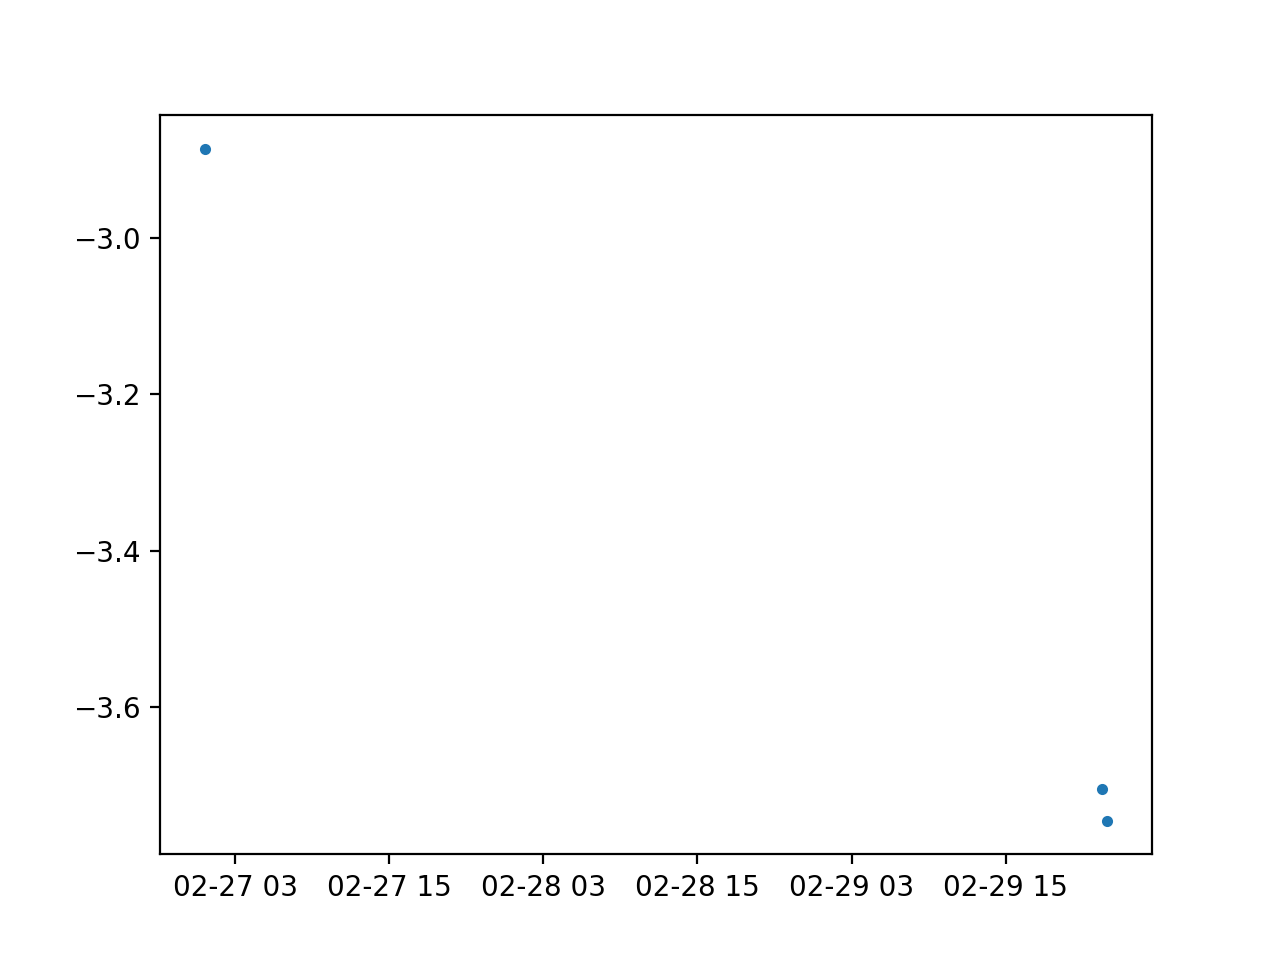

In [20]:
%matplotlib notebook
plt.figure(1)
plt.plot(df['dts'].values,df['slope'],'.')